In [1]:
!pip -q install roboflow
!pip -q install ultralytics
! pip -q install ruamel.yaml
! wget https://github.com/ultralytics/assets/releases/download/v0.0.0/yolov8m-seg.pt

from roboflow import Roboflow
import sys
import ruamel.yaml
from ultralytics import YOLO
from pathlib import Path
import os
from collections import defaultdict
import copy
import math
import shutil
import numpy as np
import psutil
import gc
import matplotlib.pyplot as plt
import locale
from IPython.display import clear_output
import ctypes
import ctypes.util
import torch
import random


# deterministic set
torch.manual_seed(43)
random.seed(43)
np.random.seed(43)


rf = Roboflow(api_key="tD9RSesaXxGqmwVD6eVZ")
project = rf.workspace("imacs-pothole-detection-wo8mu").project("pothole-detection-irkz9")
dataset = project.version(9).download("yolov8")


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyterlab 4.0.5 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which is incompatible.
jupyterlab-lsp 5.0.0 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which is incompatible.
jupyterlab-lsp 5.0.0 requires jupyterlab<5.0.0a0,>=4.0.6, but you have jupyterlab 4.0.5 which is incompatible.
pytoolconfig 1.2.6 requires packaging>=22.0, but you have packaging 21.3 which is incompatible.
tensorflowjs 4.13.0 requires packaging~=23.1, but you have packaging 21.3 which is incompatible.
ydata-profiling 4.5.1 requires numpy<1.24,>=1.16.0, but you have numpy 1.24.3 which is incompatible.
--2023-12-03 08:33:16--  https://github.com/ultralytics/assets/releases/download/v0.0.0/yolov8m-seg.pt
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... conn

A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3


loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics==8.0.196 is required but found version=8.0.221, to fix: `pip install ultralytics==8.0.196`



Extracting Dataset Version Zip to Pothole-Detection-9 in yolov8:: 100%|██████████| 6402/6402 [00:01<00:00, 4469.65it/s]


In [2]:
%cd /kaggle/working/Pothole-Detection-9

# trying to optimize RAM usage
gc.enable()

libc = ctypes.CDLL(ctypes.util.find_library('c'))
libc.malloc_trim(ctypes.c_int(0))

torch.set_num_threads(1)
os.environ["OMP_NUM_THREADS"] = "1"

/kaggle/working/Pothole-Detection-9


In [3]:
class YoloModel:
    def __init__(self, path_to_model: str, path_to_yaml: str,
                 train_perc: float, test_perc: float, val_perc: float,
                 ttvs_flag = 0, tp_flag = 0):
        """Инициализация переменных

        Args:
            path_to_model (str): путь до весов yolov8.pt
            path_to_yaml (str): путь до data.yaml файла датасета
            train_perc (float): доля тренировочных данных 
            test_perc (float): доля тестовых данных
            val_perc (float): доля валидационных данных
        """        
        self.path_to_model = path_to_model
        self.path_to_yaml = path_to_yaml
        self.train_path = Path('train') if os.path.exists(Path('train')) else None
        self.test_path = Path('test') if os.path.exists(Path('test')) else None
        self.val_path = Path('valid') if os.path.exists(Path('valid')) else None
        self.train_perc = train_perc
        self.test_perc = test_perc
        self.val_perc = val_perc
        
        self.ttvs_flag = ttvs_flag
        self.tp_flag = tp_flag
        
        self.ram_usage = []
        
        assert self.train_path != None, 'Директория train отсутствует'
        if (self.val_path == None):
            os.mkdir("valid", mode=0o777)
            os.mkdir("valid/images", mode=0o777)
            os.mkdir("valid/labels", mode=0o777)
            self.val_path = Path("valid")
        if (self.test_path == None):
            os.mkdir("test", mode=0o777)
            os.mkdir("test/images", mode=0o777)
            os.mkdir("test/labels", mode=0o777)
            self.test_path = Path("test")
    
    def get_ram_usage(self,):
        """Gets the current RAM usage of the system.

        Returns:
            float: RAM usage in GB.
        """
        return psutil.virtual_memory().used / 1e9

    def train(self, folder_name: str, iters: int) -> YOLO: 
        """Инициализация модели и обучение

        Args:
            folder_name (str): название директории с частью данных
            iters (int): кол-во интераций

        Returns:
            YOLO: экземпляр обученной модели
        """        
        # Корректируем data.yaml файл
        yaml = ruamel.yaml.YAML()
        # yaml.preserve_quotes = True
        with open('data.yaml', 'r+') as fp:
            data = yaml.load(fp)
            for elem in data:
                if elem == 'train':
                    data[elem] = './'+folder_name+'/train/images'
                elif elem == 'val':
                    data[elem] = f"./valid_{folder_name.split('_')[1]}/images"
                elif elem == 'test':
                    data[elem] = f"./test_{folder_name.split('_')[1]}/images"
            fp.truncate(0)
            fp.seek(0)
            yaml.dump(data, fp)
        self.ram_usage.append(self.get_ram_usage())
        model = YOLO(self.path_to_model)
        model.train(
            # Random Seed parameters
            deterministic=True,
            seed=43,
            data=self.path_to_yaml, 
            pretrained=True,
            exist_ok=True,
            epochs=iters,
            optimizer="SGD",
            device=0,)
        
        return model
    
    def retrain(self, folder_name: str, iters: int,) -> YOLO:
        """Обучение модели на всех предыдущих частях данных для профилакти просадки метрики

        Args:
            folder_name (str): название директории с частью данных
            iters (int): кол-во интераций

        Returns:
            YOLO: экземпляр обученной модели
        """        
        os.mkdir("retrain", mode=0o777)
        os.mkdir("retrain/train", mode=0o777)
        os.mkdir("retrain/train/images", mode=0o777)
        os.mkdir("retrain/train/labels", mode=0o777)

        # собираем список всех кусков данных до нашего folder_name
        folder_num = np.arange(1, int(folder_name.split('_')[-1]) + 1)
        cls = folder_name.split("_")[1]
        source_pathes = [f"temp_{cls}_{i}" for i in folder_num]

        # копируем все собранные куски данных в папку retrain
        for path in source_pathes:
            # собираем все файлы
            all_images_train = os.listdir(path+"/train/images")
            all_labels_train = os.listdir(path+"/train/labels")

            for image in all_images_train:
                shutil.copyfile(path+"/train/images/" + image,
                                "retrain/train/images/" + image)
            for label in all_labels_train:
                shutil.copyfile(path+"/train/labels/" + label,
                                "retrain/train/labels/" + label)

        # Корректируем data.yaml файл
        yaml = ruamel.yaml.YAML()
        with open('data.yaml', 'r+') as fp:
            data = yaml.load(fp)
            for elem in data:
                if elem == 'train':
                    data[elem] = 'retrain/train/images'
                elif elem == 'val':
                    data[elem] = f"./valid_{folder_name.split('_')[1]}/images"
                elif elem == 'test':
                    data[elem] = f"./test_{folder_name.split('_')[1]}/images"
            fp.truncate(0)
            fp.seek(0)
            yaml.dump(data, fp)
        
        self.ram_usage.append(self.get_ram_usage())
        # load a pretrained model (recommended for training)
        model = YOLO(self.path_to_model)
        model.train(# Random Seed parameters
            deterministic=True,
            seed=43,
            data=self.path_to_yaml, 
            pretrained=True,
            exist_ok=True,
            epochs=iters,
            optimizer="SGD",
            device=0,)
        
        return model
    
    def test(self, folder_name: str, model: YOLO):
        """Тестирование модели

        Args:
            model (YOLO): экземпляр обученной модели

        Returns:
            _type_: _description_
        """        
        # Корректируем data.yaml файл
        yaml = ruamel.yaml.YAML()
        with open('data.yaml', 'r+') as fp:
            data = yaml.load(fp)
            for elem in data:
                if elem == 'train':
                    data[elem] = 'retrain/train/images'
                elif elem == 'val':
                    data[elem] = f"./valid_{folder_name.split('_')[1]}/images"
                elif elem == 'test':
                    data[elem] = f"./test_{folder_name.split('_')[1]}/images"
            fp.truncate(0)
            fp.seek(0)
            yaml.dump(data, fp)
            
        metrics = model.val(data=self.path_to_yaml, split="test")
        return metrics
    
    def train_test_val_split(self, keep_perc: float):
        """Разделение изначального датасета на заданные доли train/test/val. Удаление 1-keep_perc доли данных 

        Args:
            keep_perc (float): доля данных, которую нужно оставить
        """        
        # создаем директории для объединения всех файлов
        os.mkdir("temp", mode=0o777)
        os.mkdir("temp/images", mode=0o777)
        os.mkdir("temp/labels", mode=0o777)
            
        source_pathes = (self.train_path / 'images', self.train_path / 'labels',\
                        self.test_path / 'images', self.test_path / 'labels',\
                        self.val_path / 'images', self.val_path / 'labels',)
        destination = Path('temp')

        for path in source_pathes:
            # собираем все файлы
            allfiles = os.listdir(path)
            # итерируем по всем файлам, чтобы переместить их в папку назначения
            sub_folder = path.name # images or labels
            for f in allfiles:
                src_path = os.path.join(path, f)
                dst_path = os.path.join(destination / sub_folder, f)
                os.rename(src_path, dst_path)
        total_num = len(allfiles)
        # Создаем словарь, где ключ - метка класса, значение - множество путей к label файлам данного класса
        classes = defaultdict(set)
        empty_count = 0
        for txt_path in Path("temp/labels").glob("*.txt"):
            with txt_path.open() as f:
                text = f.read()
                # Каждому объекту на изображении соотвествует одна строка, где первое значение - метка класса,
                # а остальное - координаты сегментации
                for obj in text.split('\n'):
                    if len(obj) > 0:
                        classes[obj.split()[0]].add(txt_path)
                    else:
                        print(f"Пустой файл: {txt_path}")
                        empty_count += 1
        print(f"Кол-во пустых файлов - {empty_count}")
        # Оставляем указанный процент данных
        for cls, pathes in zip(list(classes.keys()), list(classes.values())):
            num_files = len(pathes)
            num_to_del = num_files*(1-keep_perc)
            for i, file_path in enumerate(pathes.copy()):
                if i+1 >= num_to_del:
                    break
                f = file_path.name.split('.')[:-1]
                f.append('jpg')
                try:
                    Path("temp",'images',".".join(f)).unlink()
                    file_path.unlink()
                except OSError as e:
                    # Файл не найден (скорее всего имеет несколько классов и был уже перемещен)
                    pass
                classes[cls].remove(file_path)
        for cls in classes.keys():
            os.mkdir(f"valid_{cls}", mode=0o777)
            os.mkdir(f"test_{cls}", mode=0o777)


            os.mkdir(f"valid_{cls}/labels", mode=0o777)
            os.mkdir(f"valid_{cls}/images", mode=0o777)
            os.mkdir(f"test_{cls}/labels", mode=0o777)
            os.mkdir(f"test_{cls}/images", mode=0o777)
        # Распределяем данные по директориям train, test, val с учетом указанных пропорций
        class_copy = copy.deepcopy(classes)
        for cls, pathes in zip(list(classes.keys()), list(classes.values())):
            num_files = len(class_copy[cls])
            num_to_mv_train = int(num_files * self.train_perc)
            num_to_mv_test = int(num_files * self.test_perc)
            num_to_mv_val = int(num_files * self.val_perc)
            # print(num_files, num_to_mv, len(pathes))
            temp_dict_name = "train"
            for i, file_path in enumerate(pathes.copy()):
                if i+1 > num_to_mv_train and i+1 < num_to_mv_val + num_to_mv_train:
                    temp_dict_name = f"valid_{cls}"
                elif i+1 > num_to_mv_val + num_to_mv_train:
                    temp_dict_name = f"test_{cls}"
                f = file_path.name.split('.')[:-1]
                f.append('jpg')
                shutil.copyfile(Path("temp", "images", ".".join(f)),
                                Path(temp_dict_name, "images").joinpath(Path("train", "images", ".".join(f)).name))
                shutil.copyfile(file_path,
                                Path(temp_dict_name, "labels").joinpath(file_path.name))
                if temp_dict_name != "train":
                    # remove another classes in label file
                    orig_lines = [line.strip() for line in open(Path(temp_dict_name, "labels").joinpath(file_path.name))]
                    new_lines = [l for l in orig_lines if l.split()[0] == str(cls)]

                    with open(Path(temp_dict_name, "labels").joinpath(file_path.name), 'w') as fp:
                        print(*new_lines, sep='\n', file=fp)
                classes[cls].remove(file_path)
            dir_path = f"valid_{cls}/images"
            print(dir_path, len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))]))
            dir_path = f"test_{cls}/images"
            print(dir_path, len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))]))
        dir_path = f"train/labels"
        print(dir_path, len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))]), "\n")
        
        shutil.rmtree("temp")
    
    def __train_set_of(self,n):
        x = []
        temp = 2
        while temp < n:
            x.append(temp)
            if temp < 10:
                temp+=2
            elif temp >= 10 and temp < 30:
                temp += 3
            elif temp >= 30 and temp < 100:
                temp += 5
            elif temp >= 100 and temp < 200:
                temp += 10
            elif temp >= 200 and temp < 300:
                temp += 50
            elif temp >= 300 and temp < 500:
                temp +=100
            elif temp >= 500:
                temp += 500
        if x[-1] != n:
            x.append(n)
            
        return x


    def take_piece(self, piece_perc: float = None, fib_flag:bool = False) -> (dict, dict):
        """Разделение исходного датасета на части равные доле piece_perc по директориям temp_{n}, n = {1..1/piece_perc}

        Args:
            piece_perc (float): доля части данных, на которые нужно поделить датасет
        """

        source_pathes = (self.train_path / 'images', self.train_path / 'labels')
        
        # Создаем словарь, где ключ - метка класса, значение - множество путей к label файлам данного класса
        classes = defaultdict(set)
        empty_count = 0
        for txt_path in Path("train/labels").glob("*.txt"):
            with txt_path.open() as f:
                text = f.read()
                # Каждому объекту на изображении соотвествует одна строка, где первое значение - метка класса,
                # а остальное - координаты сегментации
                for obj in text.split('\n'):
                    if len(obj) > 0:
                        classes[obj.split()[0]].add(txt_path)
                    else:
                        print(f"Пустой файл: {txt_path}")
                        empty_count += 1
                        
        print(f"Кол-во пустых файлов - {empty_count}")
        d_c = {key: len(value) for key, value in zip(classes.keys(), classes.values())}
        print(*[f"Класс {key} содержит {value} объекта(-ов)\n" for key, value in zip(d_c.keys(), d_c.values())])
        
        cls_tl_dict = defaultdict(list) # key - class, value - result of __train_set_of(n)
        cls_fif_dict = defaultdict(int) # key - class, value - num folders
        # Разделить сначала по классам, а потом внутри класса разделить по __train_set_of
        for cls in classes.keys():
            print(f"Класс {cls}")
            total_num = len(classes[cls])
            print(f"\tКол-во train класса {cls}: {total_num}")
            if fib_flag == True:
                n = total_num
                train_list = self.__train_set_of(n)
                files_in_folder = []
                for i in range(len(train_list)):
                    if i == 0:
                        files_in_folder.append(train_list[i])
                        continue
                    files_in_folder.append(train_list[i] - train_list[i-1])
                print(f"\tКоличество данных (train) на каждой итерации класса {cls}: {train_list}")
                cls_tl_dict[cls] = train_list
                cls_fif_dict[cls] = len(files_in_folder)

            if fib_flag == True:
                self.num_folders = len(files_in_folder)
                print(f"\tКол-во директорий для класса {cls}: {self.num_folders} ")
            else:
                self.num_folders = 1 / piece_perc
            for folder in range(int(self.num_folders)):
                os.mkdir(f"temp_{cls}_{folder+1}", mode=0o777)

                os.mkdir(f"temp_{cls}_{folder+1}/train", mode=0o777)

                os.mkdir(f"temp_{cls}_{folder+1}/train/labels", mode=0o777)
                os.mkdir(f"temp_{cls}_{folder+1}/train/images", mode=0o777)
            
            # Распределяем данные по директориям  
            class_copy = copy.deepcopy(classes)
            for f_i, folder in enumerate(range(int(self.num_folders))):
                folder_name = f"temp_{cls}_{folder+1}"
                num_to_mv_train = int(num_files * piece_perc) if fib_flag == False else files_in_folder[f_i]
                print(f"\tnum_to_mv_train {num_to_mv_train}, folder {folder}, cls {cls}")
                # print(num_files, num_to_mv, len(pathes))
                temp_dict_name = "train"
                for i, file_path in enumerate(classes[cls].copy()):
                    if i+1 > num_to_mv_train:
                        break
                    f = file_path.name.split('.')[:-1]
                    f.append('jpg')
                    shutil.copyfile(Path("train", "images", ".".join(f)),
                                    Path(folder_name, temp_dict_name, "images").joinpath(Path("train", "images", ".".join(f)).name))
                    shutil.copyfile(file_path,
                                    Path(folder_name, temp_dict_name, "labels").joinpath(file_path.name))
                    # remove another classes in label file
                    orig_lines = [line.strip() for line in open(Path(folder_name, temp_dict_name, "labels").joinpath(file_path.name))]
                    new_lines = [l for l in orig_lines if l.split()[0] == str(cls)]

                    with open(Path(folder_name, temp_dict_name, "labels").joinpath(file_path.name), 'w') as fp:
                        print(*new_lines, sep='\n', file=fp)
                    classes[cls].remove(file_path)
            for folder in range(int(self.num_folders)):
                dir_path = f"temp_{cls}_{folder+1}/train/labels"
                print(dir_path, len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))]))
                dir_path = f"temp_{cls}_{folder+1}/train/images"
                print(dir_path, len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))]), "\n")
        return cls_tl_dict, cls_fif_dict
    
    def plot_result(self, result_dict: dict, color_dict = "green", fib_list:list = None):
        '''Функция для отрисовки графиков зависимости метрик от размера обучающей выборки

        Args:
            result_dict (dict): словарь с метриками {доля данных: массив метрик}
            color_dict (dict): словарь с индикаторами повторного обучения
        '''
        metrics_names = ("mAP","mAP50", "mAP75")
        colors = list(color_dict.values()) if color_dict != 'green' else color_dict
        if fib_list == None:
            for i, metric in enumerate(metrics_names):
                plt.scatter(list(result_dict.keys()), [j[i] for j in result_dict.values()], color=colors, zorder=1)
                plt.plot(list(result_dict.keys()), [j[i] for j in result_dict.values()], linestyle='-')
                plt.ylabel(metric)
                plt.xlabel("Num files (train)")
                plt.xticks(ticks=list(result_dict.keys())) 
                plt.show()
        else:
            for i, metric in enumerate(metrics_names):
                plt.scatter(fib_list, [j[i] for j in result_dict.values()], color=colors, zorder=1)
                plt.plot(fib_list, [j[i] for j in result_dict.values()], linestyle='-')
                plt.ylabel(metric)
                plt.xlabel("Num files (train)")
                plt.xticks(ticks=list(fib_list)) 
                plt.show()

    def plot_ram_usage(self,):
        '''Функция для отрисовки использования RAM в процессе обучения'''
        plt.plot(self.ram_usage, marker='o', linestyle='-', color='b')
        plt.xlabel('Iteration')
        plt.ylabel('RAM Usage (GB)')
        plt.title('RAM Usage During Training')
        plt.show()
    
    def __early_stopping(self, result_dict: dict, prev_num: int, threshold: float) -> bool:
        keys_sorted = sorted(result_dict.keys())
        prev_results = np.array([result_dict[i][0] for i in keys_sorted[-prev_num-1:-1]])
        res = result_dict[keys_sorted[-1]][0] - prev_results
        print(f"Progress for {prev_num} last iterations with {threshold} threshold = {np.sum(res)}")
        if np.sum(res) < threshold:
            return True
        else:
            return False
    
    def increm_learning(self, keep_perc: float, iters: int, piece_perc:float = None, fib_flag:bool = None, prev_num:int = 3, threshold:float = 0.01) -> (list,list):
        os.environ['WANDB_DISABLED'] = 'true'
        # делим датасет на тренировочную/тестовую/валидационную выборку
        if self.ttvs_flag == 0:
            self.train_test_val_split(keep_perc)
            self.ttvs = 1
        if self.tp_flag == 0:
            cls_tl_dict, cls_fif_dict = self.take_piece(piece_perc, fib_flag)
            self.tp = 1
        else:
            assert fib_flag == False
            self.num_folders = 1 / piece_perc
        # путь к изначальным весам yolov8 для повторного обучения при понижении метрики
        native_path_to_model = self.path_to_model
        # словарь с метриками {доля данных: массив метрик}
        # Инкрементальное обучение 
        for cls in cls_tl_dict.keys():
            result_dict = defaultdict(list)
            # словарь с индикаторами повторного обучения
            color_dict = defaultdict(str)
            # переменная для отслеживания максимального map в целях профилактики просадок метрики
            max_map = 0
            self.path_to_model = native_path_to_model
            for folder in range(cls_fif_dict[cls]):
                if (folder > prev_num):
                    if self.__early_stopping(result_dict, prev_num, threshold):
                        break
                libc = ctypes.CDLL(ctypes.util.find_library('c'))
                libc.malloc_trim(ctypes.c_int(0))

                torch.set_num_threads(1)
                folder_name = f"temp_{cls}_{folder+1}"
                # дообучаем модель
                model = self.train(folder_name, iters)
                # тестируем модель
                metrics = self.test(folder_name, model)
                # проверяем, что метрика улучшается
                if metrics.seg.map > max_map:
                    max_map = metrics.seg.map
                    # заносим метрики в словарь
                    result_dict[folder].append(metrics.seg.map)
                    result_dict[folder].append(metrics.seg.map50)
                    result_dict[folder].append(metrics.seg.map75)
                    color_dict[folder] = "green"
#                     clear_output(wait=True)
                    del(model)
                    del(metrics)
                    gc.collect()
                    self.path_to_model = "./runs/segment/train/weights/last.pt"
                else:
                    self.path_to_model = native_path_to_model
                    # дообучаем модель
                    model = self.retrain(folder_name, iters)
                    # тестируем модель
                    metrics = self.test(folder_name, model)
                    if metrics.seg.map > max_map:
                        max_map = metrics.seg.map
                    # заносим метрики в словарь
                    result_dict[folder].append(metrics.seg.map)
                    result_dict[folder].append(metrics.seg.map50)
                    result_dict[folder].append(metrics.seg.map75)
                    color_dict[folder] = "blue"
#                     clear_output(wait=True)
                    del(model)
                    del(metrics)
                    gc.collect()
                    self.path_to_model = "./runs/segment/train/weights/last.pt"
                    shutil.rmtree("retrain")
                
            print(f"Итоговый результат (инкрементальное обучение) для класса {cls}: \n {result_dict}")
            print(f"Количество данных (train) для класса {cls}: {cls_tl_dict[cls]}")
            self.plot_result(result_dict, color_dict) if fib_flag == False else self.plot_result(result_dict, color_dict, cls_tl_dict[cls][:len(result_dict.keys())])

    def base_learning(self, keep_perc: float, piece_perc: float, iters: int):
        os.environ['WANDB_DISABLED'] = 'true'
        # делим датасет на тренировочную/тестовую/валидационную выборку
        if self.ttvs_flag == 0:
            self.train_test_val_split(keep_perc)
            self.ttvs = 1
        if self.tp_flag == 0:
            self.take_piece(piece_perc)
            self.tp_flag = 1
        else: 
            self.num_folders = 1 / piece_perc
        # путь к изначальным весам yolov8 для повторного обучения при понижении метрики
        native_path_to_model = self.path_to_model
        # словарь с метриками {доля данных: массив метрик}
        result_dict = {k_p:[] for k_p in range(int(self.num_folders))}
        
        for folder in range(int(self.num_folders)):
            folder_name = f"temp_{folder+1}"
            # дообучаем модель
            model = self.retrain(folder_name, iters)
            # тестируем модель
            metrics = self.test(model)
            # заносим метрики в словарь
            result_dict[folder].append(metrics.seg.map)
            result_dict[folder].append(metrics.seg.map50)
            result_dict[folder].append(metrics.seg.map75)
            clear_output(wait=True)
            del(model)
            del(metrics)
            gc.collect()
            shutil.rmtree("retrain")
            
        print(f"Итоговый результат (базовое обучение): \n {result_dict}")
        self.plot_result(result_dict)
        
        return result_dict

Пустой файл: temp/labels/img_1640_jpg.rf.1778c59bf5036fc27da508f6dfaa70b6.txt
Пустой файл: temp/labels/img_1879_jpg.rf.2238fea06fb0d033bd756e9230bc6dac.txt
Пустой файл: temp/labels/img_0832_jpg.rf.30f1a5963e4aed5abeb054b59fda1fbf.txt
Пустой файл: temp/labels/img_1557_jpg.rf.c77f0a674c2532c9aad2340dac155939.txt
Пустой файл: temp/labels/img_1879_jpg.rf.4f6782ce35182b93e51f4e0ff9cd7950.txt
Пустой файл: temp/labels/img_0832_jpg.rf.7fac992dd44b00885280ec87ee3e1da6.txt
Пустой файл: temp/labels/img_1557_jpg.rf.63ace4635038aaa14502e0b1db6b3c7b.txt
Пустой файл: temp/labels/img_0832_jpg.rf.298af72a8437240adc8e31cf658b1c17.txt
Пустой файл: temp/labels/img_0048_jpg.rf.c092197014696025124d178e2bab72b8.txt
Пустой файл: temp/labels/img_1640_jpg.rf.bb5e2ef933ba51f4ef29482ff939e5ec.txt
Пустой файл: temp/labels/img_0056_jpg.rf.9542cc1a9628937f64d1be4b885a7b6f.txt
Пустой файл: temp/labels/img_0905_jpg.rf.87137efed7788ee2327b85f51cbf5e78.txt
Пустой файл: temp/labels/img_0199_jpg.rf.32b1bd220181ed008a5457e

100%|██████████| 755k/755k [00:00<00:00, 38.6MB/s]
2023-12-03 08:33:48,734	INFO util.py:129 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2023-12-03 08:33:50,078	INFO util.py:129 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytics

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...


100%|██████████| 6.23M/6.23M [00:00<00:00, 158MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/Pothole-Detection-9/temp_0_1/train/labels... 2 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2/2 [00:00<00:00, 186.72it/s]

train: New cache created: /kaggle/working/Pothole-Detection-9/temp_0_1/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/working/Pothole-Detection-9/valid_0/labels... 317 images, 0 backgrounds, 0 corrupt: 100%|██████████| 317/317 [00:00<00:00, 753.10it/s]

val: New cache created: /kaggle/working/Pothole-Detection-9/valid_0/labels.cache


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      1.59G      1.985      5.879      3.137      2.021          8        640: 100%|██████████| 1/1 [00:03<00:00,  3.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.36it/s]

                   all        317        577       0.02     0.0485     0.0054    0.00188     0.0111     0.0364     0.0032    0.00118



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5       1.6G      2.098       4.49      4.073      2.187          5        640: 100%|██████████| 1/1 [00:00<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.40it/s]

                   all        317        577     0.0246     0.0607    0.00603    0.00228     0.0153     0.0312    0.00394    0.00143



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      1.61G      1.763      4.209      3.769      1.995          4        640: 100%|██████████| 1/1 [00:00<00:00,  5.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]

                   all        317        577     0.0262     0.0503    0.00684    0.00274     0.0174     0.0381    0.00468    0.00182



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      1.59G      1.516      4.598      5.309      1.716          2        640: 100%|██████████| 1/1 [00:00<00:00,  5.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]

                   all        317        577     0.0308     0.0607    0.00851    0.00317     0.0246     0.0416    0.00579    0.00228



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      1.59G      2.381      3.992      4.213      2.212          3        640: 100%|██████████| 1/1 [00:00<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.41it/s]

                   all        317        577     0.0343     0.0711    0.00912     0.0036     0.0251      0.052    0.00661    0.00265



5 epochs completed in 0.015 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:09<00:00,  1.04it/s]


                   all        317        577     0.0342     0.0659    0.00906    0.00353     0.0261     0.0503    0.00651    0.00258
Speed: 0.8ms preprocess, 12.5ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▂▄▇█
wandb:        metrics/mAP50(M) ▁▃▄▆█
wandb:     metrics/mAP50-95(B) ▁▃▅▆█
wandb:     metrics/mAP50-95(M) ▁▂▄▆█
wandb:    metrics/precision(B) ▁▃▄▆█
wandb:    metrics/precision(M) ▁▃▄▇█
wandb:       metrics/recall(B) ▁▆▂▆█
wandb:       metrics/recall(M) ▃▁▄▅█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▅▆▃▁█
wandb:          train/cls_loss ▁▄▃█▄
wandb:          train/dfl_loss ▅█▅▁█
wandb:          train/seg_loss █▃▂▃▁
wandb:            val/box_loss █▅▃▁▁
wandb:            val/cls_loss █▃▂▁▁
wandb:            val/dfl_loss █▅▃▂▁
wandb:            val/seg_loss █▄▂▁▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/Pothole-Detection-9/test_0/labels... 318 images, 0 backgrounds, 0 corrupt: 100%|██████████| 318/318 [00:00<00:00, 981.12it/s]

val: New cache created: /kaggle/working/Pothole-Detection-9/test_0/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:14<00:00,  1.38it/s]


                   all        318        581     0.0276     0.0775    0.00787    0.00323     0.0173     0.0568    0.00536    0.00223
Speed: 1.1ms preprocess, 27.4ms inference, 0.0ms loss, 4.9ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/Pothole-Detection-9/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=No

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/Pothole-Detection-9/temp_0_2/train/labels... 2 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2/2 [00:00<00:00, 896.31it/s]

train: New cache created: /kaggle/working/Pothole-Detection-9/temp_0_2/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/Pothole-Detection-9/valid_0/labels.cache... 317 images, 0 backgrounds, 0 corrupt: 100%|██████████| 317/317 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.54G      2.297      4.104       4.26       2.23         15        640: 100%|██████████| 1/1 [00:00<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.32it/s]

                   all        317        577     0.0265      0.052    0.00804    0.00293     0.0127     0.0277    0.00357    0.00131



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      1.57G      1.114      5.436        6.6      1.288          2        640: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.37it/s]

                   all        317        577     0.0379     0.0641    0.00905    0.00325     0.0161     0.0312    0.00416    0.00153



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      1.49G       1.65      2.968      4.302      1.851          5        640: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.37it/s]

                   all        317        577     0.0431     0.0607     0.0096    0.00368     0.0167     0.0329    0.00474    0.00178



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      1.51G      2.202      5.043      4.865      2.092          6        640: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]

                   all        317        577      0.041     0.0589    0.00949    0.00383     0.0209     0.0364    0.00496    0.00189



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      1.49G      1.433      4.721       4.21       1.67          5        640: 100%|██████████| 1/1 [00:00<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]

                   all        317        577     0.0399     0.0711    0.00986    0.00387     0.0205     0.0555    0.00536    0.00201



5 epochs completed in 0.015 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:09<00:00,  1.00it/s]


                   all        317        577     0.0402     0.0711    0.00989    0.00389     0.0215     0.0555    0.00537    0.00201
Speed: 1.1ms preprocess, 12.6ms inference, 0.0ms loss, 5.1ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▅▇▇█
wandb:        metrics/mAP50(M) ▁▃▆▆█
wandb:     metrics/mAP50-95(B) ▁▃▆██
wandb:     metrics/mAP50-95(M) ▁▃▆▇█
wandb:    metrics/precision(B) ▁▆█▇▇
wandb:    metrics/precision(M) ▁▄▄▇█
wandb:       metrics/recall(B) ▁▅▄▄█
wandb:       metrics/recall(M) ▁▂▂▃█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▁▄▇▃
wandb:          train/cls_loss ▁█▁▃▁
wandb:          train/dfl_loss █▁▅▇▄
wandb:          train/seg_loss ▄█▁▇▆
wandb:            val/box_loss █▆▃▂▁
wandb:            val/cls_loss █▆▅▄▁
wandb:            val/dfl_loss █▆▃▂▁
wandb:            val/seg_loss █▅▃▂▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/Pothole-Detection-9/test_0/labels.cache... 318 images, 0 backgrounds, 0 corrupt: 100%|██████████| 318/318 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:14<00:00,  1.35it/s]


                   all        318        581     0.0327     0.0585    0.00852    0.00322     0.0291     0.0413    0.00628    0.00213
Speed: 0.9ms preprocess, 28.0ms inference, 0.0ms loss, 5.1ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/Pothole-Detection-9/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vi

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/Pothole-Detection-9/retrain/train/labels... 4 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4/4 [00:00<00:00, 640.18it/s]

train: New cache created: /kaggle/working/Pothole-Detection-9/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/Pothole-Detection-9/valid_0/labels.cache... 317 images, 0 backgrounds, 0 corrupt: 100%|██████████| 317/317 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      5.56G      1.808      4.897      3.795      2.087         11        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.32it/s]

                   all        317        577     0.0175     0.0503      0.005    0.00181     0.0103     0.0329    0.00307    0.00113



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      2.97G      2.261      4.895      6.106      2.215          7        640: 100%|██████████| 1/1 [00:00<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.33it/s]

                   all        317        577     0.0209     0.0607    0.00548    0.00204     0.0139     0.0433    0.00362    0.00134



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5         3G      2.222      3.695      4.047      2.044         12        640: 100%|██████████| 1/1 [00:00<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.36it/s]

                   all        317        577     0.0244     0.0676    0.00655     0.0025     0.0145     0.0451    0.00417    0.00165



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5         3G      2.295       4.27      3.678      2.118         12        640: 100%|██████████| 1/1 [00:00<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]

                   all        317        577     0.0303     0.0537    0.00741    0.00277     0.0196     0.0381      0.005    0.00185



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      2.89G      1.784      3.034      3.868      1.595         13        640: 100%|██████████| 1/1 [00:00<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.37it/s]

                   all        317        577     0.0286      0.052    0.00755    0.00296     0.0231     0.0433    0.00556    0.00215



5 epochs completed in 0.015 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


                   all        317        577     0.0287      0.052    0.00753    0.00298     0.0223     0.0381     0.0056    0.00214
Speed: 1.1ms preprocess, 12.9ms inference, 0.0ms loss, 4.8ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▂▅██
wandb:        metrics/mAP50(M) ▁▃▄▆█
wandb:     metrics/mAP50-95(B) ▁▂▅▇█
wandb:     metrics/mAP50-95(M) ▁▂▅▆█
wandb:    metrics/precision(B) ▁▃▅█▇
wandb:    metrics/precision(M) ▁▃▃▆█
wandb:       metrics/recall(B) ▁▅█▂▂
wandb:       metrics/recall(M) ▁▇█▄▄
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▁█▇█▁
wandb:          train/cls_loss ▁█▂▁▂
wandb:          train/dfl_loss ▇█▆▇▁
wandb:          train/seg_loss ██▃▆▁
wandb:            val/box_loss █▆▃▂▁
wandb:            val/cls_loss █▁▄▇▁
wandb:            val/dfl_loss █▆▃▂▁
wandb:            val/seg_loss █▄▂▁▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/Pothole-Detection-9/test_0/labels.cache... 318 images, 0 backgrounds, 0 corrupt: 100%|██████████| 318/318 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:15<00:00,  1.31it/s]


                   all        318        581     0.0233     0.0551    0.00648    0.00266     0.0136     0.0551    0.00476      0.002
Speed: 1.0ms preprocess, 28.4ms inference, 0.0ms loss, 5.7ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/Pothole-Detection-9/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=No

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/Pothole-Detection-9/temp_0_3/train/labels... 2 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2/2 [00:00<00:00, 568.26it/s]

train: New cache created: /kaggle/working/Pothole-Detection-9/temp_0_3/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/Pothole-Detection-9/valid_0/labels.cache... 317 images, 0 backgrounds, 0 corrupt: 100%|██████████| 317/317 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      5.87G      2.137      4.256      4.703      2.042          6        640: 100%|██████████| 1/1 [00:00<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.35it/s]

                   all        317        577     0.0203     0.0433     0.0067    0.00244     0.0114     0.0312    0.00306     0.0011



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      1.58G      1.995      6.152        5.7      2.559          3        640: 100%|██████████| 1/1 [00:00<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.36it/s]

                   all        317        577     0.0314     0.0503    0.00787    0.00282     0.0119     0.0381     0.0036    0.00126



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      1.46G      1.677      4.223      5.153        1.9          3        640: 100%|██████████| 1/1 [00:00<00:00,  5.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.37it/s]

                   all        317        577     0.0314     0.0468    0.00896    0.00308     0.0163     0.0433    0.00403    0.00142



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      1.48G      1.752      3.513      5.737      1.826          4        640: 100%|██████████| 1/1 [00:00<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.36it/s]

                   all        317        577     0.0355     0.0503    0.00929    0.00339     0.0221      0.026    0.00444     0.0016



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      1.47G      1.506      5.155      7.312      1.951          2        640: 100%|██████████| 1/1 [00:00<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.37it/s]

                   all        317        577     0.0415     0.0555    0.00992    0.00375     0.0212     0.0468    0.00543     0.0019



5 epochs completed in 0.015 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:09<00:00,  1.00it/s]


                   all        317        577     0.0422     0.0537    0.00995    0.00376     0.0214     0.0485    0.00557    0.00193
Speed: 1.0ms preprocess, 12.7ms inference, 0.0ms loss, 4.4ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▄▆▇█
wandb:        metrics/mAP50(M) ▁▃▄▅█
wandb:     metrics/mAP50-95(B) ▁▃▄▆█
wandb:     metrics/mAP50-95(M) ▁▂▄▅█
wandb:    metrics/precision(B) ▁▅▅▆█
wandb:    metrics/precision(M) ▁▁▄██
wandb:       metrics/recall(B) ▁▆▃▆█
wandb:       metrics/recall(M) ▃▅▆▁█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▆▃▄▁
wandb:          train/cls_loss ▁▄▂▄█
wandb:          train/dfl_loss ▃█▂▁▂
wandb:          train/seg_loss ▃█▃▁▅
wandb:            val/box_loss █▅▃▂▁
wandb:            val/cls_loss ▅█▆▄▁
wandb:            val/dfl_loss █▅▄▃▁
wandb:            val/seg_loss █▅▄▂▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/Pothole-Detection-9/test_0/labels.cache... 318 images, 0 backgrounds, 0 corrupt: 100%|██████████| 318/318 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:15<00:00,  1.33it/s]


                   all        318        581     0.0278     0.0568    0.00725    0.00265     0.0249     0.0413    0.00494    0.00181
Speed: 0.9ms preprocess, 28.2ms inference, 0.0ms loss, 5.9ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/Pothole-Detection-9/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vi

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/Pothole-Detection-9/retrain/train/labels... 6 images, 0 backgrounds, 0 corrupt: 100%|██████████| 6/6 [00:00<00:00, 714.27it/s]

train: New cache created: /kaggle/working/Pothole-Detection-9/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/Pothole-Detection-9/valid_0/labels.cache... 317 images, 0 backgrounds, 0 corrupt: 100%|██████████| 317/317 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      5.52G      1.366      3.418      4.512      1.664         12        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.28it/s]

                   all        317        577     0.0183     0.0503    0.00519    0.00183     0.0114     0.0347    0.00307    0.00112



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      3.95G      1.517      4.971      3.962      1.698         13        640: 100%|██████████| 1/1 [00:00<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.32it/s]

                   all        317        577     0.0196     0.0537    0.00555    0.00205     0.0139     0.0381    0.00363    0.00134



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      3.84G      1.925      4.041      4.899      2.047         10        640: 100%|██████████| 1/1 [00:00<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.36it/s]

                   all        317        577      0.023     0.0693    0.00648    0.00245      0.015     0.0468    0.00431    0.00161



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      3.89G      1.906      4.374      4.558       2.05         18        640: 100%|██████████| 1/1 [00:00<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.36it/s]


                   all        317        577     0.0337     0.0641    0.00742    0.00271     0.0183     0.0381    0.00501    0.00187

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.87G       1.74      4.202      4.112      1.774         14        640: 100%|██████████| 1/1 [00:00<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.37it/s]

                   all        317        577     0.0357     0.0589     0.0082    0.00297     0.0211     0.0416    0.00577    0.00211



5 epochs completed in 0.015 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


                   all        317        577     0.0354     0.0607    0.00825    0.00298     0.0208     0.0399    0.00565    0.00211
Speed: 0.9ms preprocess, 12.9ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▂▄▆█
wandb:        metrics/mAP50(M) ▁▃▄▆█
wandb:     metrics/mAP50-95(B) ▁▂▅▆█
wandb:     metrics/mAP50-95(M) ▁▃▄▆█
wandb:    metrics/precision(B) ▁▂▃▇█
wandb:    metrics/precision(M) ▁▃▄▆█
wandb:       metrics/recall(B) ▁▂█▆▅
wandb:       metrics/recall(M) ▁▃█▃▄
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▁▃██▆
wandb:          train/cls_loss ▅▁█▅▂
wandb:          train/dfl_loss ▁▂██▃
wandb:          train/seg_loss ▁█▄▅▅
wandb:            val/box_loss █▆▃▂▁
wandb:            val/cls_loss █▅▂▂▁
wandb:            val/dfl_loss █▆▃▂▁
wandb:            val/seg_loss █▄▂▁▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/Pothole-Detection-9/test_0/labels.cache... 318 images, 0 backgrounds, 0 corrupt: 100%|██████████| 318/318 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:15<00:00,  1.33it/s]


                   all        318        581     0.0196     0.0568    0.00634    0.00263     0.0158     0.0551    0.00486    0.00197
Speed: 1.0ms preprocess, 28.5ms inference, 0.0ms loss, 5.3ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/Pothole-Detection-9/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=No

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/Pothole-Detection-9/temp_0_4/train/labels... 2 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2/2 [00:00<00:00, 528.92it/s]

train: New cache created: /kaggle/working/Pothole-Detection-9/temp_0_4/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/Pothole-Detection-9/valid_0/labels.cache... 317 images, 0 backgrounds, 0 corrupt: 100%|██████████| 317/317 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.68G      1.868       3.57      5.138      2.161          5        640: 100%|██████████| 1/1 [00:00<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.33it/s]

                   all        317        577     0.0254     0.0537    0.00748    0.00259      0.011     0.0277    0.00331    0.00118



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5       1.6G      1.123      3.355      12.72      1.318          1        640: 100%|██████████| 1/1 [00:00<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.35it/s]

                   all        317        577     0.0283     0.0676    0.00841    0.00298     0.0203     0.0243    0.00421    0.00143



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      1.48G      3.176      4.384      7.437      2.656          2        640: 100%|██████████| 1/1 [00:00<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.37it/s]

                   all        317        577     0.0347     0.0503    0.00879    0.00328     0.0233     0.0312    0.00463    0.00166



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      1.47G       1.49      4.633      7.766      1.934          2        640: 100%|██████████| 1/1 [00:00<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.35it/s]

                   all        317        577     0.0353     0.0589    0.00922    0.00361     0.0194     0.0364    0.00499    0.00189



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      1.47G      1.553      3.653      4.686      1.597          2        640: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.36it/s]

                   all        317        577     0.0415     0.0641    0.00964    0.00378     0.0228     0.0503    0.00546    0.00209



5 epochs completed in 0.015 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:09<00:00,  1.03it/s]


                   all        317        577     0.0417     0.0641    0.00955    0.00377     0.0234     0.0503    0.00546     0.0021
Speed: 1.0ms preprocess, 12.9ms inference, 0.0ms loss, 4.4ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▄▅▇█
wandb:        metrics/mAP50(M) ▁▄▅▆█
wandb:     metrics/mAP50-95(B) ▁▃▅▇█
wandb:     metrics/mAP50-95(M) ▁▃▅▆█
wandb:    metrics/precision(B) ▁▂▅▅█
wandb:    metrics/precision(M) ▁▆█▆█
wandb:       metrics/recall(B) ▂█▁▅▇
wandb:       metrics/recall(M) ▂▁▃▄█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▄▁█▂▂
wandb:          train/cls_loss ▁█▃▄▁
wandb:          train/dfl_loss ▅▁█▄▂
wandb:          train/seg_loss ▂▁▇█▃
wandb:            val/box_loss █▆▃▂▁
wandb:            val/cls_loss ▅█▇▁▄
wandb:            val/dfl_loss █▆▄▃▁
wandb:            val/seg_loss █▅▃▂▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/Pothole-Detection-9/test_0/labels.cache... 318 images, 0 backgrounds, 0 corrupt: 100%|██████████| 318/318 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:14<00:00,  1.34it/s]


                   all        318        581     0.0321     0.0654    0.00795    0.00301     0.0238     0.0448     0.0055    0.00195
Speed: 1.1ms preprocess, 27.9ms inference, 0.0ms loss, 5.9ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/Pothole-Detection-9/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vi

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/Pothole-Detection-9/retrain/train/labels... 8 images, 0 backgrounds, 0 corrupt: 100%|██████████| 8/8 [00:00<00:00, 1425.36it/s]

train: New cache created: /kaggle/working/Pothole-Detection-9/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/Pothole-Detection-9/valid_0/labels.cache... 317 images, 0 backgrounds, 0 corrupt: 100%|██████████| 317/317 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.32G      1.747      3.789       3.78      1.777         23        640: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.27it/s]

                   all        317        577      0.017     0.0537    0.00514    0.00179     0.0122     0.0295    0.00312    0.00111



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.67G      1.637       3.65      4.591      1.797         15        640: 100%|██████████| 1/1 [00:00<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.32it/s]

                   all        317        577      0.021     0.0485    0.00562      0.002     0.0133     0.0381    0.00354    0.00128



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.56G      1.801       4.45      4.779       1.86         18        640: 100%|██████████| 1/1 [00:00<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.33it/s]

                   all        317        577     0.0234     0.0589    0.00608    0.00228     0.0152     0.0312    0.00417    0.00154



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.55G      1.698      3.721      4.339      1.702         18        640: 100%|██████████| 1/1 [00:00<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]

                   all        317        577     0.0265     0.0659    0.00713    0.00263     0.0167     0.0416    0.00477    0.00182



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.57G      2.549      4.459       5.14      2.323         20        640: 100%|██████████| 1/1 [00:00<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.37it/s]

                   all        317        577     0.0336     0.0624    0.00814    0.00294     0.0207     0.0399    0.00543    0.00206



5 epochs completed in 0.015 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


                   all        317        577     0.0332     0.0641     0.0081    0.00292     0.0207     0.0399    0.00541    0.00206
Speed: 1.0ms preprocess, 12.8ms inference, 0.0ms loss, 4.6ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▂▃▆█
wandb:        metrics/mAP50(M) ▁▂▄▆█
wandb:     metrics/mAP50-95(B) ▁▂▄▆█
wandb:     metrics/mAP50-95(M) ▁▂▄▆█
wandb:    metrics/precision(B) ▁▃▄▅█
wandb:    metrics/precision(M) ▁▂▃▅█
wandb:       metrics/recall(B) ▃▁▅█▇
wandb:       metrics/recall(M) ▁▆▂█▇
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▂▁▂▁█
wandb:          train/cls_loss ▁▅▆▄█
wandb:          train/dfl_loss ▂▂▃▁█
wandb:          train/seg_loss ▂▁█▂█
wandb:            val/box_loss █▆▄▂▁
wandb:            val/cls_loss █▅▁▄▄
wandb:            val/dfl_loss █▆▄▂▁
wandb:            val/seg_loss █▄▃▂▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/Pothole-Detection-9/test_0/labels.cache... 318 images, 0 backgrounds, 0 corrupt: 100%|██████████| 318/318 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:15<00:00,  1.32it/s]


                   all        318        581      0.021     0.0671    0.00625    0.00255     0.0135     0.0482    0.00472    0.00194
Speed: 1.0ms preprocess, 28.1ms inference, 0.0ms loss, 6.4ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/Pothole-Detection-9/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=No

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/Pothole-Detection-9/temp_0_5/train/labels... 2 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2/2 [00:00<00:00, 806.29it/s]

train: New cache created: /kaggle/working/Pothole-Detection-9/temp_0_5/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/Pothole-Detection-9/valid_0/labels.cache... 317 images, 0 backgrounds, 0 corrupt: 100%|██████████| 317/317 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      5.83G     0.9794      2.466      4.563      1.294          5        640: 100%|██████████| 1/1 [00:00<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.31it/s]

                   all        317        577      0.028     0.0607    0.00731    0.00267     0.0139     0.0295    0.00372     0.0013



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      1.58G       1.84      5.362       4.32      1.785          3        640: 100%|██████████| 1/1 [00:00<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.35it/s]

                   all        317        577     0.0317     0.0589    0.00839    0.00303     0.0165     0.0277    0.00369    0.00138



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      1.47G      1.388      3.094        4.8       1.61          3        640: 100%|██████████| 1/1 [00:00<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.37it/s]

                   all        317        577     0.0391     0.0589    0.00901    0.00313     0.0175     0.0277    0.00414    0.00147



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      1.49G      1.401      2.843      4.634      1.499          5        640: 100%|██████████| 1/1 [00:00<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.37it/s]

                   all        317        577     0.0369     0.0485     0.0093    0.00345     0.0192     0.0243    0.00455    0.00165



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      1.47G     0.9995      3.366      5.586      1.242          2        640: 100%|██████████| 1/1 [00:00<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.37it/s]

                   all        317        577     0.0362     0.0537    0.00922    0.00365     0.0184     0.0329    0.00491    0.00178



5 epochs completed in 0.015 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


                   all        317        577     0.0365     0.0537    0.00923    0.00362     0.0202     0.0364    0.00491    0.00177
Speed: 1.0ms preprocess, 12.7ms inference, 0.0ms loss, 4.9ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▅▇██
wandb:        metrics/mAP50(M) ▁▁▄▆█
wandb:     metrics/mAP50-95(B) ▁▄▄▇█
wandb:     metrics/mAP50-95(M) ▁▂▄▆█
wandb:    metrics/precision(B) ▁▃█▇▆
wandb:    metrics/precision(M) ▁▄▅▇█
wandb:       metrics/recall(B) █▇▇▁▄
wandb:       metrics/recall(M) ▄▃▃▁█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▁█▄▄▁
wandb:          train/cls_loss ▂▁▄▃█
wandb:          train/dfl_loss ▂█▆▄▁
wandb:          train/seg_loss ▁█▃▂▃
wandb:            val/box_loss █▆▃▂▁
wandb:            val/cls_loss ▆▄▁▃█
wandb:            val/dfl_loss █▇▄▂▁
wandb:            val/seg_loss █▅▄▂▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/Pothole-Detection-9/test_0/labels.cache... 318 images, 0 backgrounds, 0 corrupt: 100%|██████████| 318/318 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:15<00:00,  1.32it/s]


                   all        318        581     0.0248     0.0585    0.00693    0.00267      0.039     0.0207    0.00496    0.00177
Speed: 1.0ms preprocess, 28.2ms inference, 0.0ms loss, 6.1ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/Pothole-Detection-9/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vi

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/Pothole-Detection-9/retrain/train/labels... 10 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:00<00:00, 1738.14it/s]

train: New cache created: /kaggle/working/Pothole-Detection-9/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/Pothole-Detection-9/valid_0/labels.cache... 317 images, 0 backgrounds, 0 corrupt: 100%|██████████| 317/317 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      5.25G      1.388      3.386      4.454       1.48         26        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.30it/s]

                   all        317        577     0.0166     0.0537    0.00496    0.00175     0.0091      0.026    0.00304    0.00109



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      5.39G      2.151      4.687      5.575      2.153         15        640: 100%|██████████| 1/1 [00:00<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.31it/s]

                   all        317        577     0.0205     0.0572    0.00566    0.00203     0.0143     0.0399    0.00365    0.00133



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.32G      1.638       4.15        4.6      1.806         25        640: 100%|██████████| 1/1 [00:00<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.31it/s]

                   all        317        577     0.0209     0.0659    0.00633    0.00236     0.0149     0.0451    0.00422    0.00157



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      5.29G      1.908      3.764      5.074      1.881         18        640: 100%|██████████| 1/1 [00:00<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.37it/s]

                   all        317        577      0.026     0.0572     0.0069     0.0026     0.0172     0.0399    0.00475    0.00181



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      5.27G      1.777      3.651      4.819      1.868         21        640: 100%|██████████| 1/1 [00:00<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.36it/s]

                   all        317        577     0.0366     0.0607    0.00807    0.00297     0.0167     0.0381    0.00543    0.00215



5 epochs completed in 0.016 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:09<00:00,  1.03it/s]


                   all        317        577     0.0366     0.0607    0.00805    0.00296     0.0177     0.0381    0.00538    0.00216
Speed: 0.9ms preprocess, 12.9ms inference, 0.0ms loss, 4.9ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▃▄▅█
wandb:        metrics/mAP50(M) ▁▃▅▆█
wandb:     metrics/mAP50-95(B) ▁▃▅▆█
wandb:     metrics/mAP50-95(M) ▁▃▄▆█
wandb:    metrics/precision(B) ▁▂▃▄█
wandb:    metrics/precision(M) ▁▅▆██
wandb:       metrics/recall(B) ▁▃█▃▅
wandb:       metrics/recall(M) ▁▆█▆▅
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▁█▃▆▅
wandb:          train/cls_loss ▁█▂▅▃
wandb:          train/dfl_loss ▁█▄▅▅
wandb:          train/seg_loss ▁█▅▃▂
wandb:            val/box_loss █▆▄▂▁
wandb:            val/cls_loss █▆▁▄▇
wandb:            val/dfl_loss █▆▄▃▁
wandb:            val/seg_loss █▅▃▂▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/Pothole-Detection-9/test_0/labels.cache... 318 images, 0 backgrounds, 0 corrupt: 100%|██████████| 318/318 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:14<00:00,  1.34it/s]


                   all        318        581     0.0205     0.0688    0.00619     0.0026     0.0143     0.0534    0.00473    0.00198
Speed: 1.0ms preprocess, 28.4ms inference, 0.0ms loss, 5.2ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/Pothole-Detection-9/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=No

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/Pothole-Detection-9/temp_0_6/train/labels... 3 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3/3 [00:00<00:00, 1039.57it/s]

train: New cache created: /kaggle/working/Pothole-Detection-9/temp_0_6/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/Pothole-Detection-9/valid_0/labels.cache... 317 images, 0 backgrounds, 0 corrupt: 100%|██████████| 317/317 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 3 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.62G      1.585      3.615      3.619      1.713         18        640: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.33it/s]

                   all        317        577     0.0271     0.0555    0.00819    0.00282     0.0131     0.0468    0.00329    0.00123



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      2.16G      2.044      4.094      4.306       2.15          6        640: 100%|██████████| 1/1 [00:00<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.37it/s]

                   all        317        577     0.0321     0.0624    0.00898    0.00308     0.0124     0.0312    0.00347    0.00134



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      2.09G      1.473       4.14      3.547      1.614         12        640: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.34it/s]

                   all        317        577     0.0429     0.0572    0.00955    0.00338     0.0214     0.0295    0.00429    0.00159



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      2.04G      2.057      3.717       4.17      2.581          6        640: 100%|██████████| 1/1 [00:00<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]

                   all        317        577     0.0392     0.0555     0.0102    0.00365      0.021     0.0381    0.00519    0.00183



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      2.07G       1.83      4.873        3.4      1.992         11        640: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.37it/s]

                   all        317        577     0.0411      0.052    0.00978    0.00384     0.0202     0.0468    0.00545    0.00201



5 epochs completed in 0.015 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:10<00:00,  1.00s/it]


                   all        317        577     0.0417      0.052    0.00973    0.00382     0.0215     0.0485    0.00558    0.00202
Speed: 1.0ms preprocess, 12.7ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▄▆█▆
wandb:        metrics/mAP50(M) ▁▂▄▇█
wandb:     metrics/mAP50-95(B) ▁▃▅▇█
wandb:     metrics/mAP50-95(M) ▁▂▄▆█
wandb:    metrics/precision(B) ▁▃█▆▇
wandb:    metrics/precision(M) ▁▁███
wandb:       metrics/recall(B) ▃█▄▃▁
wandb:       metrics/recall(M) ▇▂▁▄█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▂█▁█▅
wandb:          train/cls_loss ▃█▂▇▁
wandb:          train/dfl_loss ▂▅▁█▄
wandb:          train/seg_loss ▁▄▄▂█
wandb:            val/box_loss █▆▃▂▁
wandb:            val/cls_loss █▄▃▂▁
wandb:            val/dfl_loss █▆▄▂▁
wandb:            val/seg_loss █▆▃▂▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/Pothole-Detection-9/test_0/labels.cache... 318 images, 0 backgrounds, 0 corrupt: 100%|██████████| 318/318 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:15<00:00,  1.33it/s]


                   all        318        581     0.0235     0.0602    0.00745    0.00303     0.0258     0.0396    0.00539    0.00194
Speed: 0.9ms preprocess, 28.2ms inference, 0.0ms loss, 6.1ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/Pothole-Detection-9/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vi

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/Pothole-Detection-9/retrain/train/labels... 13 images, 0 backgrounds, 0 corrupt: 100%|██████████| 13/13 [00:00<00:00, 947.73it/s]

train: New cache created: /kaggle/working/Pothole-Detection-9/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/Pothole-Detection-9/valid_0/labels.cache... 317 images, 0 backgrounds, 0 corrupt: 100%|██████████| 317/317 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      6.48G      1.545      3.784      4.396      1.581         38        640: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.26it/s]

                   all        317        577     0.0167     0.0555     0.0049    0.00172    0.00943     0.0277    0.00301    0.00107



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5       7.1G      1.495      3.479      4.659      1.685         42        640: 100%|██████████| 1/1 [00:00<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.30it/s]

                   all        317        577      0.022     0.0485    0.00552    0.00194     0.0117     0.0312    0.00347    0.00124



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      7.02G       1.64      3.057      4.272      1.653         42        640: 100%|██████████| 1/1 [00:00<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.29it/s]

                   all        317        577     0.0203     0.0537    0.00602    0.00222     0.0117      0.026    0.00381    0.00143



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      7.01G      2.101       4.73      5.011      2.121         27        640: 100%|██████████| 1/1 [00:00<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.36it/s]

                   all        317        577     0.0241     0.0589     0.0067    0.00253      0.015     0.0416     0.0046    0.00174



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      6.99G      1.492      4.052      4.034      1.677         36        640: 100%|██████████| 1/1 [00:00<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.36it/s]

                   all        317        577     0.0283     0.0589    0.00738    0.00284     0.0183     0.0381    0.00499    0.00198



5 epochs completed in 0.016 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


                   all        317        577     0.0293     0.0607    0.00736    0.00283     0.0179     0.0381    0.00498    0.00197
Speed: 1.0ms preprocess, 13.1ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▃▄▆█
wandb:        metrics/mAP50(M) ▁▃▄▇█
wandb:     metrics/mAP50-95(B) ▁▂▄▆█
wandb:     metrics/mAP50-95(M) ▁▂▄▆█
wandb:    metrics/precision(B) ▁▄▃▅█
wandb:    metrics/precision(M) ▁▃▃▆█
wandb:       metrics/recall(B) ▅▁▄▇█
wandb:       metrics/recall(M) ▂▃▁█▆
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▂▁▃█▁
wandb:          train/cls_loss ▄▅▃█▁
wandb:          train/dfl_loss ▁▂▂█▂
wandb:          train/seg_loss ▄▃▁█▅
wandb:            val/box_loss █▆▅▂▁
wandb:            val/cls_loss █▇▁▄▃
wandb:            val/dfl_loss █▆▅▂▁
wandb:            val/seg_loss █▆▃▂▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/Pothole-Detection-9/test_0/labels.cache... 318 images, 0 backgrounds, 0 corrupt: 100%|██████████| 318/318 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:14<00:00,  1.34it/s]


                   all        318        581     0.0198     0.0585    0.00611     0.0025     0.0152     0.0482    0.00471    0.00192
Speed: 1.0ms preprocess, 28.5ms inference, 0.0ms loss, 5.5ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/Pothole-Detection-9/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=No

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/Pothole-Detection-9/temp_0_7/train/labels... 3 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3/3 [00:00<00:00, 1024.67it/s]

train: New cache created: /kaggle/working/Pothole-Detection-9/temp_0_7/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/Pothole-Detection-9/valid_0/labels.cache... 317 images, 0 backgrounds, 0 corrupt: 100%|██████████| 317/317 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 3 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.62G      1.659      4.441      4.414      1.712         10        640: 100%|██████████| 1/1 [00:00<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.31it/s]

                   all        317        577     0.0292     0.0589    0.00765    0.00253     0.0118      0.052    0.00308    0.00116



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      2.16G      1.206      3.045      4.781      1.518          5        640: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.36it/s]

                   all        317        577     0.0294     0.0676    0.00854    0.00285      0.012     0.0364    0.00341    0.00125



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      2.06G      1.611      3.666        4.2      1.807          7        640: 100%|██████████| 1/1 [00:00<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.36it/s]

                   all        317        577     0.0332     0.0633    0.00874    0.00302     0.0131     0.0329     0.0037    0.00134



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      2.03G        2.3      5.418      5.761      2.331          4        640: 100%|██████████| 1/1 [00:00<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.36it/s]

                   all        317        577     0.0382     0.0589      0.009    0.00313      0.014     0.0347    0.00446    0.00151



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      2.04G      1.687      5.195      5.129      1.953          4        640: 100%|██████████| 1/1 [00:00<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]

                   all        317        577     0.0378     0.0537    0.00932    0.00345     0.0256     0.0364    0.00485    0.00167



5 epochs completed in 0.015 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


                   all        317        577     0.0373     0.0537    0.00928    0.00345     0.0216     0.0399    0.00489    0.00169
Speed: 0.8ms preprocess, 12.9ms inference, 0.0ms loss, 5.2ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▅▆▇█
wandb:        metrics/mAP50(M) ▁▂▃▆█
wandb:     metrics/mAP50-95(B) ▁▃▅▆█
wandb:     metrics/mAP50-95(M) ▁▂▃▆█
wandb:    metrics/precision(B) ▁▁▄█▇
wandb:    metrics/precision(M) ▁▁▂▃█
wandb:       metrics/recall(B) ▄█▆▄▁
wandb:       metrics/recall(M) █▂▁▂▄
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▄▁▄█▄
wandb:          train/cls_loss ▂▄▁█▅
wandb:          train/dfl_loss ▃▁▃█▅
wandb:          train/seg_loss ▅▁▃█▇
wandb:            val/box_loss █▅▄▂▁
wandb:            val/cls_loss ▆▇▃▁█
wandb:            val/dfl_loss █▅▅▂▁
wandb:            val/seg_loss █▆▃▂▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/Pothole-Detection-9/test_0/labels.cache... 318 images, 0 backgrounds, 0 corrupt: 100%|██████████| 318/318 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:14<00:00,  1.34it/s]


                   all        318        581     0.0298     0.0516    0.00725    0.00284     0.0292     0.0293    0.00541    0.00182
Speed: 0.9ms preprocess, 28.2ms inference, 0.0ms loss, 6.0ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/Pothole-Detection-9/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vi

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/Pothole-Detection-9/retrain/train/labels... 16 images, 0 backgrounds, 0 corrupt: 100%|██████████| 16/16 [00:00<00:00, 947.87it/s]

train: New cache created: /kaggle/working/Pothole-Detection-9/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/Pothole-Detection-9/valid_0/labels.cache... 317 images, 0 backgrounds, 0 corrupt: 100%|██████████| 317/317 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      8.41G      1.607       4.16      4.291      1.734         45        640: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:08<00:00,  1.22it/s]

                   all        317        577     0.0164     0.0468    0.00512    0.00179    0.00971     0.0277    0.00301     0.0011



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.58G       1.97      4.206       4.54      1.767         55        640: 100%|██████████| 1/1 [00:00<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.28it/s]

                   all        317        577      0.021     0.0468    0.00567      0.002     0.0115     0.0312    0.00363    0.00128



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.42G       1.59      4.431      3.983      1.725         41        640: 100%|██████████| 1/1 [00:00<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.29it/s]

                   all        317        577     0.0213     0.0659    0.00617     0.0023     0.0152     0.0485    0.00418    0.00157



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.42G      1.768      4.029      4.576      1.655         40        640: 100%|██████████| 1/1 [00:00<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.36it/s]

                   all        317        577      0.027     0.0555    0.00697    0.00262     0.0163     0.0295     0.0048    0.00182



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5       8.5G      1.822      4.657      4.163      1.792         42        640: 100%|██████████| 1/1 [00:00<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.36it/s]

                   all        317        577     0.0306     0.0589    0.00792     0.0029     0.0179     0.0399     0.0053    0.00205



5 epochs completed in 0.016 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


                   all        317        577     0.0299     0.0572    0.00788    0.00291     0.0185     0.0399    0.00528    0.00205
Speed: 1.0ms preprocess, 13.0ms inference, 0.0ms loss, 4.5ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▂▄▆█
wandb:        metrics/mAP50(M) ▁▃▅▇█
wandb:     metrics/mAP50-95(B) ▁▂▄▆█
wandb:     metrics/mAP50-95(M) ▁▂▄▆█
wandb:    metrics/precision(B) ▁▃▄▆█
wandb:    metrics/precision(M) ▁▂▅▆█
wandb:       metrics/recall(B) ▁▁█▄▅
wandb:       metrics/recall(M) ▁▂█▂▅
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▁█▁▄▅
wandb:          train/cls_loss ▅█▁█▃
wandb:          train/dfl_loss ▅▇▅▁█
wandb:          train/seg_loss ▂▃▅▁█
wandb:            val/box_loss █▆▄▂▁
wandb:            val/cls_loss █▆▁▅▄
wandb:            val/dfl_loss █▆▄▂▁
wandb:            val/seg_loss █▅▃▂▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/Pothole-Detection-9/test_0/labels.cache... 318 images, 0 backgrounds, 0 corrupt: 100%|██████████| 318/318 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:14<00:00,  1.34it/s]


                   all        318        581     0.0216     0.0654    0.00613    0.00257     0.0147     0.0551    0.00481    0.00197
Speed: 1.1ms preprocess, 28.5ms inference, 0.0ms loss, 5.1ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/Pothole-Detection-9/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=No

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/Pothole-Detection-9/temp_0_8/train/labels... 3 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3/3 [00:00<00:00, 861.25it/s]

train: New cache created: /kaggle/working/Pothole-Detection-9/temp_0_8/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/Pothole-Detection-9/valid_0/labels.cache... 317 images, 0 backgrounds, 0 corrupt: 100%|██████████| 317/317 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 3 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5       4.8G      1.122      3.632      2.671      1.608         12        640: 100%|██████████| 1/1 [00:00<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.33it/s]

                   all        317        577     0.0221     0.0572    0.00704    0.00257     0.0121     0.0347    0.00333    0.00117



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      2.16G       2.06      5.711      3.645      2.236          8        640: 100%|██████████| 1/1 [00:00<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.35it/s]

                   all        317        577     0.0321     0.0624    0.00837    0.00289     0.0148     0.0329    0.00385    0.00134



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      2.07G      1.555      5.387      2.989      1.785         10        640: 100%|██████████| 1/1 [00:00<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.36it/s]

                   all        317        577     0.0339     0.0624    0.00926    0.00316     0.0184     0.0347    0.00464    0.00161



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      2.06G      1.671      5.077      3.781       1.98          7        640: 100%|██████████| 1/1 [00:00<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]

                   all        317        577     0.0399     0.0589    0.00927    0.00344     0.0246     0.0295    0.00504    0.00191



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      2.11G      1.999      5.338      3.183      2.114         14        640: 100%|██████████| 1/1 [00:00<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]

                   all        317        577      0.042     0.0537    0.00955     0.0038     0.0288     0.0468    0.00617    0.00224



5 epochs completed in 0.015 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


                   all        317        577     0.0421     0.0537    0.00949    0.00382     0.0262     0.0451    0.00624    0.00223
Speed: 0.9ms preprocess, 12.8ms inference, 0.0ms loss, 5.2ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▅▇▇█
wandb:        metrics/mAP50(M) ▁▂▄▅█
wandb:     metrics/mAP50-95(B) ▁▃▄▆█
wandb:     metrics/mAP50-95(M) ▁▂▄▆█
wandb:    metrics/precision(B) ▁▅▅▇█
wandb:    metrics/precision(M) ▁▂▄▇█
wandb:       metrics/recall(B) ▄██▅▁
wandb:       metrics/recall(M) ▃▃▃▁█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▁█▄▅█
wandb:          train/cls_loss ▁▇▃█▄
wandb:          train/dfl_loss ▁█▃▅▇
wandb:          train/seg_loss ▁█▇▆▇
wandb:            val/box_loss █▆▄▃▁
wandb:            val/cls_loss █▇▄▃▁
wandb:            val/dfl_loss █▆▅▃▁
wandb:            val/seg_loss █▅▃▂▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/Pothole-Detection-9/test_0/labels.cache... 318 images, 0 backgrounds, 0 corrupt: 100%|██████████| 318/318 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:15<00:00,  1.33it/s]


                   all        318        581     0.0317     0.0602     0.0078    0.00306     0.0342      0.043    0.00601     0.0021
Speed: 1.0ms preprocess, 28.3ms inference, 0.0ms loss, 6.1ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/Pothole-Detection-9/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vi

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/Pothole-Detection-9/retrain/train/labels... 19 images, 0 backgrounds, 0 corrupt: 100%|██████████| 19/19 [00:00<00:00, 875.70it/s]

train: New cache created: /kaggle/working/Pothole-Detection-9/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/Pothole-Detection-9/valid_0/labels.cache... 317 images, 0 backgrounds, 0 corrupt: 100%|██████████| 317/317 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      8.44G      2.396      4.403      6.474      2.441          3        640: 100%|██████████| 2/2 [00:01<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.25it/s]

                   all        317        577     0.0198     0.0537    0.00585    0.00212      0.015     0.0364    0.00381    0.00137



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5       8.6G      1.759      3.751      4.525      1.801          9        640: 100%|██████████| 2/2 [00:00<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.30it/s]

                   all        317        577     0.0294     0.0607    0.00781    0.00276     0.0178     0.0381    0.00514    0.00193



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.65G      1.922      4.232      3.719      1.929         11        640: 100%|██████████| 2/2 [00:00<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.37it/s]

                   all        317        577     0.0314     0.0589    0.00911    0.00348     0.0257     0.0659    0.00686    0.00272



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.63G      1.793      4.662      4.011       1.86          6        640: 100%|██████████| 2/2 [00:00<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.37it/s]

                   all        317        577     0.0371     0.0763     0.0104    0.00414     0.0303     0.0641    0.00841    0.00335



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.71G      1.623      3.327      4.033      1.665         12        640: 100%|██████████| 2/2 [00:00<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.37it/s]

                   all        317        577     0.0441     0.0745     0.0125    0.00488     0.0392     0.0711     0.0105    0.00404



5 epochs completed in 0.017 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:10<00:00,  1.00s/it]


                   all        317        577     0.0432     0.0763     0.0126    0.00488     0.0381     0.0711     0.0105    0.00404
Speed: 0.9ms preprocess, 12.9ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▄
wandb:                  lr/pg2 ▁▆█▇▄
wandb:        metrics/mAP50(B) ▁▃▄▆█
wandb:        metrics/mAP50(M) ▁▂▄▆█
wandb:     metrics/mAP50-95(B) ▁▃▄▆█
wandb:     metrics/mAP50-95(M) ▁▂▅▆█
wandb:    metrics/precision(B) ▁▄▄▆█
wandb:    metrics/precision(M) ▁▂▄▆█
wandb:       metrics/recall(B) ▁▃▃██
wandb:       metrics/recall(M) ▁▁▇▇█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▂▄▃▁
wandb:          train/cls_loss █▃▁▂▂
wandb:          train/dfl_loss █▂▃▃▁
wandb:          train/seg_loss ▇▃▆█▁
wandb:            val/box_loss █▃▁▂▁
wandb:            val/cls_loss █▇▇▆▁
wandb:            val/dfl_loss █▄▂▁▁
wandb:            val/seg_loss █▃▁▂▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09119
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/Pothole-Detection-9/test_0/labels.cache... 318 images, 0 backgrounds, 0 corrupt: 100%|██████████| 318/318 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:15<00:00,  1.33it/s]


                   all        318        581     0.0423     0.0706     0.0104    0.00447     0.0364      0.062    0.00752    0.00306
Speed: 1.1ms preprocess, 28.1ms inference, 0.0ms loss, 5.5ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/Pothole-Detection-9/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=No

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/Pothole-Detection-9/temp_0_9/train/labels... 3 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3/3 [00:00<00:00, 6594.82it/s]

train: New cache created: /kaggle/working/Pothole-Detection-9/temp_0_9/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/Pothole-Detection-9/valid_0/labels.cache... 317 images, 0 backgrounds, 0 corrupt: 100%|██████████| 317/317 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 3 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.45G      1.432      3.855      4.185      1.552          8        640: 100%|██████████| 1/1 [00:00<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.35it/s]

                   all        317        577     0.0343     0.0624     0.0101    0.00376     0.0219     0.0399    0.00514    0.00195



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      2.16G        1.5      3.364      5.186      1.515          7        640: 100%|██████████| 1/1 [00:00<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.37it/s]

                   all        317        577     0.0379     0.0659     0.0106    0.00406     0.0218     0.0364    0.00554    0.00206



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      2.06G      1.524      3.648      4.434      1.677          7        640: 100%|██████████| 1/1 [00:00<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]

                   all        317        577     0.0508     0.0659     0.0121     0.0047     0.0297     0.0503    0.00677    0.00236



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      2.03G       1.57      3.436      4.832       1.92          5        640: 100%|██████████| 1/1 [00:00<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]

                   all        317        577     0.0615     0.0745     0.0134    0.00526     0.0422     0.0503    0.00783    0.00286



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      2.09G      1.295       3.75      4.712      1.581         13        640: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]

                   all        317        577     0.0602     0.0884     0.0143    0.00583     0.0496     0.0693    0.00962    0.00335



5 epochs completed in 0.015 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


                   all        317        577     0.0608     0.0919     0.0145    0.00585     0.0511     0.0693    0.00976    0.00336
Speed: 0.9ms preprocess, 12.8ms inference, 0.0ms loss, 5.3ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▂▄▆█
wandb:        metrics/mAP50(M) ▁▂▃▅█
wandb:     metrics/mAP50-95(B) ▁▂▄▆█
wandb:     metrics/mAP50-95(M) ▁▂▃▆█
wandb:    metrics/precision(B) ▁▂▅██
wandb:    metrics/precision(M) ▁▁▃▆█
wandb:       metrics/recall(B) ▁▂▂▄█
wandb:       metrics/recall(M) ▂▁▄▄█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▄▆▇█▁
wandb:          train/cls_loss ▁█▃▆▅
wandb:          train/dfl_loss ▂▁▄█▂
wandb:          train/seg_loss █▁▅▂▇
wandb:            val/box_loss █▆▅▃▁
wandb:            val/cls_loss █▇▆▃▁
wandb:            val/dfl_loss █▆▄▃▁
wandb:            val/seg_loss █▇▅▃▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/Pothole-Detection-9/test_0/labels.cache... 318 images, 0 backgrounds, 0 corrupt: 100%|██████████| 318/318 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:14<00:00,  1.35it/s]


                   all        318        581     0.0469     0.0757     0.0112    0.00453      0.048     0.0602    0.00907    0.00328
Speed: 1.2ms preprocess, 28.2ms inference, 0.0ms loss, 5.9ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/Pothole-Detection-9/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=No

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/Pothole-Detection-9/temp_0_10/train/labels... 3 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3/3 [00:00<00:00, 1568.55it/s]

train: New cache created: /kaggle/working/Pothole-Detection-9/temp_0_10/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/Pothole-Detection-9/valid_0/labels.cache... 317 images, 0 backgrounds, 0 corrupt: 100%|██████████| 317/317 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 3 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      5.62G      1.749      6.489      3.103      1.996          9        640: 100%|██████████| 1/1 [00:00<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.36it/s]

                   all        317        577     0.0554     0.0659      0.013    0.00467     0.0352     0.0329    0.00535     0.0019



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      2.16G      1.758      3.678      3.626      1.907          8        640: 100%|██████████| 1/1 [00:00<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]

                   all        317        577     0.0434     0.0897     0.0146    0.00531     0.0287     0.0364     0.0063    0.00216



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      2.05G      1.499      5.187      3.533      1.996          6        640: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.41it/s]

                   all        317        577     0.0441     0.0988     0.0149    0.00542     0.0279     0.0381    0.00692    0.00233



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      2.04G      1.772      4.568      4.255      1.997          5        640: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.43it/s]

                   all        317        577     0.0455     0.0936     0.0158    0.00589     0.0383     0.0555    0.00753     0.0025



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5       2.1G      2.109      5.152      3.478      2.058         19        640: 100%|██████████| 1/1 [00:00<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.41it/s]

                   all        317        577     0.0519     0.0925     0.0162    0.00648     0.0484     0.0572    0.00834    0.00285



5 epochs completed in 0.015 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


                   all        317        577     0.0525     0.0936     0.0162    0.00649     0.0473     0.0555    0.00838    0.00287
Speed: 1.2ms preprocess, 12.9ms inference, 0.0ms loss, 4.3ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▄▅▇█
wandb:        metrics/mAP50(M) ▁▃▅▆█
wandb:     metrics/mAP50-95(B) ▁▃▄▆█
wandb:     metrics/mAP50-95(M) ▁▃▄▅█
wandb:    metrics/precision(B) █▁▁▂▆
wandb:    metrics/precision(M) ▄▁▁▅█
wandb:       metrics/recall(B) ▁▆█▇▇
wandb:       metrics/recall(M) ▁▂▃██
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▄▄▁▄█
wandb:          train/cls_loss ▁▄▄█▃
wandb:          train/dfl_loss ▅▁▅▅█
wandb:          train/seg_loss █▁▅▃▅
wandb:            val/box_loss █▅▄▃▁
wandb:            val/cls_loss █▅▂▁▃
wandb:            val/dfl_loss █▅▃▂▁
wandb:            val/seg_loss █▅▄▂▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/Pothole-Detection-9/test_0/labels.cache... 318 images, 0 backgrounds, 0 corrupt: 100%|██████████| 318/318 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:15<00:00,  1.30it/s]


                   all        318        581     0.0479     0.0688     0.0118    0.00474     0.0348     0.0602    0.00775    0.00277
Speed: 1.1ms preprocess, 28.4ms inference, 0.0ms loss, 5.5ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/Pothole-Detection-9/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vi

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/Pothole-Detection-9/retrain/train/labels... 25 images, 0 backgrounds, 0 corrupt: 100%|██████████| 25/25 [00:00<00:00, 1050.19it/s]

train: New cache created: /kaggle/working/Pothole-Detection-9/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/Pothole-Detection-9/valid_0/labels.cache... 317 images, 0 backgrounds, 0 corrupt: 100%|██████████| 317/317 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      8.42G      1.804      4.638      3.897      1.843         21        640: 100%|██████████| 2/2 [00:02<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:08<00:00,  1.22it/s]

                   all        317        577     0.0228     0.0468    0.00541    0.00195     0.0109     0.0347    0.00338    0.00124



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.62G      1.752      4.582       4.16      1.822         23        640: 100%|██████████| 2/2 [00:01<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.27it/s]

                   all        317        577      0.026     0.0624    0.00689     0.0026     0.0168     0.0485    0.00467    0.00178



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.39G      1.475      4.922      3.972      1.736         25        640: 100%|██████████| 2/2 [00:00<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.37it/s]

                   all        317        577     0.0315     0.0503    0.00842    0.00313     0.0239     0.0416     0.0061    0.00235



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.53G       1.79      4.333      4.083      1.781         34        640: 100%|██████████| 2/2 [00:01<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.37it/s]

                   all        317        577     0.0333     0.0728    0.00967    0.00376     0.0251     0.0503    0.00731      0.003



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.54G      1.659      4.309      3.783      1.739         37        640: 100%|██████████| 2/2 [00:01<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.35it/s]

                   all        317        577     0.0449     0.0815     0.0115    0.00457     0.0392     0.0711    0.00943    0.00376



5 epochs completed in 0.017 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


                   all        317        577     0.0445     0.0832     0.0116    0.00459     0.0382     0.0693    0.00946    0.00377
Speed: 1.0ms preprocess, 13.2ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▄
wandb:                  lr/pg2 ▁▆█▇▄
wandb:        metrics/mAP50(B) ▁▃▄▆█
wandb:        metrics/mAP50(M) ▁▂▄▆█
wandb:     metrics/mAP50-95(B) ▁▃▄▆█
wandb:     metrics/mAP50-95(M) ▁▂▄▆█
wandb:    metrics/precision(B) ▁▂▄▄█
wandb:    metrics/precision(M) ▁▂▄▅█
wandb:       metrics/recall(B) ▁▄▂▆█
wandb:       metrics/recall(M) ▁▄▂▄█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▇▁█▅
wandb:          train/cls_loss ▃█▄▇▁
wandb:          train/dfl_loss █▇▁▄▁
wandb:          train/seg_loss ▅▄█▁▁
wandb:            val/box_loss █▃▁▁▂
wandb:            val/cls_loss █▆▆▃▁
wandb:            val/dfl_loss █▄▂▁▁
wandb:            val/seg_loss █▄▂▁▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09119
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/Pothole-Detection-9/test_0/labels.cache... 318 images, 0 backgrounds, 0 corrupt: 100%|██████████| 318/318 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:15<00:00,  1.32it/s]


                   all        318        581     0.0406     0.0706     0.0102    0.00439     0.0334     0.0602    0.00752    0.00308
Speed: 1.2ms preprocess, 28.7ms inference, 0.0ms loss, 5.3ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/Pothole-Detection-9/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=No

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/Pothole-Detection-9/temp_0_11/train/labels... 3 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3/3 [00:00<00:00, 773.24it/s]

train: New cache created: /kaggle/working/Pothole-Detection-9/temp_0_11/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/Pothole-Detection-9/valid_0/labels.cache... 317 images, 0 backgrounds, 0 corrupt: 100%|██████████| 317/317 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 3 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      6.12G      1.138      3.076      3.121      1.401         18        640: 100%|██████████| 1/1 [00:00<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.31it/s]

                   all        317        577     0.0413     0.0659     0.0101    0.00359     0.0194     0.0381    0.00514    0.00182



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      2.22G      2.014      4.784      3.242      2.026         15        640: 100%|██████████| 1/1 [00:00<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.34it/s]

                   all        317        577     0.0406     0.0669     0.0105    0.00386     0.0239     0.0451    0.00562      0.002



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      2.07G      1.793      4.724      3.366      1.822         12        640: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.36it/s]

                   all        317        577     0.0463     0.0728     0.0112    0.00432     0.0331      0.052    0.00663     0.0024



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      2.07G      2.243      6.946      3.935       2.13         10        640: 100%|██████████| 1/1 [00:00<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.37it/s]

                   all        317        577     0.0626     0.0849     0.0136    0.00558     0.0515     0.0607    0.00863    0.00312



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      2.13G      1.515      3.647      3.582      1.676         18        640: 100%|██████████| 1/1 [00:00<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]

                   all        317        577     0.0729      0.078     0.0154    0.00669     0.0621     0.0589     0.0108    0.00396



5 epochs completed in 0.015 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


                   all        317        577     0.0731     0.0763     0.0154    0.00664      0.064     0.0572     0.0105    0.00391
Speed: 0.8ms preprocess, 12.9ms inference, 0.0ms loss, 4.6ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▂▂▆█
wandb:        metrics/mAP50(M) ▁▂▃▆█
wandb:     metrics/mAP50-95(B) ▁▂▃▆█
wandb:     metrics/mAP50-95(M) ▁▂▃▅█
wandb:    metrics/precision(B) ▁▁▂▆█
wandb:    metrics/precision(M) ▁▂▃▆█
wandb:       metrics/recall(B) ▁▁▄█▅
wandb:       metrics/recall(M) ▁▃▅█▇
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▁▇▅█▃
wandb:          train/cls_loss ▁▂▃█▅
wandb:          train/dfl_loss ▁▇▅█▄
wandb:          train/seg_loss ▁▄▄█▂
wandb:            val/box_loss █▆▅▃▁
wandb:            val/cls_loss █▇▅▂▁
wandb:            val/dfl_loss █▆▅▃▁
wandb:            val/seg_loss █▆▄▃▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/Pothole-Detection-9/test_0/labels.cache... 318 images, 0 backgrounds, 0 corrupt: 100%|██████████| 318/318 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:14<00:00,  1.34it/s]


                   all        318        581      0.056     0.0723     0.0133    0.00557     0.0651     0.0637      0.011    0.00434
Speed: 1.1ms preprocess, 28.1ms inference, 0.0ms loss, 5.4ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/Pothole-Detection-9/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=No

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/Pothole-Detection-9/temp_0_12/train/labels... 3 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3/3 [00:00<00:00, 4122.84it/s]

train: New cache created: /kaggle/working/Pothole-Detection-9/temp_0_12/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/Pothole-Detection-9/valid_0/labels.cache... 317 images, 0 backgrounds, 0 corrupt: 100%|██████████| 317/317 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 3 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.42G     0.8422       2.88      3.736      1.421          9        640: 100%|██████████| 1/1 [00:00<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.36it/s]

                   all        317        577     0.0429     0.0745     0.0117     0.0041     0.0269     0.0329    0.00509    0.00175



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      2.15G      0.728       2.61      3.336      1.288          5        640: 100%|██████████| 1/1 [00:00<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]

                   all        317        577     0.0451     0.0832     0.0128    0.00444     0.0314     0.0399    0.00587    0.00199



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      2.06G       1.05      2.008      3.072      1.388          7        640: 100%|██████████| 1/1 [00:00<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.40it/s]

                   all        317        577     0.0458     0.0763     0.0137    0.00489     0.0311     0.0607    0.00643    0.00223



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      2.04G      1.527      2.475      4.756       2.15          5        640: 100%|██████████| 1/1 [00:00<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.42it/s]

                   all        317        577     0.0599     0.0572     0.0145     0.0051      0.033     0.0433    0.00708    0.00252



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      2.07G      1.144      3.472      3.423      1.679         12        640: 100%|██████████| 1/1 [00:00<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.40it/s]

                   all        317        577     0.0721     0.0555     0.0156    0.00582     0.0659     0.0347    0.00818    0.00295



5 epochs completed in 0.015 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:10<00:00,  1.04s/it]


                   all        317        577     0.0726     0.0555     0.0159    0.00587     0.0673     0.0347    0.00789    0.00293
Speed: 1.0ms preprocess, 12.8ms inference, 0.0ms loss, 4.4ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▃▄▆█
wandb:        metrics/mAP50(M) ▁▃▄▆█
wandb:     metrics/mAP50-95(B) ▁▂▄▅█
wandb:     metrics/mAP50-95(M) ▁▂▄▆█
wandb:    metrics/precision(B) ▁▂▂▅█
wandb:    metrics/precision(M) ▁▂▂▂█
wandb:       metrics/recall(B) ▆█▆▁▁
wandb:       metrics/recall(M) ▁▃█▄▁
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▂▁▄█▅
wandb:          train/cls_loss ▄▂▁█▂
wandb:          train/dfl_loss ▂▁▂█▄
wandb:          train/seg_loss ▅▄▁▃█
wandb:            val/box_loss █▅▄▂▁
wandb:            val/cls_loss █▆▃▁▁
wandb:            val/dfl_loss █▄▃▁▁
wandb:            val/seg_loss █▆▃▂▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/Pothole-Detection-9/test_0/labels.cache... 318 images, 0 backgrounds, 0 corrupt: 100%|██████████| 318/318 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:15<00:00,  1.32it/s]


                   all        318        581     0.0414     0.0826     0.0112    0.00442     0.0393     0.0563    0.00746    0.00251
Speed: 1.0ms preprocess, 28.2ms inference, 0.0ms loss, 5.5ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/Pothole-Detection-9/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vi

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/Pothole-Detection-9/retrain/train/labels... 31 images, 0 backgrounds, 0 corrupt: 100%|██████████| 31/31 [00:00<00:00, 1161.45it/s]

train: New cache created: /kaggle/working/Pothole-Detection-9/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/Pothole-Detection-9/valid_0/labels.cache... 317 images, 0 backgrounds, 0 corrupt: 100%|██████████| 317/317 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      8.11G      1.545      4.377      4.208      1.698         29        640: 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.27it/s]

                   all        317        577     0.0194     0.0485    0.00563    0.00205     0.0137     0.0399    0.00354    0.00126



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.57G      1.446      3.758      3.898      1.655         44        640: 100%|██████████| 2/2 [00:01<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.33it/s]

                   all        317        577     0.0263     0.0711    0.00694    0.00263     0.0167     0.0503    0.00463    0.00171



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.47G      1.685      4.176      3.828      1.842         43        640: 100%|██████████| 2/2 [00:01<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]

                   all        317        577      0.032     0.0503    0.00826    0.00323     0.0243     0.0416    0.00617     0.0024



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.47G      1.624      4.355      3.714      1.676         57        640: 100%|██████████| 2/2 [00:01<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.36it/s]

                   all        317        577     0.0335     0.0676    0.00939    0.00389     0.0273     0.0589     0.0077     0.0032



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.62G      1.554      3.898      3.846      1.643         65        640: 100%|██████████| 2/2 [00:01<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.37it/s]

                   all        317        577     0.0448     0.0763     0.0126    0.00501     0.0325     0.0624    0.00957    0.00405



5 epochs completed in 0.017 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


                   all        317        577     0.0448     0.0763     0.0126    0.00505     0.0325     0.0624    0.00966     0.0041
Speed: 1.1ms preprocess, 13.2ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▄
wandb:                  lr/pg2 ▁▆█▇▄
wandb:        metrics/mAP50(B) ▁▂▄▅█
wandb:        metrics/mAP50(M) ▁▂▄▆█
wandb:     metrics/mAP50-95(B) ▁▂▄▅█
wandb:     metrics/mAP50-95(M) ▁▂▄▆█
wandb:    metrics/precision(B) ▁▃▄▅█
wandb:    metrics/precision(M) ▁▂▅▆█
wandb:       metrics/recall(B) ▁▇▁▆█
wandb:       metrics/recall(M) ▁▄▂▇█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▄▁█▆▄
wandb:          train/cls_loss █▄▃▁▃
wandb:          train/dfl_loss ▃▁█▂▁
wandb:          train/seg_loss █▁▆█▃
wandb:            val/box_loss █▄▂▁▁
wandb:            val/cls_loss ██▇▄▁
wandb:            val/dfl_loss █▅▂▁▁
wandb:            val/seg_loss █▅▄▃▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09119
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/Pothole-Detection-9/test_0/labels.cache... 318 images, 0 backgrounds, 0 corrupt: 100%|██████████| 318/318 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:15<00:00,  1.31it/s]


                   all        318        581     0.0467     0.0809     0.0105    0.00459     0.0334     0.0637    0.00736    0.00317
Speed: 1.1ms preprocess, 28.8ms inference, 0.0ms loss, 5.9ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/Pothole-Detection-9/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=No

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/Pothole-Detection-9/temp_0_13/train/labels... 5 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5/5 [00:00<00:00, 2918.39it/s]

train: New cache created: /kaggle/working/Pothole-Detection-9/temp_0_13/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/Pothole-Detection-9/valid_0/labels.cache... 317 images, 0 backgrounds, 0 corrupt: 100%|██████████| 317/317 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      6.14G      2.008      4.299      3.751      1.721         27        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.31it/s]

                   all        317        577     0.0408     0.0659     0.0102    0.00363     0.0209     0.0364    0.00515    0.00191



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      3.16G      1.852      4.779      4.011      1.884         18        640: 100%|██████████| 1/1 [00:00<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.33it/s]

                   all        317        577     0.0368     0.0641     0.0102    0.00387     0.0239     0.0416    0.00563    0.00219



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      3.02G      1.727       4.04      4.338      1.553         14        640: 100%|██████████| 1/1 [00:00<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.35it/s]

                   all        317        577     0.0506     0.0641     0.0107    0.00439     0.0389     0.0468    0.00677    0.00253



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      3.04G      1.823      4.995      3.784      1.875         16        640: 100%|██████████| 1/1 [00:00<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.37it/s]

                   all        317        577      0.049     0.0693     0.0119    0.00501     0.0408     0.0451    0.00766    0.00295



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5       3.1G       2.01      3.904      3.998      1.898         29        640: 100%|██████████| 1/1 [00:00<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.37it/s]

                   all        317        577     0.0554     0.0849     0.0146    0.00577     0.0495     0.0555    0.00936    0.00353



5 epochs completed in 0.015 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


                   all        317        577     0.0559     0.0849      0.015    0.00585     0.0492     0.0555     0.0094    0.00359
Speed: 0.9ms preprocess, 12.8ms inference, 0.0ms loss, 4.4ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▁▂▄█
wandb:        metrics/mAP50(M) ▁▂▄▅█
wandb:     metrics/mAP50-95(B) ▁▂▃▅█
wandb:     metrics/mAP50-95(M) ▁▂▄▅█
wandb:    metrics/precision(B) ▂▁▆▅█
wandb:    metrics/precision(M) ▁▂▅▆█
wandb:       metrics/recall(B) ▂▁▁▃█
wandb:       metrics/recall(M) ▁▃▅▄█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▄▁▃█
wandb:          train/cls_loss ▁▄█▁▄
wandb:          train/dfl_loss ▄█▁██
wandb:          train/seg_loss ▄▇▂█▁
wandb:            val/box_loss █▇▅▃▁
wandb:            val/cls_loss █▆▄▂▁
wandb:            val/dfl_loss █▆▅▃▁
wandb:            val/seg_loss █▅▃▂▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/Pothole-Detection-9/test_0/labels.cache... 318 images, 0 backgrounds, 0 corrupt: 100%|██████████| 318/318 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:15<00:00,  1.33it/s]


                   all        318        581     0.0462     0.0723     0.0119    0.00502      0.058     0.0551     0.0101    0.00394
Speed: 1.0ms preprocess, 28.3ms inference, 0.0ms loss, 5.9ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/Pothole-Detection-9/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vi

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/Pothole-Detection-9/retrain/train/labels... 36 images, 0 backgrounds, 0 corrupt: 100%|██████████| 36/36 [00:00<00:00, 1103.47it/s]

train: New cache created: /kaggle/working/Pothole-Detection-9/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/Pothole-Detection-9/valid_0/labels.cache... 317 images, 0 backgrounds, 0 corrupt: 100%|██████████| 317/317 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      8.43G      1.495      3.939      3.524      1.676          9        640: 100%|██████████| 3/3 [00:02<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.29it/s]

                   all        317        577     0.0229     0.0659    0.00612    0.00225     0.0144     0.0433     0.0041    0.00149



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.29G      1.635      4.505      3.956      1.787         11        640: 100%|██████████| 3/3 [00:01<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.37it/s]

                   all        317        577     0.0319     0.0572    0.00845    0.00323     0.0239     0.0312    0.00603    0.00239



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.51G      1.664      4.329      4.308      1.773         12        640: 100%|██████████| 3/3 [00:01<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.37it/s]

                   all        317        577     0.0471     0.0919     0.0118     0.0045     0.0338     0.0659    0.00852    0.00356



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.75G      1.846      4.085      3.916       1.86         18        640: 100%|██████████| 3/3 [00:01<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.40it/s]

                   all        317        577     0.0804     0.0919     0.0204    0.00904     0.0697     0.0728      0.017    0.00706



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.64G      1.754       3.68      3.836      1.755         12        640: 100%|██████████| 3/3 [00:01<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]

                   all        317        577     0.0935     0.0988     0.0265      0.012     0.0879      0.102      0.024     0.0101



5 epochs completed in 0.018 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:09<00:00,  1.05it/s]


                   all        317        577     0.0934     0.0988     0.0267     0.0121     0.0913      0.102      0.025     0.0102
Speed: 0.7ms preprocess, 13.3ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▃
wandb:                  lr/pg2 ▁▆█▇▃
wandb:        metrics/mAP50(B) ▁▂▃▆█
wandb:        metrics/mAP50(M) ▁▂▂▅█
wandb:     metrics/mAP50-95(B) ▁▂▃▆█
wandb:     metrics/mAP50-95(M) ▁▂▃▅█
wandb:    metrics/precision(B) ▁▂▃▇█
wandb:    metrics/precision(M) ▁▂▃▆█
wandb:       metrics/recall(B) ▂▁▇▇█
wandb:       metrics/recall(M) ▂▁▄▅█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▁▄▄█▆
wandb:          train/cls_loss ▁▅█▄▄
wandb:          train/dfl_loss ▁▅▅█▄
wandb:          train/seg_loss ▃█▇▄▁
wandb:            val/box_loss █▃▃▁▂
wandb:            val/cls_loss ██▆▃▁
wandb:            val/dfl_loss █▃▃▁▁
wandb:            val/seg_loss █▄▃▁▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.08629
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/Pothole-Detection-9/test_0/labels.cache... 318 images, 0 backgrounds, 0 corrupt: 100%|██████████| 318/318 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:15<00:00,  1.32it/s]


                   all        318        581     0.0892     0.0929     0.0225     0.0103     0.0698     0.0775     0.0172    0.00713
Speed: 1.1ms preprocess, 28.9ms inference, 0.0ms loss, 6.0ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/Pothole-Detection-9/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=No

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/Pothole-Detection-9/temp_0_14/train/labels... 5 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5/5 [00:00<00:00, 2066.57it/s]

train: New cache created: /kaggle/working/Pothole-Detection-9/temp_0_14/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/Pothole-Detection-9/valid_0/labels.cache... 317 images, 0 backgrounds, 0 corrupt: 100%|██████████| 317/317 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      6.12G      1.823      3.773      3.937      1.741         14        640: 100%|██████████| 1/1 [00:00<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.32it/s]

                   all        317        577     0.0766     0.0815     0.0186    0.00784     0.0577     0.0728     0.0128    0.00495



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      3.12G      2.145       4.42      4.856      2.519          9        640: 100%|██████████| 1/1 [00:00<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]

                   all        317        577     0.0787     0.0936     0.0218     0.0091      0.073     0.0728     0.0161    0.00583



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      3.11G      1.496      2.732      3.452      1.527         24        640: 100%|██████████| 1/1 [00:00<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]

                   all        317        577     0.0894      0.104     0.0241     0.0105     0.0763     0.0763     0.0183    0.00718



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      3.06G      1.654      3.379      3.909      1.658         17        640: 100%|██████████| 1/1 [00:00<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]

                   all        317        577     0.0875     0.0936     0.0252     0.0114     0.0786     0.0763     0.0197    0.00776



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5       3.1G      1.517      3.261      4.022      1.526         23        640: 100%|██████████| 1/1 [00:00<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.40it/s]

                   all        317        577     0.0908     0.0884     0.0272     0.0125     0.0865     0.0711     0.0213    0.00846



5 epochs completed in 0.015 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


                   all        317        577     0.0901     0.0891     0.0273     0.0125      0.088     0.0745      0.021     0.0085
Speed: 0.9ms preprocess, 12.8ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▄▅▆█
wandb:        metrics/mAP50(M) ▁▄▆▇█
wandb:     metrics/mAP50-95(B) ▁▃▅▆█
wandb:     metrics/mAP50-95(M) ▁▃▅▇█
wandb:    metrics/precision(B) ▁▂█▇█
wandb:    metrics/precision(M) ▁▅▅▆█
wandb:       metrics/recall(B) ▁▅█▅▃
wandb:       metrics/recall(M) ▁▁██▄
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▅█▁▃▁
wandb:          train/cls_loss ▃█▁▃▄
wandb:          train/dfl_loss ▃█▁▂▁
wandb:          train/seg_loss ▅█▁▄▃
wandb:            val/box_loss █▆▃▂▁
wandb:            val/cls_loss █▆▄▂▁
wandb:            val/dfl_loss █▆▃▂▁
wandb:            val/seg_loss █▆▃▂▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/Pothole-Detection-9/test_0/labels.cache... 318 images, 0 backgrounds, 0 corrupt: 100%|██████████| 318/318 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:14<00:00,  1.34it/s]


                   all        318        581      0.109     0.0671     0.0217     0.0102      0.106     0.0654     0.0185    0.00779
Speed: 1.1ms preprocess, 28.2ms inference, 0.0ms loss, 5.1ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/Pothole-Detection-9/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=No

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/Pothole-Detection-9/temp_0_15/train/labels... 5 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5/5 [00:00<00:00, 1412.51it/s]

train: New cache created: /kaggle/working/Pothole-Detection-9/temp_0_15/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/Pothole-Detection-9/valid_0/labels.cache... 317 images, 0 backgrounds, 0 corrupt: 100%|██████████| 317/317 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      5.65G      1.784      4.064      4.629      1.708         15        640: 100%|██████████| 1/1 [00:00<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]

                   all        317        577     0.0552     0.0797     0.0198    0.00837     0.0416     0.0485     0.0098    0.00389



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      3.15G      1.567      4.771      3.858      1.736          9        640: 100%|██████████| 1/1 [00:00<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.27it/s]

                   all        317        577     0.0546     0.0901     0.0187    0.00786     0.0642     0.0381    0.00964    0.00359



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      3.01G      1.363      4.298      3.564      1.524         13        640: 100%|██████████| 1/1 [00:00<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.40it/s]

                   all        317        577     0.0552      0.101     0.0198    0.00839     0.0355     0.0641     0.0102    0.00376



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      3.04G      2.144      5.072      4.152      2.054         15        640: 100%|██████████| 1/1 [00:00<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.42it/s]

                   all        317        577     0.0532      0.102     0.0205     0.0086     0.0564     0.0381     0.0107    0.00393



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.02G      1.633      3.963      3.901      1.806         15        640: 100%|██████████| 1/1 [00:00<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.41it/s]

                   all        317        577     0.0649     0.0797     0.0207    0.00881     0.0537     0.0416     0.0114    0.00409



5 epochs completed in 0.014 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:09<00:00,  1.03it/s]


                   all        317        577     0.0664     0.0797     0.0209    0.00882     0.0538     0.0468     0.0115    0.00404
Speed: 1.2ms preprocess, 13.0ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▄▁▄▇█
wandb:        metrics/mAP50(M) ▂▁▃▅█
wandb:     metrics/mAP50-95(B) ▅▁▅▆█
wandb:     metrics/mAP50-95(M) ▆▁▄▆█
wandb:    metrics/precision(B) ▂▂▂▁█
wandb:    metrics/precision(M) ▂█▁▆▅
wandb:       metrics/recall(B) ▁▄▇█▁
wandb:       metrics/recall(M) ▄▁█▁▃
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▅▃▁█▃
wandb:          train/cls_loss █▃▁▅▃
wandb:          train/dfl_loss ▃▄▁█▅
wandb:          train/seg_loss ▂▆▃█▁
wandb:            val/box_loss █▄▂▁▂
wandb:            val/cls_loss █▆▄▂▁
wandb:            val/dfl_loss █▇▃▁▅
wandb:            val/seg_loss █▅▃▂▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/Pothole-Detection-9/test_0/labels.cache... 318 images, 0 backgrounds, 0 corrupt: 100%|██████████| 318/318 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:14<00:00,  1.34it/s]


                   all        318        581     0.0458     0.0792     0.0142     0.0057     0.0317      0.062    0.00918     0.0033
Speed: 1.1ms preprocess, 28.4ms inference, 0.0ms loss, 5.0ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/Pothole-Detection-9/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vi

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/Pothole-Detection-9/retrain/train/labels... 46 images, 0 backgrounds, 0 corrupt: 100%|██████████| 46/46 [00:00<00:00, 1010.25it/s]

train: New cache created: /kaggle/working/Pothole-Detection-9/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/Pothole-Detection-9/valid_0/labels.cache... 317 images, 0 backgrounds, 0 corrupt: 100%|██████████| 317/317 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      8.45G      1.726      4.446      3.901      1.789         58        640: 100%|██████████| 3/3 [00:03<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:08<00:00,  1.23it/s]

                   all        317        577     0.0237     0.0728    0.00651     0.0024     0.0152     0.0468     0.0042    0.00153



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.38G      1.753      4.321      3.913      1.816         51        640: 100%|██████████| 3/3 [00:01<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.37it/s]

                   all        317        577     0.0318      0.052    0.00854    0.00322     0.0229     0.0399    0.00605    0.00239



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.29G      1.569      4.231      3.766      1.677         41        640: 100%|██████████| 3/3 [00:01<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]

                   all        317        577     0.0403     0.0607     0.0112    0.00467     0.0307     0.0607    0.00872    0.00376



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.73G      1.555      4.282      3.667       1.61         46        640: 100%|██████████| 3/3 [00:01<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]

                   all        317        577     0.0531     0.0763     0.0166    0.00701     0.0436     0.0607     0.0126    0.00541



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5       8.3G      1.529      3.848      3.824       1.68         49        640: 100%|██████████| 3/3 [00:01<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]

                   all        317        577     0.0788     0.0901     0.0203     0.0094     0.0683     0.0763     0.0173     0.0079



5 epochs completed in 0.018 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:09<00:00,  1.04it/s]


                   all        317        577     0.0774     0.0867     0.0203    0.00947     0.0689     0.0763     0.0172    0.00787
Speed: 1.3ms preprocess, 13.2ms inference, 0.0ms loss, 4.5ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▃
wandb:                  lr/pg2 ▁▆█▇▃
wandb:        metrics/mAP50(B) ▁▂▃▆█
wandb:        metrics/mAP50(M) ▁▂▃▆█
wandb:     metrics/mAP50-95(B) ▁▂▃▆█
wandb:     metrics/mAP50-95(M) ▁▂▃▅█
wandb:    metrics/precision(B) ▁▂▃▅█
wandb:    metrics/precision(M) ▁▂▃▅█
wandb:       metrics/recall(B) ▅▁▃▆█
wandb:       metrics/recall(M) ▂▁▅▅█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▇█▂▂▁
wandb:          train/cls_loss ██▄▁▅
wandb:          train/dfl_loss ▇█▃▁▃
wandb:          train/seg_loss █▇▅▆▁
wandb:            val/box_loss █▃▁▁▂
wandb:            val/cls_loss ██▆▄▁
wandb:            val/dfl_loss █▃▁▁▂
wandb:            val/seg_loss █▅▁▁▂
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.08629
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/Pothole-Detection-9/test_0/labels.cache... 318 images, 0 backgrounds, 0 corrupt: 100%|██████████| 318/318 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:15<00:00,  1.33it/s]


                   all        318        581      0.069     0.0947     0.0166    0.00693     0.0516     0.0688     0.0114    0.00473
Speed: 1.1ms preprocess, 28.9ms inference, 0.0ms loss, 4.5ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/Pothole-Detection-9/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=No

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/Pothole-Detection-9/temp_0_16/train/labels... 5 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5/5 [00:00<00:00, 711.33it/s]

train: New cache created: /kaggle/working/Pothole-Detection-9/temp_0_16/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/Pothole-Detection-9/valid_0/labels.cache... 317 images, 0 backgrounds, 0 corrupt: 100%|██████████| 317/317 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5       4.9G      1.078      3.055      3.994      1.399         11        640: 100%|██████████| 1/1 [00:00<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.33it/s]

                   all        317        577     0.0797     0.0884      0.019     0.0078      0.052     0.0607      0.012    0.00487



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      3.14G      1.929      2.446      5.213      1.744          5        640: 100%|██████████| 1/1 [00:00<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]

                   all        317        577     0.0913     0.0867     0.0207    0.00876     0.0722     0.0624     0.0139    0.00578



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      3.01G      1.914       4.99      4.302      2.116         12        640: 100%|██████████| 1/1 [00:00<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.36it/s]

                   all        317        577     0.0999     0.0849      0.023    0.00971     0.0825     0.0669      0.016    0.00636



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      3.01G      2.076      4.198      5.033      2.327          7        640: 100%|██████████| 1/1 [00:00<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.40it/s]

                   all        317        577     0.0912     0.0884     0.0248      0.011      0.074     0.0711     0.0185    0.00732



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.02G      1.909      4.513      5.375      1.736         13        640: 100%|██████████| 1/1 [00:00<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.40it/s]

                   all        317        577     0.0933     0.0919     0.0253     0.0114     0.0803      0.078     0.0198    0.00797



5 epochs completed in 0.015 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:09<00:00,  1.00it/s]


                   all        317        577     0.0925     0.0936     0.0255     0.0115     0.0804      0.078     0.0198    0.00797
Speed: 1.0ms preprocess, 12.8ms inference, 0.0ms loss, 5.1ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▃▅▇█
wandb:        metrics/mAP50(M) ▁▃▅▇█
wandb:     metrics/mAP50-95(B) ▁▃▅▇█
wandb:     metrics/mAP50-95(M) ▁▃▄▇█
wandb:    metrics/precision(B) ▁▅█▅▅
wandb:    metrics/precision(M) ▁▆█▆█
wandb:       metrics/recall(B) ▄▂▁▄█
wandb:       metrics/recall(M) ▁▂▄▅█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▁▇▇█▇
wandb:          train/cls_loss ▁▇▃▆█
wandb:          train/dfl_loss ▁▄▆█▄
wandb:          train/seg_loss ▃▁█▆▇
wandb:            val/box_loss █▅▃▂▁
wandb:            val/cls_loss █▆▅▂▁
wandb:            val/dfl_loss █▅▃▂▁
wandb:            val/seg_loss █▅▃▂▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/Pothole-Detection-9/test_0/labels.cache... 318 images, 0 backgrounds, 0 corrupt: 100%|██████████| 318/318 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:14<00:00,  1.34it/s]


                   all        318        581     0.0714     0.0861     0.0187    0.00764     0.0607     0.0688     0.0139     0.0057
Speed: 1.0ms preprocess, 28.3ms inference, 0.0ms loss, 5.1ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/Pothole-Detection-9/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vi

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/Pothole-Detection-9/retrain/train/labels... 51 images, 0 backgrounds, 0 corrupt: 100%|██████████| 51/51 [00:00<00:00, 921.68it/s]

train: New cache created: /kaggle/working/Pothole-Detection-9/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/Pothole-Detection-9/valid_0/labels.cache... 317 images, 0 backgrounds, 0 corrupt: 100%|██████████| 317/317 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      8.42G      1.605      4.389      3.946      1.755          8        640: 100%|██████████| 4/4 [00:03<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.27it/s]

                   all        317        577     0.0254     0.0624    0.00687    0.00257     0.0176     0.0485    0.00452     0.0017



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.65G      1.698      4.296      4.361      1.776          3        640: 100%|██████████| 4/4 [00:02<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]

                   all        317        577     0.0353     0.0728     0.0101    0.00397     0.0272     0.0659    0.00771    0.00316



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5       8.6G      1.498      3.839      3.934      1.597          6        640: 100%|██████████| 4/4 [00:02<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.40it/s]

                   all        317        577     0.0655     0.0953     0.0182    0.00737     0.0536     0.0659     0.0141    0.00578



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5       8.6G      1.561       3.66      3.898      1.647         12        640: 100%|██████████| 4/4 [00:02<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.44it/s]

                   all        317        577       0.11     0.0988     0.0311     0.0156      0.103     0.0919     0.0284     0.0138



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.65G      1.353      2.988      3.701      1.519          5        640: 100%|██████████| 4/4 [00:02<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.46it/s]

                   all        317        577      0.151      0.118     0.0427     0.0218      0.135      0.106     0.0387     0.0192



5 epochs completed in 0.018 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:09<00:00,  1.06it/s]


                   all        317        577      0.154      0.118     0.0429     0.0219      0.136      0.106     0.0387     0.0193
Speed: 1.1ms preprocess, 13.1ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▃
wandb:                  lr/pg2 ▁▆█▇▃
wandb:        metrics/mAP50(B) ▁▂▃▆█
wandb:        metrics/mAP50(M) ▁▂▃▆█
wandb:     metrics/mAP50-95(B) ▁▂▃▆█
wandb:     metrics/mAP50-95(M) ▁▂▃▆█
wandb:    metrics/precision(B) ▁▂▃▆█
wandb:    metrics/precision(M) ▁▂▃▆█
wandb:       metrics/recall(B) ▁▂▅▆█
wandb:       metrics/recall(M) ▁▃▃▆█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▆█▄▅▁
wandb:          train/cls_loss ▄█▃▃▁
wandb:          train/dfl_loss ▇█▃▄▁
wandb:          train/seg_loss ██▅▄▁
wandb:            val/box_loss █▅▃▁▁
wandb:            val/cls_loss █▇▅▂▁
wandb:            val/dfl_loss █▄▂▁▁
wandb:            val/seg_loss █▆▄▁▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.0814
wandb:           

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/Pothole-Detection-9/test_0/labels.cache... 318 images, 0 backgrounds, 0 corrupt: 100%|██████████| 318/318 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:14<00:00,  1.36it/s]


                   all        318        581      0.125     0.0878     0.0349     0.0163       0.12     0.0749     0.0311     0.0135
Speed: 1.0ms preprocess, 29.0ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/Pothole-Detection-9/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=No

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/Pothole-Detection-9/temp_0_17/train/labels... 5 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5/5 [00:00<00:00, 2294.48it/s]

train: New cache created: /kaggle/working/Pothole-Detection-9/temp_0_17/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/Pothole-Detection-9/valid_0/labels.cache... 317 images, 0 backgrounds, 0 corrupt: 100%|██████████| 317/317 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      5.15G      1.629      3.114      4.552       1.96         14        640: 100%|██████████| 1/1 [00:00<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]

                   all        317        577      0.123     0.0971     0.0365     0.0185      0.129     0.0901     0.0297     0.0141



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      3.13G      2.084      4.479      4.379      2.028         13        640: 100%|██████████| 1/1 [00:00<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.43it/s]

                   all        317        577      0.136      0.104     0.0386     0.0198      0.139      0.101     0.0329     0.0155



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      3.01G      2.257      4.904      4.343      2.336         11        640: 100%|██████████| 1/1 [00:00<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.42it/s]

                   all        317        577      0.134      0.115     0.0406     0.0201      0.131      0.102     0.0329     0.0162



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      3.01G      1.451      3.268      3.773      1.755         11        640: 100%|██████████| 1/1 [00:00<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.46it/s]

                   all        317        577      0.148      0.111     0.0417     0.0206      0.146     0.0971     0.0369     0.0173



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.02G      2.019      3.021      4.288      1.969         17        640: 100%|██████████| 1/1 [00:00<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.45it/s]

                   all        317        577      0.155      0.104     0.0426     0.0211      0.149     0.0971     0.0375     0.0177



5 epochs completed in 0.015 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:09<00:00,  1.05it/s]


                   all        317        577      0.153      0.102     0.0428     0.0213      0.152     0.0936     0.0377     0.0176
Speed: 1.0ms preprocess, 12.8ms inference, 0.0ms loss, 3.3ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▃▆▇█
wandb:        metrics/mAP50(M) ▁▄▄▇█
wandb:     metrics/mAP50-95(B) ▁▄▅▆█
wandb:     metrics/mAP50-95(M) ▁▄▅▇█
wandb:    metrics/precision(B) ▁▄▄▇█
wandb:    metrics/precision(M) ▁▄▂▆█
wandb:       metrics/recall(B) ▁▄█▆▃
wandb:       metrics/recall(M) ▁▇█▅▃
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▃▇█▁▆
wandb:          train/cls_loss █▆▆▁▆
wandb:          train/dfl_loss ▃▄█▁▄
wandb:          train/seg_loss ▁▆█▂▁
wandb:            val/box_loss ▇█▅▃▁
wandb:            val/cls_loss █▆▅▂▁
wandb:            val/dfl_loss ██▄▃▁
wandb:            val/seg_loss █▇▄▁▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/Pothole-Detection-9/test_0/labels.cache... 318 images, 0 backgrounds, 0 corrupt: 100%|██████████| 318/318 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:14<00:00,  1.37it/s]


                   all        318        581      0.149     0.0912     0.0359     0.0182      0.133     0.0861     0.0316     0.0153
Speed: 1.1ms preprocess, 28.3ms inference, 0.0ms loss, 4.4ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/Pothole-Detection-9/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=No

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/Pothole-Detection-9/temp_0_18/train/labels... 5 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5/5 [00:00<00:00, 976.56it/s]

train: New cache created: /kaggle/working/Pothole-Detection-9/temp_0_18/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/Pothole-Detection-9/valid_0/labels.cache... 317 images, 0 backgrounds, 0 corrupt: 100%|██████████| 317/317 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.42G      1.382      4.483       3.14      1.593         10        640: 100%|██████████| 1/1 [00:00<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]

                   all        317        577     0.0796      0.109     0.0225    0.00979     0.0589     0.0763     0.0137    0.00545



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      3.12G      1.476      5.083      4.276      1.899          9        640: 100%|██████████| 1/1 [00:00<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.40it/s]

                   all        317        577     0.0792      0.114      0.025     0.0112     0.0617     0.0815     0.0163    0.00661



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      3.13G      1.235      2.977      3.458      1.626          8        640: 100%|██████████| 1/1 [00:00<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.42it/s]

                   all        317        577     0.0874      0.113     0.0271     0.0127     0.0719     0.0797     0.0177     0.0078



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      3.12G      1.421      2.986      2.701      1.854         10        640: 100%|██████████| 1/1 [00:00<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.42it/s]

                   all        317        577     0.0996      0.107     0.0293     0.0137     0.0808     0.0745     0.0199    0.00885



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.13G      1.202      2.692       4.37      1.644          8        640: 100%|██████████| 1/1 [00:00<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.43it/s]

                   all        317        577      0.108      0.116     0.0313      0.015     0.0943     0.0867     0.0231     0.0101



5 epochs completed in 0.015 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:09<00:00,  1.03it/s]


                   all        317        577      0.107      0.114     0.0317      0.015      0.095     0.0849     0.0229     0.0101
Speed: 1.0ms preprocess, 12.9ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▃▅▆█
wandb:        metrics/mAP50(M) ▁▃▄▆█
wandb:     metrics/mAP50-95(B) ▁▃▅▆█
wandb:     metrics/mAP50-95(M) ▁▃▅▆█
wandb:    metrics/precision(B) ▁▁▃▆█
wandb:    metrics/precision(M) ▁▂▄▅█
wandb:       metrics/recall(B) ▃█▆▁█
wandb:       metrics/recall(M) ▂▆▄▁█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▆█▂▇▁
wandb:          train/cls_loss ▃█▄▁█
wandb:          train/dfl_loss ▁█▂▇▂
wandb:          train/seg_loss ▆█▂▂▁
wandb:            val/box_loss █▄▃▃▁
wandb:            val/cls_loss █▇▇▄▁
wandb:            val/dfl_loss █▅▂▂▁
wandb:            val/seg_loss █▅▃▃▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/Pothole-Detection-9/test_0/labels.cache... 318 images, 0 backgrounds, 0 corrupt: 100%|██████████| 318/318 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:14<00:00,  1.34it/s]


                   all        318        581       0.07      0.074     0.0235     0.0097     0.0695     0.0585     0.0173    0.00731
Speed: 1.2ms preprocess, 28.3ms inference, 0.0ms loss, 4.9ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/Pothole-Detection-9/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vi

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/Pothole-Detection-9/retrain/train/labels... 61 images, 0 backgrounds, 0 corrupt: 100%|██████████| 61/61 [00:00<00:00, 1078.23it/s]

train: New cache created: /kaggle/working/Pothole-Detection-9/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/Pothole-Detection-9/valid_0/labels.cache... 317 images, 0 backgrounds, 0 corrupt: 100%|██████████| 317/317 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      8.15G      1.592      4.057      3.939      1.739         23        640: 100%|██████████| 4/4 [00:03<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:08<00:00,  1.20it/s]

                   all        317        577     0.0249     0.0624    0.00681     0.0026     0.0173     0.0433    0.00456    0.00173



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.51G      1.565      4.564      4.195      1.701         31        640: 100%|██████████| 4/4 [00:02<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]

                   all        317        577     0.0342     0.0711     0.0102    0.00411     0.0268     0.0572    0.00789    0.00324



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.57G      1.599      3.918      4.026      1.716         46        640: 100%|██████████| 4/4 [00:02<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]

                   all        317        577     0.0757     0.0884     0.0182    0.00797     0.0652     0.0745     0.0151    0.00643



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.59G      1.478      3.932      3.766      1.647         25        640: 100%|██████████| 4/4 [00:02<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.42it/s]

                   all        317        577      0.135      0.111     0.0389     0.0209      0.127      0.104     0.0359     0.0168



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.65G      1.416      3.335      3.402      1.598         31        640: 100%|██████████| 4/4 [00:02<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.44it/s]

                   all        317        577      0.197      0.116      0.057     0.0311      0.183      0.106     0.0538     0.0262



5 epochs completed in 0.019 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:09<00:00,  1.07it/s]


                   all        317        577      0.195      0.114     0.0571     0.0311      0.183      0.107     0.0537     0.0263
Speed: 1.1ms preprocess, 13.1ms inference, 0.0ms loss, 3.2ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▃
wandb:                  lr/pg2 ▁▆█▇▃
wandb:        metrics/mAP50(B) ▁▁▃▅█
wandb:        metrics/mAP50(M) ▁▁▃▅█
wandb:     metrics/mAP50-95(B) ▁▁▂▅█
wandb:     metrics/mAP50-95(M) ▁▁▂▅█
wandb:    metrics/precision(B) ▁▁▃▆█
wandb:    metrics/precision(M) ▁▁▃▆█
wandb:       metrics/recall(B) ▁▂▅██
wandb:       metrics/recall(M) ▁▃▄██
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▇█▃▁
wandb:          train/cls_loss ▆█▇▄▁
wandb:          train/dfl_loss █▆▇▃▁
wandb:          train/seg_loss ▅█▄▄▁
wandb:            val/box_loss █▆▄▁▂
wandb:            val/cls_loss █▇▅▂▁
wandb:            val/dfl_loss █▄▂▁▂
wandb:            val/seg_loss █▆▄▁▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.0814
wandb:           

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/Pothole-Detection-9/test_0/labels.cache... 318 images, 0 backgrounds, 0 corrupt: 100%|██████████| 318/318 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:14<00:00,  1.36it/s]


                   all        318        581      0.145      0.107     0.0419     0.0237      0.149      0.102     0.0385     0.0205
Speed: 1.0ms preprocess, 29.0ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/Pothole-Detection-9/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=No

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/Pothole-Detection-9/temp_0_19/train/labels... 5 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5/5 [00:00<00:00, 1592.49it/s]

train: New cache created: /kaggle/working/Pothole-Detection-9/temp_0_19/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/Pothole-Detection-9/valid_0/labels.cache... 317 images, 0 backgrounds, 0 corrupt: 100%|██████████| 317/317 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      5.55G      1.928      3.795      3.678       1.94         24        640: 100%|██████████| 1/1 [00:00<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.37it/s]

                   all        317        577        0.1     0.0988      0.034     0.0171      0.083     0.0832     0.0258     0.0118



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      3.14G       1.72      2.684       5.32      1.854          8        640: 100%|██████████| 1/1 [00:00<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]

                   all        317        577      0.105      0.101     0.0362     0.0187     0.0868     0.0832     0.0272     0.0132



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      3.02G      2.101      3.924      4.351      2.225          9        640: 100%|██████████| 1/1 [00:00<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]

                   all        317        577      0.122      0.114     0.0396     0.0204     0.0995     0.0936     0.0304     0.0148



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      3.02G      1.995      4.618      3.972      2.475         13        640: 100%|██████████| 1/1 [00:00<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.42it/s]

                   all        317        577      0.133      0.125     0.0423     0.0222      0.118      0.113      0.037     0.0167



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.04G      1.882      3.611      3.294      1.874         16        640: 100%|██████████| 1/1 [00:00<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.41it/s]

                   all        317        577      0.143      0.128     0.0481     0.0248      0.132      0.116     0.0424     0.0194



5 epochs completed in 0.015 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:09<00:00,  1.05it/s]


                   all        317        577      0.142       0.13     0.0483     0.0248      0.131      0.116     0.0427     0.0195
Speed: 1.0ms preprocess, 12.7ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▂▄▅█
wandb:        metrics/mAP50(M) ▁▂▃▆█
wandb:     metrics/mAP50-95(B) ▁▂▄▆█
wandb:     metrics/mAP50-95(M) ▁▂▄▅█
wandb:    metrics/precision(B) ▁▂▅▆█
wandb:    metrics/precision(M) ▁▂▃▆█
wandb:       metrics/recall(B) ▁▁▄▇█
wandb:       metrics/recall(M) ▁▁▃▇█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▅▁█▆▄
wandb:          train/cls_loss ▂█▅▃▁
wandb:          train/dfl_loss ▂▁▅█▁
wandb:          train/seg_loss ▅▁▅█▄
wandb:            val/box_loss █▅▄▂▁
wandb:            val/cls_loss █▆▄▃▁
wandb:            val/dfl_loss █▄▂▁▁
wandb:            val/seg_loss █▅▄▂▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/Pothole-Detection-9/test_0/labels.cache... 318 images, 0 backgrounds, 0 corrupt: 100%|██████████| 318/318 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:14<00:00,  1.36it/s]


                   all        318        581      0.149      0.114     0.0493     0.0285      0.153      0.102      0.043     0.0233
Speed: 1.0ms preprocess, 27.8ms inference, 0.0ms loss, 4.9ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/Pothole-Detection-9/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=No

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/Pothole-Detection-9/temp_0_20/train/labels... 5 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5/5 [00:00<00:00, 1406.35it/s]

train: New cache created: /kaggle/working/Pothole-Detection-9/temp_0_20/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/Pothole-Detection-9/valid_0/labels.cache... 317 images, 0 backgrounds, 0 corrupt: 100%|██████████| 317/317 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      5.62G      1.836      4.133      3.157      2.071         33        640: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.35it/s]

                   all        317        577     0.0865      0.121     0.0281     0.0123     0.0744     0.0988     0.0195    0.00721



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5       3.2G      1.799      4.755      3.463      1.776         22        640: 100%|██████████| 1/1 [00:00<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.36it/s]

                   all        317        577     0.0829      0.113     0.0275     0.0124     0.0735      0.102     0.0195    0.00748



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      3.03G      1.859      4.833       3.41      1.974         18        640: 100%|██████████| 1/1 [00:00<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.35it/s]

                   all        317        577     0.0953      0.128     0.0284     0.0127      0.083      0.114     0.0206    0.00814



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      3.08G      2.368      4.557      3.534       2.13         25        640: 100%|██████████| 1/1 [00:00<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.40it/s]

                   all        317        577     0.0947      0.123     0.0295     0.0137      0.088      0.114     0.0219    0.00862



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.09G      1.689      3.592      3.078      1.676         31        640: 100%|██████████| 1/1 [00:00<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.40it/s]

                   all        317        577        0.1      0.113     0.0299     0.0141     0.0875      0.101     0.0212    0.00882



5 epochs completed in 0.015 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


                   all        317        577      0.103      0.113       0.03      0.014     0.0894      0.104     0.0212    0.00882
Speed: 0.9ms preprocess, 12.8ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▃▁▄▇█
wandb:        metrics/mAP50(M) ▁▁▄█▆
wandb:     metrics/mAP50-95(B) ▁▂▃▆█
wandb:     metrics/mAP50-95(M) ▁▂▅▇█
wandb:    metrics/precision(B) ▂▁▅▅█
wandb:    metrics/precision(M) ▁▁▅▇█
wandb:       metrics/recall(B) ▅▁█▆▁
wandb:       metrics/recall(M) ▁▃██▃
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▃▂▃█▁
wandb:          train/cls_loss ▂▇▆█▁
wandb:          train/dfl_loss ▇▃▆█▁
wandb:          train/seg_loss ▄██▆▁
wandb:            val/box_loss █▆▄▃▁
wandb:            val/cls_loss ██▄▃▁
wandb:            val/dfl_loss █▇▆▄▁
wandb:            val/seg_loss █▆▄▃▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/Pothole-Detection-9/test_0/labels.cache... 318 images, 0 backgrounds, 0 corrupt: 100%|██████████| 318/318 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:15<00:00,  1.32it/s]


                   all        318        581      0.103      0.112     0.0335      0.018     0.0952     0.0947     0.0274     0.0135
Speed: 0.9ms preprocess, 27.8ms inference, 0.0ms loss, 5.4ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/Pothole-Detection-9/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vi

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/Pothole-Detection-9/retrain/train/labels... 71 images, 0 backgrounds, 0 corrupt: 100%|██████████| 71/71 [00:00<00:00, 924.86it/s]

train: New cache created: /kaggle/working/Pothole-Detection-9/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/Pothole-Detection-9/valid_0/labels.cache... 317 images, 0 backgrounds, 0 corrupt: 100%|██████████| 317/317 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      8.41G       1.62      4.337      3.936       1.74         14        640: 100%|██████████| 5/5 [00:05<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.33it/s]

                   all        317        577     0.0323     0.0572    0.00778    0.00289     0.0205     0.0364     0.0054    0.00201



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.28G      1.746      4.607       4.06      1.795         22        640: 100%|██████████| 5/5 [00:02<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]

                   all        317        577     0.0448     0.0641     0.0137    0.00574     0.0433     0.0537     0.0115    0.00477



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.69G      1.627      4.193      3.784      1.808         18        640: 100%|██████████| 5/5 [00:02<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.44it/s]

                   all        317        577     0.0975     0.0763      0.024     0.0115     0.0912     0.0693     0.0208    0.00958



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.27G      1.545      3.914      3.554      1.662         15        640: 100%|██████████| 5/5 [00:02<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.46it/s]

                   all        317        577      0.137     0.0971     0.0378     0.0177      0.107     0.0849     0.0297     0.0142



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.66G      1.418      3.329       3.34      1.582         22        640: 100%|██████████| 5/5 [00:02<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.49it/s]

                   all        317        577       0.18      0.113     0.0545     0.0283      0.161      0.106     0.0458      0.024



5 epochs completed in 0.019 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:09<00:00,  1.10it/s]


                   all        317        577      0.179      0.113     0.0544     0.0285      0.164      0.106     0.0459     0.0239
Speed: 1.1ms preprocess, 13.1ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▃
wandb:                  lr/pg2 ▁▆█▇▃
wandb:        metrics/mAP50(B) ▁▂▃▆█
wandb:        metrics/mAP50(M) ▁▂▄▅█
wandb:     metrics/mAP50-95(B) ▁▂▃▅█
wandb:     metrics/mAP50-95(M) ▁▂▃▅█
wandb:    metrics/precision(B) ▁▂▄▆█
wandb:    metrics/precision(M) ▁▂▄▅█
wandb:       metrics/recall(B) ▁▂▃▆█
wandb:       metrics/recall(M) ▁▃▄▆█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▅█▅▄▁
wandb:          train/cls_loss ▇█▅▃▁
wandb:          train/dfl_loss ▆██▃▁
wandb:          train/seg_loss ▇█▆▄▁
wandb:            val/box_loss ▁▂██▃
wandb:            val/cls_loss █▇▄▃▁
wandb:            val/dfl_loss ▂▁▇█▅
wandb:            val/seg_loss ▁▄██▃
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.0765
wandb:           

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/Pothole-Detection-9/test_0/labels.cache... 318 images, 0 backgrounds, 0 corrupt: 100%|██████████| 318/318 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:14<00:00,  1.37it/s]


                   all        318        581      0.128      0.112     0.0385     0.0171      0.121     0.0912     0.0281     0.0122
Speed: 1.1ms preprocess, 28.5ms inference, 0.0ms loss, 3.3ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/Pothole-Detection-9/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=No

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/Pothole-Detection-9/temp_0_21/train/labels... 5 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5/5 [00:00<00:00, 609.64it/s]

train: New cache created: /kaggle/working/Pothole-Detection-9/temp_0_21/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/Pothole-Detection-9/valid_0/labels.cache... 317 images, 0 backgrounds, 0 corrupt: 100%|██████████| 317/317 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      6.11G       1.93       3.88       3.49       2.01         10        640: 100%|██████████| 1/1 [00:00<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]

                   all        317        577       0.17      0.139     0.0564     0.0276      0.169      0.127     0.0453     0.0213



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      3.13G      1.658      4.084      3.674      1.742         10        640: 100%|██████████| 1/1 [00:00<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.44it/s]

                   all        317        577      0.172      0.146     0.0569     0.0268      0.156      0.132     0.0453     0.0206



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5         3G      1.541      4.331      4.408       1.82          6        640: 100%|██████████| 1/1 [00:00<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.42it/s]

                   all        317        577       0.17      0.154     0.0575     0.0278      0.154      0.137     0.0463     0.0208



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      3.03G      1.904      3.435      4.445      2.011          9        640: 100%|██████████| 1/1 [00:00<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.46it/s]

                   all        317        577      0.168      0.147     0.0588      0.028      0.163      0.132     0.0486      0.021



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.01G      1.968        4.9      4.376      2.212          9        640: 100%|██████████| 1/1 [00:00<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.46it/s]

                   all        317        577      0.183      0.146      0.061     0.0295      0.171      0.133     0.0502     0.0221



5 epochs completed in 0.014 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:09<00:00,  1.06it/s]


                   all        317        577      0.189      0.142     0.0608     0.0291      0.171      0.135     0.0496      0.022
Speed: 1.0ms preprocess, 13.1ms inference, 0.0ms loss, 3.1ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▂▃▅█
wandb:        metrics/mAP50(M) ▁▁▃▆█
wandb:     metrics/mAP50-95(B) ▄▁▄▅█
wandb:     metrics/mAP50-95(M) ▄▁▂▃█
wandb:    metrics/precision(B) ▁▂▂▁█
wandb:    metrics/precision(M) █▂▁▅█
wandb:       metrics/recall(B) ▁▄█▅▃
wandb:       metrics/recall(M) ▁▅█▅▇
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▇▃▁▇█
wandb:          train/cls_loss ▁▂██▇
wandb:          train/dfl_loss ▅▁▂▅█
wandb:          train/seg_loss ▃▄▅▁█
wandb:            val/box_loss █▄▂▂▁
wandb:            val/cls_loss █▆▄▂▁
wandb:            val/dfl_loss █▄▃▂▁
wandb:            val/seg_loss █▆▄▃▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/Pothole-Detection-9/test_0/labels.cache... 318 images, 0 backgrounds, 0 corrupt: 100%|██████████| 318/318 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:14<00:00,  1.37it/s]


                   all        318        581      0.134      0.141     0.0548     0.0243      0.134      0.114     0.0447     0.0183
Speed: 1.0ms preprocess, 28.2ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/Pothole-Detection-9/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vi

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/Pothole-Detection-9/retrain/train/labels... 76 images, 0 backgrounds, 0 corrupt: 100%|██████████| 76/76 [00:00<00:00, 1084.71it/s]

train: New cache created: /kaggle/working/Pothole-Detection-9/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/Pothole-Detection-9/valid_0/labels.cache... 317 images, 0 backgrounds, 0 corrupt: 100%|██████████| 317/317 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      8.13G      1.709      4.405      4.019      1.863         37        640: 100%|██████████| 5/5 [00:05<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.31it/s]

                   all        317        577      0.027     0.0468    0.00721    0.00275      0.019     0.0329    0.00494    0.00193



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.58G      1.631      4.043      4.124      1.708         32        640: 100%|██████████| 5/5 [00:02<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]

                   all        317        577     0.0422     0.0728     0.0119    0.00489     0.0382     0.0659    0.00987    0.00406



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.59G      1.632      4.124      3.814      1.801         29        640: 100%|██████████| 5/5 [00:02<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.46it/s]

                   all        317        577     0.0718     0.0693     0.0157    0.00689     0.0552     0.0572     0.0119    0.00548



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.64G      1.502       3.55      3.419      1.638         39        640: 100%|██████████| 5/5 [00:02<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.48it/s]

                   all        317        577      0.114     0.0745     0.0303     0.0155      0.111     0.0728     0.0253     0.0128



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.34G      1.569      3.259      3.201      1.655         54        640: 100%|██████████| 5/5 [00:02<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.50it/s]

                   all        317        577      0.181      0.127     0.0511     0.0247      0.159      0.111     0.0424     0.0207



5 epochs completed in 0.020 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:09<00:00,  1.08it/s]


                   all        317        577      0.179      0.125     0.0516     0.0249      0.154      0.109     0.0425     0.0207
Speed: 1.1ms preprocess, 13.1ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▃
wandb:                  lr/pg2 ▁▆█▇▃
wandb:        metrics/mAP50(B) ▁▂▂▅█
wandb:        metrics/mAP50(M) ▁▂▂▅█
wandb:     metrics/mAP50-95(B) ▁▂▂▅█
wandb:     metrics/mAP50-95(M) ▁▂▂▅█
wandb:    metrics/precision(B) ▁▂▃▅█
wandb:    metrics/precision(M) ▁▂▃▆█
wandb:       metrics/recall(B) ▁▃▃▃█
wandb:       metrics/recall(M) ▁▄▃▅█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▅▅▁▃
wandb:          train/cls_loss ▇█▆▃▁
wandb:          train/dfl_loss █▃▆▁▂
wandb:          train/seg_loss █▆▆▃▁
wandb:            val/box_loss ▂▁█▅▅
wandb:            val/cls_loss █▆▄▂▁
wandb:            val/dfl_loss ▃▁█▆▆
wandb:            val/seg_loss ▂▁█▄▃
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.0765
wandb:           

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/Pothole-Detection-9/test_0/labels.cache... 318 images, 0 backgrounds, 0 corrupt: 100%|██████████| 318/318 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:14<00:00,  1.39it/s]


                   all        318        581      0.135     0.0981     0.0438     0.0207      0.131     0.0878     0.0329     0.0157
Speed: 1.0ms preprocess, 28.6ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/Pothole-Detection-9/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=No

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/Pothole-Detection-9/temp_0_22/train/labels... 5 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5/5 [00:00<00:00, 803.88it/s]

train: New cache created: /kaggle/working/Pothole-Detection-9/temp_0_22/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/Pothole-Detection-9/valid_0/labels.cache... 317 images, 0 backgrounds, 0 corrupt: 100%|██████████| 317/317 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5         6G      1.529      3.587      3.336      1.807         10        640: 100%|██████████| 1/1 [00:00<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.42it/s]

                   all        317        577      0.141      0.142     0.0514     0.0235       0.13      0.118     0.0349     0.0159



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      3.13G      1.536      3.455      3.947      1.721          9        640: 100%|██████████| 1/1 [00:00<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.46it/s]

                   all        317        577      0.142       0.14      0.051     0.0248      0.133       0.12     0.0368     0.0168



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      3.01G      1.701       3.82      4.345      1.998          7        640: 100%|██████████| 1/1 [00:00<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.45it/s]

                   all        317        577      0.144      0.146     0.0503     0.0251      0.139      0.132      0.038     0.0176



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      3.02G      2.193       4.26      4.367      2.479          9        640: 100%|██████████| 1/1 [00:00<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.50it/s]

                   all        317        577      0.148      0.156     0.0508     0.0262      0.141      0.123     0.0401      0.019



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.02G      1.873      3.249      3.763      1.713         10        640: 100%|██████████| 1/1 [00:00<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.48it/s]

                   all        317        577      0.158      0.154     0.0544      0.028      0.154      0.137     0.0418     0.0206



5 epochs completed in 0.014 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:09<00:00,  1.05it/s]


                   all        317        577      0.151      0.165     0.0541     0.0278      0.152      0.135     0.0414     0.0204
Speed: 1.3ms preprocess, 13.0ms inference, 0.0ms loss, 2.6ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▃▂▁▂█
wandb:        metrics/mAP50(M) ▁▃▄▇█
wandb:     metrics/mAP50-95(B) ▁▃▄▅█
wandb:     metrics/mAP50-95(M) ▁▂▄▆█
wandb:    metrics/precision(B) ▁▂▃▆█
wandb:    metrics/precision(M) ▁▂▄▄█
wandb:       metrics/recall(B) ▁▁▃▆█
wandb:       metrics/recall(M) ▁▂▇▃█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▁▁▃█▅
wandb:          train/cls_loss ▁▅██▄
wandb:          train/dfl_loss ▂▁▄█▁
wandb:          train/seg_loss ▃▂▅█▁
wandb:            val/box_loss █▅▃▃▁
wandb:            val/cls_loss █▇█▄▁
wandb:            val/dfl_loss █▅▃▃▁
wandb:            val/seg_loss █▆▄▃▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/Pothole-Detection-9/test_0/labels.cache... 318 images, 0 backgrounds, 0 corrupt: 100%|██████████| 318/318 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:14<00:00,  1.38it/s]


                   all        318        581       0.14       0.15     0.0569     0.0265       0.13       0.12     0.0415     0.0182
Speed: 1.0ms preprocess, 28.3ms inference, 0.0ms loss, 2.8ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/Pothole-Detection-9/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vi

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/Pothole-Detection-9/retrain/train/labels... 81 images, 0 backgrounds, 0 corrupt: 100%|██████████| 81/81 [00:00<00:00, 1055.13it/s]

train: New cache created: /kaggle/working/Pothole-Detection-9/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/Pothole-Detection-9/valid_0/labels.cache... 317 images, 0 backgrounds, 0 corrupt: 100%|██████████| 317/317 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      8.52G      1.772      4.487      3.996      1.833          4        640: 100%|██████████| 6/6 [00:05<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.32it/s]

                   all        317        577     0.0336     0.0589    0.00833    0.00312     0.0238     0.0485    0.00594    0.00233



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.73G      1.421      4.576      3.785      1.648          4        640: 100%|██████████| 6/6 [00:03<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]

                   all        317        577     0.0612      0.078     0.0167    0.00692     0.0498     0.0676     0.0134    0.00565



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.69G      1.672      4.054      4.167      1.874          1        640: 100%|██████████| 6/6 [00:03<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.48it/s]

                   all        317        577      0.162      0.107     0.0455     0.0244      0.152     0.0901     0.0406     0.0207



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.33G      1.446      3.623      3.168       1.73          2        640: 100%|██████████| 6/6 [00:03<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.49it/s]

                   all        317        577      0.257      0.163     0.0913     0.0478      0.252      0.142     0.0862     0.0432



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.34G      1.782      3.364      3.075       1.82          3        640: 100%|██████████| 6/6 [00:03<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.49it/s]

                   all        317        577       0.28      0.185      0.113     0.0613      0.293      0.184      0.113     0.0562



5 epochs completed in 0.020 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:09<00:00,  1.06it/s]


                   all        317        577      0.281      0.185      0.113     0.0613      0.292      0.184      0.113     0.0563
Speed: 1.2ms preprocess, 13.2ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▂
wandb:                  lr/pg2 ▁▆█▇▂
wandb:        metrics/mAP50(B) ▁▂▃▇█
wandb:        metrics/mAP50(M) ▁▁▃▆█
wandb:     metrics/mAP50-95(B) ▁▁▄▆█
wandb:     metrics/mAP50-95(M) ▁▁▃▆█
wandb:    metrics/precision(B) ▁▂▅▇█
wandb:    metrics/precision(M) ▁▂▄▇█
wandb:       metrics/recall(B) ▁▂▄▇█
wandb:       metrics/recall(M) ▁▂▃▆█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▁▆▁█
wandb:          train/cls_loss ▇▆█▂▁
wandb:          train/dfl_loss ▇▁█▄▆
wandb:          train/seg_loss ▇█▅▂▁
wandb:            val/box_loss █▆▂▁▂
wandb:            val/cls_loss █▇▄▂▁
wandb:            val/dfl_loss █▄▁▂▆
wandb:            val/seg_loss █▆▂▁▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.0716
wandb:           

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/Pothole-Detection-9/test_0/labels.cache... 318 images, 0 backgrounds, 0 corrupt: 100%|██████████| 318/318 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:14<00:00,  1.37it/s]


                   all        318        581      0.262      0.189       0.11     0.0592       0.26      0.176     0.0987     0.0507
Speed: 1.2ms preprocess, 28.5ms inference, 0.0ms loss, 2.7ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/Pothole-Detection-9/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=No

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/Pothole-Detection-9/temp_0_23/train/labels... 5 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5/5 [00:00<00:00, 578.24it/s]

train: New cache created: /kaggle/working/Pothole-Detection-9/temp_0_23/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/Pothole-Detection-9/valid_0/labels.cache... 317 images, 0 backgrounds, 0 corrupt: 100%|██████████| 317/317 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      5.01G      1.611      3.568       3.21      1.793         15        640: 100%|██████████| 1/1 [00:00<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]

                   all        317        577      0.211      0.194        0.1     0.0536      0.226      0.192     0.0908     0.0443



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      3.17G      2.201      4.316      3.492      2.198         13        640: 100%|██████████| 1/1 [00:00<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.43it/s]

                   all        317        577      0.227      0.201      0.104     0.0555      0.231      0.197     0.0955     0.0462



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      3.01G      2.217      5.099      4.048      2.418         10        640: 100%|██████████| 1/1 [00:00<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.44it/s]

                   all        317        577      0.236      0.205      0.105     0.0564      0.241      0.192     0.0963     0.0471



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      3.01G      1.848      3.996      3.442      1.916          9        640: 100%|██████████| 1/1 [00:00<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.48it/s]

                   all        317        577      0.234      0.208      0.107     0.0573      0.238      0.196     0.0964     0.0479



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.03G      1.624       2.96      3.538       1.72         15        640: 100%|██████████| 1/1 [00:00<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.47it/s]

                   all        317        577      0.231      0.213       0.11     0.0588      0.228      0.194     0.0991     0.0492



5 epochs completed in 0.015 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:09<00:00,  1.03it/s]


                   all        317        577      0.231      0.213      0.111      0.059      0.227      0.194     0.0998     0.0494
Speed: 1.1ms preprocess, 12.9ms inference, 0.0ms loss, 3.2ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▃▄▅█
wandb:        metrics/mAP50(M) ▁▅▅▅█
wandb:     metrics/mAP50-95(B) ▁▃▅▆█
wandb:     metrics/mAP50-95(M) ▁▄▅▆█
wandb:    metrics/precision(B) ▁▆█▇▇
wandb:    metrics/precision(M) ▁▃█▇▂
wandb:       metrics/recall(B) ▁▄▅▆█
wandb:       metrics/recall(M) ▁█▁▇▄
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▁██▄▁
wandb:          train/cls_loss ▁▃█▃▄
wandb:          train/dfl_loss ▂▆█▃▁
wandb:          train/seg_loss ▃▅█▄▁
wandb:            val/box_loss ▄▁▂▆█
wandb:            val/cls_loss █▆▅▃▁
wandb:            val/dfl_loss ▅▁▁▆█
wandb:            val/seg_loss █▇▄▁▃
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/Pothole-Detection-9/test_0/labels.cache... 318 images, 0 backgrounds, 0 corrupt: 100%|██████████| 318/318 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:14<00:00,  1.36it/s]


                   all        318        581      0.249        0.2      0.108     0.0583      0.272      0.206       0.11     0.0512
Speed: 1.0ms preprocess, 28.4ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/Pothole-Detection-9/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=No

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/Pothole-Detection-9/temp_0_24/train/labels... 5 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5/5 [00:00<00:00, 659.52it/s]

train: New cache created: /kaggle/working/Pothole-Detection-9/temp_0_24/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/Pothole-Detection-9/valid_0/labels.cache... 317 images, 0 backgrounds, 0 corrupt: 100%|██████████| 317/317 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      5.61G      1.336      3.246      2.479      1.594         10        640: 100%|██████████| 1/1 [00:00<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.37it/s]

                   all        317        577      0.143      0.203     0.0662     0.0301      0.139      0.154     0.0553     0.0223



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      3.14G      1.274      3.901      3.497      1.759         10        640: 100%|██████████| 1/1 [00:00<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.41it/s]

                   all        317        577      0.145      0.227     0.0672     0.0309      0.143      0.153      0.057     0.0232



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      3.02G      1.724      2.692      3.352      1.928         10        640: 100%|██████████| 1/1 [00:00<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.42it/s]

                   all        317        577      0.152      0.224       0.07     0.0318       0.15      0.166     0.0579     0.0244



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      3.02G      1.285      3.546      2.923      1.524          8        640: 100%|██████████| 1/1 [00:00<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.44it/s]

                   all        317        577      0.167      0.205     0.0723     0.0329      0.169      0.161     0.0606     0.0253



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.02G      1.379      2.044      2.999      1.651         10        640: 100%|██████████| 1/1 [00:00<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.44it/s]

                   all        317        577      0.176      0.198     0.0766     0.0347      0.181      0.168      0.064     0.0266



5 epochs completed in 0.015 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


                   all        317        577      0.174      0.196      0.077     0.0345      0.178       0.17      0.064     0.0269
Speed: 1.1ms preprocess, 13.0ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▂▃▅█
wandb:        metrics/mAP50(M) ▁▂▃▅█
wandb:     metrics/mAP50-95(B) ▁▂▄▅█
wandb:     metrics/mAP50-95(M) ▁▃▄▆█
wandb:    metrics/precision(B) ▁▁▃▆█
wandb:    metrics/precision(M) ▁▂▃▆█
wandb:       metrics/recall(B) ▃█▇▃▁
wandb:       metrics/recall(M) ▂▁▇▅█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▂▁█▁▃
wandb:          train/cls_loss ▁█▇▄▅
wandb:          train/dfl_loss ▂▅█▁▃
wandb:          train/seg_loss ▆█▃▇▁
wandb:            val/box_loss █▆▃▂▁
wandb:            val/cls_loss █▆▄▃▁
wandb:            val/dfl_loss █▆▃▂▁
wandb:            val/seg_loss █▅▃▂▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/Pothole-Detection-9/test_0/labels.cache... 318 images, 0 backgrounds, 0 corrupt: 100%|██████████| 318/318 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:15<00:00,  1.33it/s]


                   all        318        581      0.155      0.205     0.0857      0.044      0.186      0.165     0.0849     0.0364
Speed: 1.1ms preprocess, 28.1ms inference, 0.0ms loss, 4.4ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/Pothole-Detection-9/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vi

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/Pothole-Detection-9/retrain/train/labels... 91 images, 0 backgrounds, 0 corrupt: 100%|██████████| 91/91 [00:00<00:00, 1073.01it/s]

train: New cache created: /kaggle/working/Pothole-Detection-9/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/Pothole-Detection-9/valid_0/labels.cache... 317 images, 0 backgrounds, 0 corrupt: 100%|██████████| 317/317 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      8.47G      1.734      4.286      4.199      1.808         34        640: 100%|██████████| 6/6 [00:05<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.35it/s]

                   all        317        577     0.0308     0.0468    0.00801    0.00303     0.0244     0.0364    0.00586    0.00225



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.59G      1.637      4.209      3.945       1.77         38        640: 100%|██████████| 6/6 [00:03<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.41it/s]

                   all        317        577     0.0786     0.0867     0.0222     0.0102     0.0655     0.0797     0.0175    0.00772



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.59G       1.58      3.971      3.581       1.73         31        640: 100%|██████████| 6/6 [00:04<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.48it/s]

                   all        317        577       0.16      0.107     0.0526     0.0265      0.136     0.0953     0.0429     0.0211



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.27G      1.462      3.063      3.214      1.631         27        640: 100%|██████████| 6/6 [00:03<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.52it/s]

                   all        317        577      0.166      0.121     0.0663     0.0325       0.16      0.106     0.0498     0.0235



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.29G      1.502      3.113       3.01      1.637         28        640: 100%|██████████| 6/6 [00:03<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.51it/s]

                   all        317        577      0.253      0.179     0.0973     0.0474      0.222      0.146     0.0688     0.0328



5 epochs completed in 0.020 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:09<00:00,  1.11it/s]


                   all        317        577      0.253      0.179     0.0972     0.0474      0.227      0.147     0.0693     0.0329
Speed: 1.1ms preprocess, 13.2ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▂
wandb:                  lr/pg2 ▁▆█▇▂
wandb:        metrics/mAP50(B) ▁▂▄▆█
wandb:        metrics/mAP50(M) ▁▂▅▆█
wandb:     metrics/mAP50-95(B) ▁▂▅▆█
wandb:     metrics/mAP50-95(M) ▁▂▅▆█
wandb:    metrics/precision(B) ▁▃▅▅█
wandb:    metrics/precision(M) ▁▂▅▆█
wandb:       metrics/recall(B) ▁▃▄▅█
wandb:       metrics/recall(M) ▁▄▅▅█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▅▄▁▂
wandb:          train/cls_loss █▇▄▂▁
wandb:          train/dfl_loss █▇▅▁▁
wandb:          train/seg_loss ██▆▁▁
wandb:            val/box_loss ▅▁▃█▆
wandb:            val/cls_loss █▆▃▂▁
wandb:            val/dfl_loss ▄▁▃█▇
wandb:            val/seg_loss ▂▁▁▇█
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.0716
wandb:           

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/Pothole-Detection-9/test_0/labels.cache... 318 images, 0 backgrounds, 0 corrupt: 100%|██████████| 318/318 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:14<00:00,  1.37it/s]


                   all        318        581      0.206      0.174      0.085     0.0412       0.18      0.138      0.062     0.0279
Speed: 1.1ms preprocess, 28.8ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/Pothole-Detection-9/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=No

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/Pothole-Detection-9/temp_0_25/train/labels... 5 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5/5 [00:00<00:00, 654.91it/s]

train: New cache created: /kaggle/working/Pothole-Detection-9/temp_0_25/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/Pothole-Detection-9/valid_0/labels.cache... 317 images, 0 backgrounds, 0 corrupt: 100%|██████████| 317/317 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      5.56G      1.489      2.964       3.48      1.677         11        640: 100%|██████████| 1/1 [00:00<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.47it/s]

                   all        317        577      0.196      0.187     0.0838     0.0398      0.142      0.142     0.0493     0.0214



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      3.14G      1.412      3.886      2.791      1.845         10        640: 100%|██████████| 1/1 [00:00<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.46it/s]

                   all        317        577      0.215      0.191     0.0875     0.0407      0.158      0.147     0.0513     0.0225



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      3.01G        1.4      3.669      2.493      1.684         12        640: 100%|██████████| 1/1 [00:00<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.47it/s]

                   all        317        577      0.206      0.182     0.0909     0.0419      0.168      0.146     0.0559      0.024



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      3.01G      1.565      3.499      2.624      2.127          7        640: 100%|██████████| 1/1 [00:00<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.50it/s]

                   all        317        577      0.219      0.177     0.0927      0.043       0.18      0.146     0.0594     0.0257



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.01G      1.455      4.211      3.737      1.872         11        640: 100%|██████████| 1/1 [00:00<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.50it/s]

                   all        317        577      0.224      0.179     0.0963     0.0448      0.188      0.151     0.0632     0.0277



5 epochs completed in 0.014 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:09<00:00,  1.04it/s]


                   all        317        577      0.223       0.18     0.0961     0.0449      0.191      0.147     0.0631     0.0275
Speed: 1.3ms preprocess, 13.1ms inference, 0.0ms loss, 2.7ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▃▅▆█
wandb:        metrics/mAP50(M) ▁▂▄▆█
wandb:     metrics/mAP50-95(B) ▁▂▄▅█
wandb:     metrics/mAP50-95(M) ▁▂▄▆█
wandb:    metrics/precision(B) ▁▆▄▇█
wandb:    metrics/precision(M) ▁▃▅▆█
wandb:       metrics/recall(B) ▆█▄▁▃
wandb:       metrics/recall(M) ▁█▆▆█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▅▂▁█▃
wandb:          train/cls_loss ▇▃▁▂█
wandb:          train/dfl_loss ▁▄▁█▄
wandb:          train/seg_loss ▁▆▅▄█
wandb:            val/box_loss ██▅▃▁
wandb:            val/cls_loss █▅▄▃▁
wandb:            val/dfl_loss █▇▃▃▁
wandb:            val/seg_loss █▆▄▃▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/Pothole-Detection-9/test_0/labels.cache... 318 images, 0 backgrounds, 0 corrupt: 100%|██████████| 318/318 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:14<00:00,  1.38it/s]


                   all        318        581       0.22      0.185      0.103     0.0512       0.17      0.145     0.0727     0.0326
Speed: 1.0ms preprocess, 28.1ms inference, 0.0ms loss, 2.7ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/Pothole-Detection-9/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vi

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/Pothole-Detection-9/retrain/train/labels... 96 images, 0 backgrounds, 0 corrupt: 100%|██████████| 96/96 [00:00<00:00, 996.10it/s]

train: New cache created: /kaggle/working/Pothole-Detection-9/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/Pothole-Detection-9/valid_0/labels.cache... 317 images, 0 backgrounds, 0 corrupt: 100%|██████████| 317/317 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5       8.4G      1.702      4.293       4.18      1.745         43        640: 100%|██████████| 6/6 [00:05<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.33it/s]

                   all        317        577      0.035      0.052    0.00808      0.003     0.0226     0.0312    0.00575    0.00222



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.72G      1.518      4.021      3.985      1.659         34        640: 100%|██████████| 6/6 [00:03<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.44it/s]

                   all        317        577      0.111      0.104     0.0298     0.0141      0.096     0.0884     0.0255     0.0119



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.68G      1.636      3.491      3.505      1.735         50        640: 100%|██████████| 6/6 [00:03<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.50it/s]

                   all        317        577      0.212      0.132     0.0848     0.0458      0.199       0.12     0.0774     0.0377



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.33G      1.474      3.201      3.079      1.622         58        640: 100%|██████████| 6/6 [00:03<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.49it/s]

                   all        317        577      0.276      0.185       0.13     0.0712      0.275      0.184       0.12     0.0631



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5       8.3G       1.46      3.013      2.878      1.624         35        640: 100%|██████████| 6/6 [00:03<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.50it/s]

                   all        317        577      0.312      0.265      0.176     0.0939      0.303      0.255      0.161     0.0828



5 epochs completed in 0.020 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:09<00:00,  1.09it/s]


                   all        317        577      0.314      0.265      0.176     0.0939      0.301      0.255      0.161     0.0832
Speed: 0.9ms preprocess, 13.3ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▂
wandb:                  lr/pg2 ▁▆█▇▂
wandb:        metrics/mAP50(B) ▁▂▄▆█
wandb:        metrics/mAP50(M) ▁▂▄▆█
wandb:     metrics/mAP50-95(B) ▁▂▄▆█
wandb:     metrics/mAP50-95(M) ▁▂▄▆█
wandb:    metrics/precision(B) ▁▃▅▇█
wandb:    metrics/precision(M) ▁▃▅▇█
wandb:       metrics/recall(B) ▁▃▄▅█
wandb:       metrics/recall(M) ▁▃▄▆█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▃▆▁▁
wandb:          train/cls_loss █▇▄▂▁
wandb:          train/dfl_loss █▃▇▁▁
wandb:          train/seg_loss █▇▄▂▁
wandb:            val/box_loss █▆▆▃▁
wandb:            val/cls_loss █▆▃▂▁
wandb:            val/dfl_loss █▆▇▄▁
wandb:            val/seg_loss █▃▂▁▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.0716
wandb:           

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/Pothole-Detection-9/test_0/labels.cache... 318 images, 0 backgrounds, 0 corrupt: 100%|██████████| 318/318 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:14<00:00,  1.37it/s]


                   all        318        581      0.296      0.258       0.17      0.095       0.31      0.222      0.158     0.0805
Speed: 1.0ms preprocess, 28.9ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/Pothole-Detection-9/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=No

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/Pothole-Detection-9/temp_0_26/train/labels... 5 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5/5 [00:00<00:00, 641.68it/s]

train: New cache created: /kaggle/working/Pothole-Detection-9/temp_0_26/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/Pothole-Detection-9/valid_0/labels.cache... 317 images, 0 backgrounds, 0 corrupt: 100%|██████████| 317/317 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      5.36G      1.353      2.986      3.219      1.489         10        640: 100%|██████████| 1/1 [00:00<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.43it/s]

                   all        317        577      0.237      0.243      0.137     0.0715      0.236      0.228      0.131     0.0625



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      3.14G      1.362      1.998      2.608      1.497          8        640: 100%|██████████| 1/1 [00:00<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.47it/s]

                   all        317        577      0.233       0.26      0.138     0.0717      0.229      0.239      0.132     0.0636



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      3.02G      2.321      4.374      4.809       2.24         10        640: 100%|██████████| 1/1 [00:00<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.47it/s]

                   all        317        577      0.241      0.258      0.139     0.0726      0.226      0.244      0.133     0.0638



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      3.05G      1.598      3.034      3.521      1.579         13        640: 100%|██████████| 1/1 [00:00<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.51it/s]

                   all        317        577      0.243      0.263      0.139     0.0725      0.243      0.248      0.135     0.0641



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.02G      1.875      3.311      4.277      2.034          9        640: 100%|██████████| 1/1 [00:00<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.49it/s]

                   all        317        577      0.257      0.262       0.14     0.0728      0.265      0.236      0.134     0.0641



5 epochs completed in 0.014 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


                   all        317        577      0.258      0.262      0.139     0.0726      0.264      0.237      0.134     0.0641
Speed: 1.1ms preprocess, 13.1ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▅▆██
wandb:        metrics/mAP50(M) ▁▃▄█▆
wandb:     metrics/mAP50-95(B) ▁▂█▇█
wandb:     metrics/mAP50-95(M) ▁▆▇██
wandb:    metrics/precision(B) ▂▁▃▄█
wandb:    metrics/precision(M) ▃▁▁▄█
wandb:       metrics/recall(B) ▁▇▆█▇
wandb:       metrics/recall(M) ▁▅▇█▄
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▁▁█▃▅
wandb:          train/cls_loss ▃▁█▄▆
wandb:          train/dfl_loss ▁▁█▂▆
wandb:          train/seg_loss ▄▁█▄▅
wandb:            val/box_loss █▇▄▃▁
wandb:            val/cls_loss ▄▁▄▇█
wandb:            val/dfl_loss █▇▅▄▁
wandb:            val/seg_loss █▅▄▆▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/Pothole-Detection-9/test_0/labels.cache... 318 images, 0 backgrounds, 0 corrupt: 100%|██████████| 318/318 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:14<00:00,  1.36it/s]


                   all        318        581      0.263      0.253      0.138     0.0731      0.261      0.243       0.14     0.0642
Speed: 1.0ms preprocess, 28.5ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/Pothole-Detection-9/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vi

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/Pothole-Detection-9/retrain/train/labels... 101 images, 0 backgrounds, 0 corrupt: 100%|██████████| 101/101 [00:00<00:00, 971.85it/s]

train: New cache created: /kaggle/working/Pothole-Detection-9/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/Pothole-Detection-9/valid_0/labels.cache... 317 images, 0 backgrounds, 0 corrupt: 100%|██████████| 317/317 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5         8G      1.696       4.21      4.168      1.828         17        640: 100%|██████████| 7/7 [00:05<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.29it/s]

                   all        317        577     0.0307     0.0503    0.00961     0.0038     0.0251     0.0468    0.00737    0.00293



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.38G      1.647      4.112      4.146      1.726          9        640: 100%|██████████| 7/7 [00:04<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.45it/s]

                   all        317        577      0.145       0.12     0.0438     0.0215      0.141      0.114     0.0423     0.0187



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.38G       1.49       3.79      3.194      1.653         13        640: 100%|██████████| 7/7 [00:03<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.50it/s]

                   all        317        577      0.288      0.196      0.141      0.072      0.263      0.179       0.12     0.0605



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.32G      1.518      3.373       3.12      1.651         13        640: 100%|██████████| 7/7 [00:03<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.49it/s]

                   all        317        577      0.354      0.253      0.195      0.107      0.327      0.237      0.171     0.0928



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.25G      1.515      3.219      2.973      1.677          8        640: 100%|██████████| 7/7 [00:03<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.50it/s]

                   all        317        577       0.39      0.308      0.242      0.139      0.386      0.282      0.217      0.121



5 epochs completed in 0.021 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:09<00:00,  1.06it/s]


                   all        317        577      0.389      0.307      0.242      0.139      0.382      0.282      0.218      0.121
Speed: 1.1ms preprocess, 13.2ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▂
wandb:                  lr/pg2 ▁▆█▇▂
wandb:        metrics/mAP50(B) ▁▂▅▇█
wandb:        metrics/mAP50(M) ▁▂▅▆█
wandb:     metrics/mAP50-95(B) ▁▂▅▆█
wandb:     metrics/mAP50-95(M) ▁▂▄▆█
wandb:    metrics/precision(B) ▁▃▆▇█
wandb:    metrics/precision(M) ▁▃▆▇█
wandb:       metrics/recall(B) ▁▃▅▇█
wandb:       metrics/recall(M) ▁▃▅▇█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▆▁▂▂
wandb:          train/cls_loss ██▂▂▁
wandb:          train/dfl_loss █▄▁▁▂
wandb:          train/seg_loss █▇▅▂▁
wandb:            val/box_loss █▄▃▂▁
wandb:            val/cls_loss █▅▃▂▁
wandb:            val/dfl_loss █▂▂▂▁
wandb:            val/seg_loss █▁▄▅▃
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.06671
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/Pothole-Detection-9/test_0/labels.cache... 318 images, 0 backgrounds, 0 corrupt: 100%|██████████| 318/318 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:14<00:00,  1.36it/s]


                   all        318        581      0.376        0.3       0.21      0.117      0.352      0.284       0.19     0.0961
Speed: 1.1ms preprocess, 28.6ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/Pothole-Detection-9/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=No

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/Pothole-Detection-9/temp_0_27/train/labels... 10 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:00<00:00, 494.71it/s]

train: New cache created: /kaggle/working/Pothole-Detection-9/temp_0_27/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/Pothole-Detection-9/valid_0/labels.cache... 317 images, 0 backgrounds, 0 corrupt: 100%|██████████| 317/317 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5       6.1G      1.261      2.892      2.367      1.468         33        640: 100%|██████████| 1/1 [00:00<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]

                   all        317        577      0.337        0.3      0.222      0.128      0.343      0.291      0.208      0.114



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      5.14G      1.657      3.173      2.622      1.686         49        640: 100%|██████████| 1/1 [00:00<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.41it/s]

                   all        317        577       0.33       0.31      0.226      0.129      0.336      0.296       0.21      0.115



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.01G      1.546      3.204      2.425      1.601         47        640: 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.42it/s]

                   all        317        577      0.345      0.314      0.225       0.13      0.332      0.307      0.208      0.115



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.96G      1.305      2.659      2.376      1.501         32        640: 100%|██████████| 1/1 [00:00<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.50it/s]

                   all        317        577      0.338      0.306      0.226      0.131      0.329       0.31      0.213      0.118



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.96G      1.592      3.609      3.102       1.77         29        640: 100%|██████████| 1/1 [00:00<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.49it/s]

                   all        317        577       0.34        0.3      0.227      0.131      0.336      0.299      0.215      0.117



5 epochs completed in 0.015 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:09<00:00,  1.03it/s]


                   all        317        577      0.341      0.304      0.227      0.131      0.334      0.303      0.216      0.117
Speed: 1.0ms preprocess, 12.9ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▇▆▇█
wandb:        metrics/mAP50(M) ▁▃▁▆█
wandb:     metrics/mAP50-95(B) ▁▄▅██
wandb:     metrics/mAP50-95(M) ▁▃▄█▇
wandb:    metrics/precision(B) ▄▁█▅▆
wandb:    metrics/precision(M) █▄▂▁▃
wandb:       metrics/recall(B) ▁▆█▄▃
wandb:       metrics/recall(M) ▁▃▇█▅
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▁█▆▂▇
wandb:          train/cls_loss ▁▃▂▁█
wandb:          train/dfl_loss ▁▆▄▂█
wandb:          train/seg_loss ▃▅▅▁█
wandb:            val/box_loss ▁▃█▇▃
wandb:            val/cls_loss █▄▃▁▁
wandb:            val/dfl_loss ▁▁█▆▃
wandb:            val/seg_loss █▅▃▁▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/Pothole-Detection-9/test_0/labels.cache... 318 images, 0 backgrounds, 0 corrupt: 100%|██████████| 318/318 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:14<00:00,  1.35it/s]


                   all        318        581       0.34      0.305       0.21      0.116      0.328      0.277      0.186     0.0949
Speed: 1.0ms preprocess, 28.3ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/Pothole-Detection-9/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vi

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/Pothole-Detection-9/retrain/train/labels... 111 images, 0 backgrounds, 0 corrupt: 100%|██████████| 111/111 [00:00<00:00, 1105.15it/s]

train: New cache created: /kaggle/working/Pothole-Detection-9/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/Pothole-Detection-9/valid_0/labels.cache... 317 images, 0 backgrounds, 0 corrupt: 100%|██████████| 317/317 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      8.41G      1.706       4.45      3.934      1.802         75        640: 100%|██████████| 7/7 [00:06<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.35it/s]

                   all        317        577     0.0305     0.0537    0.00884    0.00344     0.0229     0.0416    0.00656    0.00266



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.57G      1.566       4.19      3.962      1.693         36        640: 100%|██████████| 7/7 [00:04<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.45it/s]

                   all        317        577      0.097      0.102     0.0251     0.0122     0.0981     0.0919     0.0245     0.0109



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.57G      1.548      3.662      3.403      1.728         49        640: 100%|██████████| 7/7 [00:04<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.52it/s]

                   all        317        577      0.178      0.118     0.0499     0.0236       0.18      0.113     0.0447     0.0202



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5       8.3G      1.472       3.14      3.042      1.624         34        640: 100%|██████████| 7/7 [00:04<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.51it/s]

                   all        317        577      0.209      0.171     0.0813     0.0393      0.196      0.158     0.0689     0.0336



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.32G      1.374      2.978      2.637      1.548         46        640: 100%|██████████| 7/7 [00:04<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.51it/s]

                   all        317        577      0.269      0.235      0.134     0.0726      0.271      0.219      0.121     0.0636



5 epochs completed in 0.021 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:09<00:00,  1.06it/s]


                   all        317        577      0.269      0.237      0.134     0.0727      0.269      0.218      0.121     0.0638
Speed: 1.3ms preprocess, 13.2ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▂
wandb:                  lr/pg2 ▁▆█▇▂
wandb:        metrics/mAP50(B) ▁▂▃▅█
wandb:        metrics/mAP50(M) ▁▂▃▅█
wandb:     metrics/mAP50-95(B) ▁▂▃▅█
wandb:     metrics/mAP50-95(M) ▁▂▃▅█
wandb:    metrics/precision(B) ▁▃▅▆█
wandb:    metrics/precision(M) ▁▃▅▆█
wandb:       metrics/recall(B) ▁▃▃▅█
wandb:       metrics/recall(M) ▁▃▄▆█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▅▅▃▁
wandb:          train/cls_loss ██▅▃▁
wandb:          train/dfl_loss █▅▆▃▁
wandb:          train/seg_loss █▇▄▂▁
wandb:            val/box_loss ▂▁█▇▂
wandb:            val/cls_loss █▅▃▂▁
wandb:            val/dfl_loss ▁▂█▇▂
wandb:            val/seg_loss ▃▁▅█▅
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.06671
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/Pothole-Detection-9/test_0/labels.cache... 318 images, 0 backgrounds, 0 corrupt: 100%|██████████| 318/318 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:14<00:00,  1.35it/s]


                   all        318        581       0.28      0.246       0.13     0.0643      0.267      0.212      0.114     0.0548
Speed: 1.1ms preprocess, 28.8ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/Pothole-Detection-9/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=No

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/Pothole-Detection-9/temp_0_28/train/labels... 10 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:00<00:00, 553.81it/s]

train: New cache created: /kaggle/working/Pothole-Detection-9/temp_0_28/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/Pothole-Detection-9/valid_0/labels.cache... 317 images, 0 backgrounds, 0 corrupt: 100%|██████████| 317/317 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      5.97G      1.358      3.863      2.398      1.577         23        640: 100%|██████████| 1/1 [00:00<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.41it/s]

                   all        317        577      0.202       0.22      0.106     0.0514      0.218      0.189     0.0848      0.041



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      5.06G      1.161      3.565      2.727      1.311         22        640: 100%|██████████| 1/1 [00:00<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]

                   all        317        577      0.225      0.222      0.107     0.0525      0.222      0.205     0.0876     0.0422



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.96G      1.427      3.572      2.695      1.523         26        640: 100%|██████████| 1/1 [00:00<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.45it/s]

                   all        317        577      0.233       0.21      0.108     0.0536      0.222      0.196     0.0878     0.0432



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.89G      1.234      2.553      3.406      1.614         14        640: 100%|██████████| 1/1 [00:00<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.52it/s]

                   all        317        577      0.221      0.218      0.109     0.0538      0.223      0.198     0.0899     0.0436



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.92G      1.469      3.331      3.033       1.73         25        640: 100%|██████████| 1/1 [00:00<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.51it/s]

                   all        317        577      0.209      0.225      0.112     0.0553      0.249      0.184     0.0955     0.0463



5 epochs completed in 0.015 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


                   all        317        577      0.209      0.225      0.112     0.0552      0.247      0.182     0.0948     0.0463
Speed: 1.3ms preprocess, 13.2ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▂▃▅█
wandb:        metrics/mAP50(M) ▁▃▃▅█
wandb:     metrics/mAP50-95(B) ▁▃▅▆█
wandb:     metrics/mAP50-95(M) ▁▃▄▄█
wandb:    metrics/precision(B) ▁▆█▅▃
wandb:    metrics/precision(M) ▁▂▂▂█
wandb:       metrics/recall(B) ▆▆▁▅█
wandb:       metrics/recall(M) ▃█▅▆▁
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▅▁▇▃█
wandb:          train/cls_loss ▁▃▃█▅
wandb:          train/dfl_loss ▅▁▅▆█
wandb:          train/seg_loss █▆▆▁▅
wandb:            val/box_loss █▆▄▃▁
wandb:            val/cls_loss █▆▄▃▁
wandb:            val/dfl_loss █▅▃▂▁
wandb:            val/seg_loss █▆▅▃▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/Pothole-Detection-9/test_0/labels.cache... 318 images, 0 backgrounds, 0 corrupt: 100%|██████████| 318/318 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:14<00:00,  1.37it/s]


                   all        318        581      0.203       0.22      0.114     0.0608      0.244       0.21      0.109     0.0506
Speed: 1.0ms preprocess, 28.5ms inference, 0.0ms loss, 3.1ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/Pothole-Detection-9/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vi

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/Pothole-Detection-9/retrain/train/labels... 121 images, 0 backgrounds, 0 corrupt: 100%|██████████| 121/121 [00:00<00:00, 986.54it/s] 

train: New cache created: /kaggle/working/Pothole-Detection-9/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/Pothole-Detection-9/valid_0/labels.cache... 317 images, 0 backgrounds, 0 corrupt: 100%|██████████| 317/317 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      8.35G      1.627      4.361      4.168      1.739         28        640: 100%|██████████| 8/8 [00:06<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.35it/s]

                   all        317        577     0.0379     0.0797     0.0101    0.00375     0.0265     0.0624     0.0071    0.00297



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.76G      1.601      3.775      3.773      1.687         35        640: 100%|██████████| 8/8 [00:04<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.49it/s]

                   all        317        577      0.135     0.0988     0.0422     0.0211      0.125     0.0953     0.0355     0.0174



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.52G      1.471      3.313      3.093      1.646         29        640: 100%|██████████| 8/8 [00:04<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.52it/s]

                   all        317        577      0.283      0.203      0.126     0.0696      0.268      0.185      0.111     0.0615



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.26G      1.464      3.267      2.861      1.643         21        640: 100%|██████████| 8/8 [00:04<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.51it/s]

                   all        317        577      0.385      0.276      0.208      0.122      0.376      0.263      0.183      0.105



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.28G      1.356      3.024       2.38      1.558         28        640: 100%|██████████| 8/8 [00:04<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.51it/s]

                   all        317        577      0.371      0.293      0.233      0.136      0.366      0.273      0.216      0.118



5 epochs completed in 0.022 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:09<00:00,  1.00it/s]


                   all        317        577       0.37      0.296      0.232      0.136      0.364      0.272      0.216      0.117
Speed: 1.2ms preprocess, 13.1ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▂
wandb:                  lr/pg2 ▁▆█▇▂
wandb:        metrics/mAP50(B) ▁▂▅▇█
wandb:        metrics/mAP50(M) ▁▂▄▇█
wandb:     metrics/mAP50-95(B) ▁▂▄▇█
wandb:     metrics/mAP50-95(M) ▁▂▅▇█
wandb:    metrics/precision(B) ▁▃▆██
wandb:    metrics/precision(M) ▁▃▆██
wandb:       metrics/recall(B) ▁▂▅▇█
wandb:       metrics/recall(M) ▁▂▅██
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▇▄▄▁
wandb:          train/cls_loss █▆▄▃▁
wandb:          train/dfl_loss █▆▄▄▁
wandb:          train/seg_loss █▅▃▂▁
wandb:            val/box_loss █▃▃▁▂
wandb:            val/cls_loss █▄▃▁▁
wandb:            val/dfl_loss █▄▄▁▁
wandb:            val/seg_loss █▁▃▄▃
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.06181
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/Pothole-Detection-9/test_0/labels.cache... 318 images, 0 backgrounds, 0 corrupt: 100%|██████████| 318/318 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:14<00:00,  1.36it/s]


                   all        318        581      0.374      0.253        0.2      0.112       0.37      0.248      0.197     0.0998
Speed: 1.0ms preprocess, 28.8ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/Pothole-Detection-9/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=No

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/Pothole-Detection-9/temp_0_29/train/labels... 10 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:00<00:00, 588.10it/s]

train: New cache created: /kaggle/working/Pothole-Detection-9/temp_0_29/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/Pothole-Detection-9/valid_0/labels.cache... 317 images, 0 backgrounds, 0 corrupt: 100%|██████████| 317/317 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      5.72G       1.28      3.128      3.237      1.411         20        640: 100%|██████████| 1/1 [00:00<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.41it/s]

                   all        317        577      0.345      0.287      0.199      0.109      0.387      0.252      0.179     0.0929



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.99G       1.84      2.288      3.572      1.968         17        640: 100%|██████████| 1/1 [00:00<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.44it/s]

                   all        317        577      0.359      0.296      0.199      0.108      0.376       0.26      0.181     0.0927



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.95G      1.366      2.764      2.515      1.623         27        640: 100%|██████████| 1/1 [00:00<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.46it/s]

                   all        317        577      0.369      0.284      0.202      0.108      0.382      0.267      0.179     0.0921



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.93G      1.241      1.948      2.934      1.569         17        640: 100%|██████████| 1/1 [00:00<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.51it/s]

                   all        317        577      0.406      0.277      0.204      0.109      0.398      0.256      0.184     0.0928



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.92G      1.385      2.274      2.389       1.42         24        640: 100%|██████████| 1/1 [00:00<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.50it/s]

                   all        317        577      0.401      0.277      0.205       0.11      0.395      0.255      0.184     0.0932



5 epochs completed in 0.014 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:09<00:00,  1.03it/s]


                   all        317        577      0.403      0.277      0.205       0.11      0.393      0.253      0.183      0.093
Speed: 1.0ms preprocess, 13.0ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▁▄▆█
wandb:        metrics/mAP50(M) ▂▃▁█▇
wandb:     metrics/mAP50-95(B) ▄▂▁▄█
wandb:     metrics/mAP50-95(M) ▇▆▁▇█
wandb:    metrics/precision(B) ▁▃▄██
wandb:    metrics/precision(M) ▄▁▃█▆
wandb:       metrics/recall(B) ▅█▄▁▁
wandb:       metrics/recall(M) ▁▅█▃▂
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▁█▂▁▃
wandb:          train/cls_loss ▆█▂▄▁
wandb:          train/dfl_loss ▁█▄▃▁
wandb:          train/seg_loss █▃▆▁▃
wandb:            val/box_loss █▁▅▃▁
wandb:            val/cls_loss ▁▃▄██
wandb:            val/dfl_loss █▇▃▁▁
wandb:            val/seg_loss █▇▄▂▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/Pothole-Detection-9/test_0/labels.cache... 318 images, 0 backgrounds, 0 corrupt: 100%|██████████| 318/318 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:14<00:00,  1.35it/s]


                   all        318        581       0.33      0.301      0.207      0.112      0.348      0.279      0.201     0.0986
Speed: 1.3ms preprocess, 28.2ms inference, 0.0ms loss, 2.6ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/Pothole-Detection-9/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vi

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/Pothole-Detection-9/retrain/train/labels... 131 images, 0 backgrounds, 0 corrupt: 100%|██████████| 131/131 [00:00<00:00, 1026.77it/s]

train: New cache created: /kaggle/working/Pothole-Detection-9/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/Pothole-Detection-9/valid_0/labels.cache... 317 images, 0 backgrounds, 0 corrupt: 100%|██████████| 317/317 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5       8.6G      1.592      4.206      4.146      1.725          9        640: 100%|██████████| 9/9 [00:06<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.35it/s]

                   all        317        577     0.0333     0.0468     0.0103    0.00431     0.0269     0.0555    0.00836     0.0035



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.69G      1.622      3.914      3.903      1.806          8        640: 100%|██████████| 9/9 [00:05<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.49it/s]

                   all        317        577      0.128     0.0901       0.03     0.0153      0.118     0.0884      0.027     0.0124



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.25G      1.457      3.243      3.034      1.615          8        640: 100%|██████████| 9/9 [00:05<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.52it/s]

                   all        317        577      0.319      0.256      0.153     0.0801       0.32      0.243      0.143     0.0736



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.25G      1.291      2.865      2.461      1.506          8        640: 100%|██████████| 9/9 [00:05<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.51it/s]

                   all        317        577      0.388      0.336      0.233       0.13      0.404      0.308      0.223       0.12



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5       8.3G      1.301      2.794      2.263      1.517          8        640: 100%|██████████| 9/9 [00:05<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.50it/s]

                   all        317        577      0.393      0.369      0.296      0.176      0.396       0.35      0.283      0.159



5 epochs completed in 0.023 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


                   all        317        577      0.394       0.37      0.296      0.177      0.394      0.357      0.283      0.159
Speed: 1.1ms preprocess, 13.1ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▂
wandb:                  lr/pg2 ▁▆█▇▂
wandb:        metrics/mAP50(B) ▁▁▄▆█
wandb:        metrics/mAP50(M) ▁▁▄▆█
wandb:     metrics/mAP50-95(B) ▁▁▄▆█
wandb:     metrics/mAP50-95(M) ▁▁▄▆█
wandb:    metrics/precision(B) ▁▃▇██
wandb:    metrics/precision(M) ▁▃▆██
wandb:       metrics/recall(B) ▁▂▆▇█
wandb:       metrics/recall(M) ▁▂▅▇█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▇█▅▁▁
wandb:          train/cls_loss █▇▄▂▁
wandb:          train/dfl_loss ▆█▄▁▁
wandb:          train/seg_loss █▇▃▁▁
wandb:            val/box_loss ▅█▅▂▁
wandb:            val/cls_loss █▅▃▂▁
wandb:            val/dfl_loss ▅█▆▃▁
wandb:            val/seg_loss ▅█▅▃▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.05692
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/Pothole-Detection-9/test_0/labels.cache... 318 images, 0 backgrounds, 0 corrupt: 100%|██████████| 318/318 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:14<00:00,  1.35it/s]


                   all        318        581      0.412      0.352      0.288      0.166      0.423      0.312      0.266      0.146
Speed: 1.2ms preprocess, 28.3ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/Pothole-Detection-9/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=No

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/Pothole-Detection-9/temp_0_30/train/labels... 10 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:00<00:00, 460.79it/s]

train: New cache created: /kaggle/working/Pothole-Detection-9/temp_0_30/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/Pothole-Detection-9/valid_0/labels.cache... 317 images, 0 backgrounds, 0 corrupt: 100%|██████████| 317/317 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.59G      1.486      3.312      2.324       1.57         36        640: 100%|██████████| 1/1 [00:00<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]

                   all        317        577      0.341      0.355      0.256      0.151      0.348      0.357      0.252      0.134



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      5.05G      1.299      2.857      2.545      1.535         27        640: 100%|██████████| 1/1 [00:00<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.42it/s]

                   all        317        577       0.34      0.359      0.258      0.153      0.357      0.363      0.255      0.136



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.95G      1.362       2.87      2.365      1.481         29        640: 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.41it/s]

                   all        317        577      0.351      0.364       0.26      0.155      0.359      0.348      0.256      0.136



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.95G      1.787      3.626      3.032      1.774         28        640: 100%|██████████| 1/1 [00:00<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.51it/s]

                   all        317        577       0.35      0.362      0.261      0.156      0.354      0.361      0.256      0.137



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.89G      1.419      2.608      2.572      1.649         17        640: 100%|██████████| 1/1 [00:00<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.51it/s]

                   all        317        577      0.359      0.354      0.263      0.156      0.361      0.354      0.257      0.138



5 epochs completed in 0.015 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:09<00:00,  1.03it/s]


                   all        317        577      0.356      0.354      0.263      0.156      0.363      0.355      0.258      0.138
Speed: 1.0ms preprocess, 13.0ms inference, 0.0ms loss, 2.7ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▃▅▆█
wandb:        metrics/mAP50(M) ▁▅▅▅█
wandb:     metrics/mAP50-95(B) ▁▃▆██
wandb:     metrics/mAP50-95(M) ▁▅▅▇█
wandb:    metrics/precision(B) ▂▁▆▅█
wandb:    metrics/precision(M) ▁▆▆▄█
wandb:       metrics/recall(B) ▂▄█▇▁
wandb:       metrics/recall(M) ▅█▁▇▄
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▄▁▂█▃
wandb:          train/cls_loss ▁▃▁█▃
wandb:          train/dfl_loss ▃▂▁█▅
wandb:          train/seg_loss ▆▃▃█▁
wandb:            val/box_loss ▄▁▃▇█
wandb:            val/cls_loss █▇▅▃▁
wandb:            val/dfl_loss █▂▁▆█
wandb:            val/seg_loss █▅▃▂▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/Pothole-Detection-9/test_0/labels.cache... 318 images, 0 backgrounds, 0 corrupt: 100%|██████████| 318/318 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:14<00:00,  1.35it/s]


                   all        318        581      0.397      0.317      0.252      0.139      0.387      0.317      0.241      0.123
Speed: 0.9ms preprocess, 28.3ms inference, 0.0ms loss, 2.9ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/Pothole-Detection-9/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vi

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/Pothole-Detection-9/retrain/train/labels... 141 images, 0 backgrounds, 0 corrupt: 100%|██████████| 141/141 [00:00<00:00, 908.34it/s]

train: New cache created: /kaggle/working/Pothole-Detection-9/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/Pothole-Detection-9/valid_0/labels.cache... 317 images, 0 backgrounds, 0 corrupt: 100%|██████████| 317/317 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      8.32G      1.678      4.306      4.163      1.813         43        640: 100%|██████████| 9/9 [00:06<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.37it/s]

                   all        317        577      0.042     0.0763     0.0118    0.00484      0.029     0.0537    0.00913    0.00395



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.73G      1.583      3.671      3.651       1.71         36        640: 100%|██████████| 9/9 [00:05<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.51it/s]

                   all        317        577      0.198      0.106     0.0543     0.0243      0.173     0.0988      0.043     0.0198



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.28G       1.56      3.326      3.018      1.692         31        640: 100%|██████████| 9/9 [00:05<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.53it/s]

                   all        317        577      0.306      0.213      0.133     0.0672      0.301      0.205      0.123     0.0585



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5       8.6G      1.427      3.205      2.724      1.573         39        640: 100%|██████████| 9/9 [00:05<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.52it/s]

                   all        317        577      0.354      0.255      0.198      0.109      0.361       0.26      0.188     0.0961



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.66G      1.386      2.958      2.327      1.566         40        640: 100%|██████████| 9/9 [00:05<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.48it/s]

                   all        317        577      0.404      0.322      0.289      0.168      0.382      0.304      0.259      0.145



5 epochs completed in 0.023 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


                   all        317        577      0.404      0.322      0.288      0.168      0.376      0.305      0.259      0.145
Speed: 0.6ms preprocess, 13.7ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▂
wandb:                  lr/pg2 ▁▆█▇▂
wandb:        metrics/mAP50(B) ▁▂▄▆█
wandb:        metrics/mAP50(M) ▁▂▄▆█
wandb:     metrics/mAP50-95(B) ▁▂▄▅█
wandb:     metrics/mAP50-95(M) ▁▂▄▆█
wandb:    metrics/precision(B) ▁▄▆▇█
wandb:    metrics/precision(M) ▁▄▆██
wandb:       metrics/recall(B) ▁▂▅▆█
wandb:       metrics/recall(M) ▁▂▅▇█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▆▅▂▁
wandb:          train/cls_loss █▆▄▃▁
wandb:          train/dfl_loss █▅▅▁▁
wandb:          train/seg_loss █▅▃▂▁
wandb:            val/box_loss ▅█▆▃▁
wandb:            val/cls_loss █▅▃▂▁
wandb:            val/dfl_loss ▅█▇▃▁
wandb:            val/seg_loss ▅█▆▃▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.05692
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/Pothole-Detection-9/test_0/labels.cache... 318 images, 0 backgrounds, 0 corrupt: 100%|██████████| 318/318 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:15<00:00,  1.32it/s]


                   all        318        581      0.478      0.257      0.271      0.153      0.369      0.293      0.253      0.131
Speed: 1.1ms preprocess, 29.1ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/Pothole-Detection-9/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=No

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/Pothole-Detection-9/temp_0_31/train/labels... 10 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:00<00:00, 555.80it/s]

train: New cache created: /kaggle/working/Pothole-Detection-9/temp_0_31/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/Pothole-Detection-9/valid_0/labels.cache... 317 images, 0 backgrounds, 0 corrupt: 100%|██████████| 317/317 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      5.94G      1.719      2.941      2.698      1.547         36        640: 100%|██████████| 1/1 [00:00<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]

                   all        317        577      0.344      0.315      0.238      0.136      0.356      0.315      0.227      0.119



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      5.16G      1.576        2.8      2.231      1.492         49        640: 100%|██████████| 1/1 [00:00<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.41it/s]

                   all        317        577      0.345      0.322      0.242      0.141      0.361      0.314      0.234      0.124



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5         5G      1.482      2.361      2.368      1.601         31        640: 100%|██████████| 1/1 [00:00<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.43it/s]

                   all        317        577      0.355       0.31      0.248      0.144      0.356      0.308      0.239      0.127



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      5.03G       1.57      3.001      2.198      1.701         44        640: 100%|██████████| 1/1 [00:00<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.50it/s]

                   all        317        577       0.36      0.322      0.251      0.148      0.356      0.319      0.243      0.129



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.93G      1.349      3.022      2.714      1.629         26        640: 100%|██████████| 1/1 [00:00<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.50it/s]

                   all        317        577      0.374      0.324      0.256      0.152      0.413        0.3      0.248      0.131



5 epochs completed in 0.015 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:09<00:00,  1.00it/s]


                   all        317        577       0.37      0.322      0.258      0.152      0.433      0.286       0.25      0.132
Speed: 0.9ms preprocess, 13.1ms inference, 0.0ms loss, 2.6ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▃▅▆█
wandb:        metrics/mAP50(M) ▁▃▅▆█
wandb:     metrics/mAP50-95(B) ▁▃▅▇█
wandb:     metrics/mAP50-95(M) ▁▄▅▇█
wandb:    metrics/precision(B) ▁▁▄▅█
wandb:    metrics/precision(M) ▁▁▁▁█
wandb:       metrics/recall(B) ▄█▁██
wandb:       metrics/recall(M) ▇▇▆█▁
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▅▄▅▁
wandb:          train/cls_loss █▁▃▁█
wandb:          train/dfl_loss ▃▁▅█▆
wandb:          train/seg_loss ▇▆▁██
wandb:            val/box_loss █▇▅▃▁
wandb:            val/cls_loss █▆▅▁▁
wandb:            val/dfl_loss █▇▅▃▁
wandb:            val/seg_loss █▇▄▄▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/Pothole-Detection-9/test_0/labels.cache... 318 images, 0 backgrounds, 0 corrupt: 100%|██████████| 318/318 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:14<00:00,  1.35it/s]


                   all        318        581      0.337      0.312      0.236      0.132      0.344      0.298      0.225       0.11
Speed: 1.0ms preprocess, 28.5ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/Pothole-Detection-9/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vi

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/Pothole-Detection-9/retrain/train/labels... 151 images, 0 backgrounds, 0 corrupt: 100%|██████████| 151/151 [00:00<00:00, 982.62it/s] 

train: New cache created: /kaggle/working/Pothole-Detection-9/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/Pothole-Detection-9/valid_0/labels.cache... 317 images, 0 backgrounds, 0 corrupt: 100%|██████████| 317/317 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      8.34G      1.583      4.208      4.016      1.755         17        640: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.33it/s]

                   all        317        577     0.0478     0.0763     0.0132    0.00552     0.0365     0.0676    0.00989    0.00422



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.65G      1.656      3.834      3.663      1.758         21        640: 100%|██████████| 10/10 [00:05<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.51it/s]

                   all        317        577      0.277      0.179     0.0995     0.0496      0.269      0.165     0.0912     0.0414



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.34G      1.476      3.373      2.889      1.652         23        640: 100%|██████████| 10/10 [00:05<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.52it/s]

                   all        317        577      0.366      0.247       0.18     0.0988      0.331      0.236       0.16      0.083



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.63G      1.446      3.168      2.498      1.622         19        640: 100%|██████████| 10/10 [00:05<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.52it/s]

                   all        317        577      0.375      0.263      0.198      0.111      0.345      0.236      0.175     0.0896



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.59G      1.301      2.828      2.115       1.52         24        640: 100%|██████████| 10/10 [00:05<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.50it/s]

                   all        317        577      0.401      0.336      0.274      0.155      0.395      0.319      0.245       0.13



5 epochs completed in 0.023 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


                   all        317        577      0.401      0.336      0.274      0.155      0.391      0.317      0.244       0.13
Speed: 1.1ms preprocess, 13.3ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▂
wandb:                  lr/pg2 ▁▆█▇▂
wandb:        metrics/mAP50(B) ▁▃▅▆█
wandb:        metrics/mAP50(M) ▁▃▅▆█
wandb:     metrics/mAP50-95(B) ▁▃▅▆█
wandb:     metrics/mAP50-95(M) ▁▃▅▆█
wandb:    metrics/precision(B) ▁▆▇▇█
wandb:    metrics/precision(M) ▁▆▇▇█
wandb:       metrics/recall(B) ▁▄▆▆█
wandb:       metrics/recall(M) ▁▄▆▆█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▇█▄▄▁
wandb:          train/cls_loss █▇▄▂▁
wandb:          train/dfl_loss ██▅▄▁
wandb:          train/seg_loss █▆▄▃▁
wandb:            val/box_loss █▆▆█▁
wandb:            val/cls_loss █▄▂▂▁
wandb:            val/dfl_loss ▇▅▆█▁
wandb:            val/seg_loss ▃▁▁█▃
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.05202
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/Pothole-Detection-9/test_0/labels.cache... 318 images, 0 backgrounds, 0 corrupt: 100%|██████████| 318/318 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:14<00:00,  1.36it/s]


                   all        318        581      0.388      0.317      0.251      0.141      0.377      0.303      0.231      0.117
Speed: 1.0ms preprocess, 28.9ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/Pothole-Detection-9/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=No

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/Pothole-Detection-9/temp_0_32/train/labels... 10 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:00<00:00, 492.14it/s]

train: New cache created: /kaggle/working/Pothole-Detection-9/temp_0_32/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/Pothole-Detection-9/valid_0/labels.cache... 317 images, 0 backgrounds, 0 corrupt: 100%|██████████| 317/317 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5       5.4G      1.324      4.023       2.29      1.649         29        640: 100%|██████████| 1/1 [00:00<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.43it/s]

                   all        317        577        0.3      0.288      0.201      0.113      0.332      0.218       0.17     0.0922



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      5.03G     0.9593      1.745      1.508      1.336         24        640: 100%|██████████| 1/1 [00:00<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.45it/s]

                   all        317        577      0.304      0.302      0.206      0.115       0.32      0.236      0.176     0.0948



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.97G      1.144      2.585      1.926      1.458         29        640: 100%|██████████| 1/1 [00:00<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.46it/s]

                   all        317        577      0.322      0.289      0.211      0.119      0.346      0.248      0.192      0.101



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.87G      1.049      2.175      2.118      1.395         14        640: 100%|██████████| 1/1 [00:00<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.53it/s]

                   all        317        577      0.336      0.281      0.214       0.12      0.331      0.263      0.195      0.103



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.88G      1.018      2.319      2.278       1.34         18        640: 100%|██████████| 1/1 [00:00<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.51it/s]

                   all        317        577      0.312      0.302      0.218      0.122      0.357      0.251      0.199      0.105



5 epochs completed in 0.015 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:09<00:00,  1.06it/s]


                   all        317        577       0.31      0.302      0.218      0.123      0.358      0.251      0.198      0.105
Speed: 1.5ms preprocess, 13.0ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▃▅▇█
wandb:        metrics/mAP50(M) ▁▃▆▇█
wandb:     metrics/mAP50-95(B) ▁▃▆▆█
wandb:     metrics/mAP50-95(M) ▁▂▆▇█
wandb:    metrics/precision(B) ▁▂▅█▃
wandb:    metrics/precision(M) ▃▁▆▃█
wandb:       metrics/recall(B) ▃█▄▁█
wandb:       metrics/recall(M) ▁▄▆█▆
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▁▅▃▂
wandb:          train/cls_loss █▁▅▆█
wandb:          train/dfl_loss █▁▄▂▁
wandb:          train/seg_loss █▁▄▂▃
wandb:            val/box_loss █▇▄▃▁
wandb:            val/cls_loss █▆▃▂▁
wandb:            val/dfl_loss █▇▄▃▁
wandb:            val/seg_loss █▆▄▂▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/Pothole-Detection-9/test_0/labels.cache... 318 images, 0 backgrounds, 0 corrupt: 100%|██████████| 318/318 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:14<00:00,  1.36it/s]


                   all        318        581      0.333      0.289      0.222      0.126      0.321      0.279      0.203        0.1
Speed: 1.0ms preprocess, 28.6ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/Pothole-Detection-9/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vi

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/Pothole-Detection-9/retrain/train/labels... 161 images, 0 backgrounds, 0 corrupt: 100%|██████████| 161/161 [00:00<00:00, 925.34it/s]

train: New cache created: /kaggle/working/Pothole-Detection-9/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/Pothole-Detection-9/valid_0/labels.cache... 317 images, 0 backgrounds, 0 corrupt: 100%|██████████| 317/317 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      8.01G      1.658      3.979      4.065       1.75          7        640: 100%|██████████| 11/11 [00:08<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]

                   all        317        577     0.0413     0.0659     0.0109    0.00419     0.0346     0.0659    0.00912     0.0035



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.84G      1.595      3.666      3.381       1.73          3        640: 100%|██████████| 11/11 [00:06<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.52it/s]

                   all        317        577      0.149      0.132     0.0582      0.028      0.136       0.12      0.044     0.0184



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.62G      1.466      3.194      2.821      1.627          2        640: 100%|██████████| 11/11 [00:06<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.51it/s]

                   all        317        577       0.41      0.286      0.251      0.144        0.4      0.279      0.227      0.119



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.33G      1.412      2.951      2.224      1.578          3        640: 100%|██████████| 11/11 [00:06<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.51it/s]

                   all        317        577      0.449      0.341      0.328      0.195      0.432      0.331      0.297      0.167



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.58G      1.313       2.77      2.076       1.46          6        640: 100%|██████████| 11/11 [00:06<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.49it/s]

                   all        317        577      0.417      0.406      0.351      0.205      0.403      0.392      0.316      0.177



5 epochs completed in 0.024 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:09<00:00,  1.03it/s]


                   all        317        577      0.418      0.406       0.35      0.205      0.406      0.393      0.317      0.177
Speed: 1.0ms preprocess, 13.3ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▂
wandb:                  lr/pg2 ▁▆█▇▂
wandb:        metrics/mAP50(B) ▁▂▆██
wandb:        metrics/mAP50(M) ▁▂▆██
wandb:     metrics/mAP50-95(B) ▁▂▆██
wandb:     metrics/mAP50-95(M) ▁▂▆██
wandb:    metrics/precision(B) ▁▃▇█▇
wandb:    metrics/precision(M) ▁▃▇██
wandb:       metrics/recall(B) ▁▂▆▇█
wandb:       metrics/recall(M) ▁▂▆▇█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▇▄▃▁
wandb:          train/cls_loss █▆▄▂▁
wandb:          train/dfl_loss ██▅▄▁
wandb:          train/seg_loss █▆▃▂▁
wandb:            val/box_loss ▆█▂▂▁
wandb:            val/cls_loss █▄▂▁▁
wandb:            val/dfl_loss ▆█▂▂▁
wandb:            val/seg_loss ▄█▂▂▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.04712
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/Pothole-Detection-9/test_0/labels.cache... 318 images, 0 backgrounds, 0 corrupt: 100%|██████████| 318/318 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:14<00:00,  1.34it/s]


                   all        318        581      0.381      0.378      0.322      0.173      0.412      0.339      0.305      0.147
Speed: 1.0ms preprocess, 28.8ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/Pothole-Detection-9/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=No

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/Pothole-Detection-9/temp_0_33/train/labels... 10 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:00<00:00, 530.76it/s]

train: New cache created: /kaggle/working/Pothole-Detection-9/temp_0_33/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/Pothole-Detection-9/valid_0/labels.cache... 317 images, 0 backgrounds, 0 corrupt: 100%|██████████| 317/317 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      6.05G      1.377      2.913      2.326      1.389         36        640: 100%|██████████| 1/1 [00:00<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]

                   all        317        577      0.388      0.383       0.32      0.194      0.381      0.374      0.299      0.165



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      5.13G      1.923      3.706      2.369      1.848         41        640: 100%|██████████| 1/1 [00:00<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.44it/s]

                   all        317        577      0.417      0.366      0.325      0.196        0.4      0.357      0.304      0.168



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.04G      1.376      3.477      2.293      1.524         44        640: 100%|██████████| 1/1 [00:00<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.42it/s]

                   all        317        577      0.409      0.366      0.325      0.197      0.397      0.354      0.303      0.169



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      5.01G      1.866      4.557      2.778      1.979         40        640: 100%|██████████| 1/1 [00:00<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.51it/s]

                   all        317        577      0.353      0.416      0.325      0.197      0.363      0.392      0.308       0.17



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.95G      1.461      3.693      2.173      1.616         31        640: 100%|██████████| 1/1 [00:00<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.51it/s]

                   all        317        577      0.375      0.399      0.326      0.198      0.365      0.397       0.31      0.171



5 epochs completed in 0.015 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:10<00:00,  1.00s/it]


                   all        317        577      0.376      0.397      0.327      0.198      0.371      0.392       0.31      0.171
Speed: 1.4ms preprocess, 13.2ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▆▆▆█
wandb:        metrics/mAP50(M) ▁▄▄▇█
wandb:     metrics/mAP50-95(B) ▁▆▇▇█
wandb:     metrics/mAP50-95(M) ▁▅▆▇█
wandb:    metrics/precision(B) ▅█▇▁▄
wandb:    metrics/precision(M) ▄█▇▁▂
wandb:       metrics/recall(B) ▃▁▁█▅
wandb:       metrics/recall(M) ▅▂▁██
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▁█▁▇▂
wandb:          train/cls_loss ▃▃▂█▁
wandb:          train/dfl_loss ▁▆▃█▄
wandb:          train/seg_loss ▁▄▃█▄
wandb:            val/box_loss ▅█▃▁▁
wandb:            val/cls_loss ▆▆██▁
wandb:            val/dfl_loss ▃█▄▁▂
wandb:            val/seg_loss █▅▃▂▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/Pothole-Detection-9/test_0/labels.cache... 318 images, 0 backgrounds, 0 corrupt: 100%|██████████| 318/318 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:14<00:00,  1.35it/s]


                   all        318        581      0.378      0.339      0.286      0.163      0.384      0.344      0.283      0.141
Speed: 0.9ms preprocess, 28.4ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/Pothole-Detection-9/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vi

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/Pothole-Detection-9/retrain/train/labels... 171 images, 0 backgrounds, 0 corrupt: 100%|██████████| 171/171 [00:00<00:00, 1031.49it/s]

train: New cache created: /kaggle/working/Pothole-Detection-9/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/Pothole-Detection-9/valid_0/labels.cache... 317 images, 0 backgrounds, 0 corrupt: 100%|██████████| 317/317 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      8.03G      1.787      4.305      4.293      1.869         30        640: 100%|██████████| 11/11 [00:08<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.35it/s]

                   all        317        577     0.0441     0.0624     0.0121    0.00504     0.0347     0.0537     0.0097    0.00409



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5       8.7G      1.614      3.746      3.563       1.74         36        640: 100%|██████████| 11/11 [00:06<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.51it/s]

                   all        317        577      0.281      0.196      0.115     0.0599       0.26      0.185      0.103     0.0475



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.26G      1.446      3.079      2.689      1.649         33        640: 100%|██████████| 11/11 [00:06<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.52it/s]

                   all        317        577      0.459        0.3      0.281      0.177       0.41      0.295       0.26       0.16



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.57G      1.401          3      2.299      1.587         27        640: 100%|██████████| 11/11 [00:06<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.50it/s]

                   all        317        577      0.471      0.371      0.356      0.224      0.463      0.354      0.334      0.202



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.26G       1.36      2.721      2.119      1.512         46        640: 100%|██████████| 11/11 [00:06<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.48it/s]

                   all        317        577      0.506      0.402      0.396      0.251      0.517      0.378      0.381      0.226



5 epochs completed in 0.024 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


                   all        317        577      0.506      0.406      0.396      0.251      0.518       0.38      0.381      0.226
Speed: 2.0ms preprocess, 13.4ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▂
wandb:                  lr/pg2 ▁▆█▇▂
wandb:        metrics/mAP50(B) ▁▃▆▇█
wandb:        metrics/mAP50(M) ▁▃▆▇█
wandb:     metrics/mAP50-95(B) ▁▃▆▇█
wandb:     metrics/mAP50-95(M) ▁▂▆▇█
wandb:    metrics/precision(B) ▁▅▇▇█
wandb:    metrics/precision(M) ▁▄▆▇█
wandb:       metrics/recall(B) ▁▄▆▇█
wandb:       metrics/recall(M) ▁▄▆▇█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▅▂▂▁
wandb:          train/cls_loss █▆▃▂▁
wandb:          train/dfl_loss █▅▄▂▁
wandb:          train/seg_loss █▆▃▂▁
wandb:            val/box_loss █▆▃▁▁
wandb:            val/cls_loss █▄▂▁▁
wandb:            val/dfl_loss █▆▄▂▁
wandb:            val/seg_loss █▅▂▁▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.04712
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/Pothole-Detection-9/test_0/labels.cache... 318 images, 0 backgrounds, 0 corrupt: 100%|██████████| 318/318 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:14<00:00,  1.35it/s]


                   all        318        581      0.513      0.384      0.376      0.225      0.506      0.379      0.363        0.2
Speed: 1.1ms preprocess, 29.0ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/Pothole-Detection-9/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=No

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/Pothole-Detection-9/temp_0_34/train/labels... 10 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:00<00:00, 525.91it/s]

train: New cache created: /kaggle/working/Pothole-Detection-9/temp_0_34/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/Pothole-Detection-9/valid_0/labels.cache... 317 images, 0 backgrounds, 0 corrupt: 100%|██████████| 317/317 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      6.88G      1.625      2.468      2.507      1.839         21        640: 100%|██████████| 1/1 [00:00<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.43it/s]

                   all        317        577      0.439      0.409      0.368       0.23      0.443      0.412      0.363       0.21



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      5.03G      1.692      3.548      2.373      1.778         25        640: 100%|██████████| 1/1 [00:00<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.45it/s]

                   all        317        577      0.449      0.402      0.374      0.237      0.449      0.409      0.368      0.214



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.01G       1.54      3.014       2.11       1.69         35        640: 100%|██████████| 1/1 [00:00<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.42it/s]

                   all        317        577      0.467      0.406      0.379      0.239      0.467      0.402      0.373      0.217



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.97G      1.334      3.622      2.043      1.758         37        640: 100%|██████████| 1/1 [00:00<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.51it/s]

                   all        317        577      0.468      0.407      0.384      0.241      0.478      0.393      0.379       0.22



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      5.01G      1.459      3.156      1.994      1.661         40        640: 100%|██████████| 1/1 [00:00<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.51it/s]

                   all        317        577      0.468      0.404      0.388      0.245      0.492       0.39      0.384      0.221



5 epochs completed in 0.015 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:10<00:00,  1.00s/it]


                   all        317        577      0.471      0.404      0.388      0.245       0.49      0.393      0.384      0.221
Speed: 1.2ms preprocess, 13.2ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▃▅▆█
wandb:        metrics/mAP50(M) ▁▃▅▆█
wandb:     metrics/mAP50-95(B) ▁▄▅▆█
wandb:     metrics/mAP50-95(M) ▁▄▆▇█
wandb:    metrics/precision(B) ▁▃▇▇█
wandb:    metrics/precision(M) ▁▂▅▆█
wandb:       metrics/recall(B) █▁▅▆▃
wandb:       metrics/recall(M) █▇▄▁▁
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▇█▅▁▃
wandb:          train/cls_loss █▆▃▂▁
wandb:          train/dfl_loss █▆▂▅▁
wandb:          train/seg_loss ▁█▄█▅
wandb:            val/box_loss █▅▄▄▁
wandb:            val/cls_loss █▆▄▁▁
wandb:            val/dfl_loss █▇▅▄▁
wandb:            val/seg_loss █▆▄▃▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/Pothole-Detection-9/test_0/labels.cache... 318 images, 0 backgrounds, 0 corrupt: 100%|██████████| 318/318 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:14<00:00,  1.37it/s]


                   all        318        581      0.503      0.392      0.372       0.22      0.515      0.384      0.365      0.196
Speed: 1.0ms preprocess, 28.6ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/Pothole-Detection-9/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vi

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/Pothole-Detection-9/retrain/train/labels... 181 images, 0 backgrounds, 0 corrupt: 100%|██████████| 181/181 [00:00<00:00, 925.27it/s]

train: New cache created: /kaggle/working/Pothole-Detection-9/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/Pothole-Detection-9/valid_0/labels.cache... 317 images, 0 backgrounds, 0 corrupt: 100%|██████████| 317/317 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      8.14G      1.666      4.144      4.056      1.784         25        640: 100%|██████████| 12/12 [00:08<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.42it/s]

                   all        317        577     0.0753     0.0728     0.0198    0.00827     0.0739     0.0659     0.0168    0.00731



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.66G      1.585      3.571      3.339      1.721         13        640: 100%|██████████| 12/12 [00:06<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.54it/s]

                   all        317        577      0.278      0.201      0.134     0.0718      0.283      0.198      0.126     0.0636



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.59G      1.466      3.085      2.637       1.61         11        640: 100%|██████████| 12/12 [00:06<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.51it/s]

                   all        317        577      0.402      0.393      0.327      0.195      0.395      0.386      0.301      0.173



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.63G      1.299      2.652      2.048      1.475         16        640: 100%|██████████| 12/12 [00:06<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.51it/s]

                   all        317        577      0.458      0.445      0.384      0.219      0.465      0.418      0.351      0.189



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.63G      1.315      2.666      1.933      1.453         21        640: 100%|██████████| 12/12 [00:06<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.48it/s]

                   all        317        577      0.532      0.416      0.409      0.246      0.547      0.392      0.384      0.216



5 epochs completed in 0.025 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:09<00:00,  1.00it/s]


                   all        317        577      0.523      0.416      0.409      0.245      0.533      0.399      0.384      0.215
Speed: 0.7ms preprocess, 13.7ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▂
wandb:                  lr/pg2 ▁▆█▇▂
wandb:        metrics/mAP50(B) ▁▃▇██
wandb:        metrics/mAP50(M) ▁▃▆▇█
wandb:     metrics/mAP50-95(B) ▁▃▇▇█
wandb:     metrics/mAP50-95(M) ▁▃▇▇█
wandb:    metrics/precision(B) ▁▄▆▇█
wandb:    metrics/precision(M) ▁▄▆▇█
wandb:       metrics/recall(B) ▁▃▇█▇
wandb:       metrics/recall(M) ▁▄▇██
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▆▄▁▁
wandb:          train/cls_loss █▆▃▁▁
wandb:          train/dfl_loss █▇▄▁▁
wandb:          train/seg_loss █▅▃▁▁
wandb:            val/box_loss █▆▁▁▁
wandb:            val/cls_loss █▄▂▁▁
wandb:            val/dfl_loss █▇▁▁▁
wandb:            val/seg_loss █▄▁▂▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.04223
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/Pothole-Detection-9/test_0/labels.cache... 318 images, 0 backgrounds, 0 corrupt: 100%|██████████| 318/318 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:15<00:00,  1.33it/s]


                   all        318        581      0.468      0.389      0.368      0.212      0.464      0.375      0.354      0.181
Speed: 0.8ms preprocess, 29.1ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/Pothole-Detection-9/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=No

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/Pothole-Detection-9/temp_0_35/train/labels... 10 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:00<00:00, 491.72it/s]

train: New cache created: /kaggle/working/Pothole-Detection-9/temp_0_35/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/Pothole-Detection-9/valid_0/labels.cache... 317 images, 0 backgrounds, 0 corrupt: 100%|██████████| 317/317 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      6.06G      1.222      2.136      1.731      1.385         28        640: 100%|██████████| 1/1 [00:00<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.42it/s]

                   all        317        577      0.542      0.347      0.385      0.225      0.443      0.388      0.365      0.199



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      5.13G      1.401      2.151      2.123      1.369         46        640: 100%|██████████| 1/1 [00:00<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.42it/s]

                   all        317        577      0.436      0.421       0.39      0.226      0.445      0.409      0.367        0.2



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.01G      1.427      2.665      1.926       1.45         38        640: 100%|██████████| 1/1 [00:00<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.43it/s]

                   all        317        577      0.462      0.395      0.393       0.23      0.457      0.388      0.371      0.203



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.94G      1.373      3.191      2.609       1.51         27        640: 100%|██████████| 1/1 [00:00<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.51it/s]

                   all        317        577      0.442      0.428      0.397      0.232       0.47      0.376      0.374      0.207



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.99G      1.261      2.091      1.644      1.267         45        640: 100%|██████████| 1/1 [00:00<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.50it/s]

                   all        317        577      0.426      0.447        0.4      0.235      0.492      0.378      0.375      0.209



5 epochs completed in 0.015 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


                   all        317        577      0.423       0.45        0.4      0.235      0.499      0.378      0.375      0.209
Speed: 1.2ms preprocess, 13.2ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▃▅▆█
wandb:        metrics/mAP50(M) ▁▂▅▇█
wandb:     metrics/mAP50-95(B) ▁▂▅▆█
wandb:     metrics/mAP50-95(M) ▁▂▄▇█
wandb:    metrics/precision(B) █▂▃▂▁
wandb:    metrics/precision(M) ▁▁▃▄█
wandb:       metrics/recall(B) ▁▆▄▆█
wandb:       metrics/recall(M) ▃█▄▁▁
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▁▇█▆▂
wandb:          train/cls_loss ▂▄▃█▁
wandb:          train/dfl_loss ▄▄▆█▁
wandb:          train/seg_loss ▁▁▅█▁
wandb:            val/box_loss █▇▄▃▁
wandb:            val/cls_loss █▅▁▂▁
wandb:            val/dfl_loss █▇▄▂▁
wandb:            val/seg_loss █▆▃▂▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/Pothole-Detection-9/test_0/labels.cache... 318 images, 0 backgrounds, 0 corrupt: 100%|██████████| 318/318 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:15<00:00,  1.32it/s]


                   all        318        581      0.494      0.372      0.357      0.203      0.544      0.334      0.346      0.178
Speed: 1.2ms preprocess, 28.6ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/Pothole-Detection-9/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vi

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/Pothole-Detection-9/retrain/train/labels... 191 images, 0 backgrounds, 0 corrupt: 100%|██████████| 191/191 [00:00<00:00, 854.08it/s]

train: New cache created: /kaggle/working/Pothole-Detection-9/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/Pothole-Detection-9/valid_0/labels.cache... 317 images, 0 backgrounds, 0 corrupt: 100%|██████████| 317/317 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      8.41G      1.611      4.193       4.04      1.731         46        640: 100%|██████████| 12/12 [00:09<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.37it/s]

                   all        317        577     0.0547     0.0555     0.0133     0.0052     0.0433     0.0515     0.0083     0.0033



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.43G      1.626      3.627      3.265      1.738         38        640: 100%|██████████| 12/12 [00:07<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.52it/s]

                   all        317        577       0.21       0.17     0.0851      0.042       0.19      0.147     0.0688      0.031



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.45G      1.426      2.954      2.502      1.576         42        640: 100%|██████████| 12/12 [00:07<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.48it/s]

                   all        317        577      0.381      0.303      0.244      0.134      0.363      0.289       0.22      0.119



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.52G      1.358      2.785      2.196      1.532         51        640: 100%|██████████| 12/12 [00:07<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.48it/s]

                   all        317        577      0.409      0.383      0.315      0.179      0.404      0.355      0.291      0.159



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.63G      1.251      2.515      1.791      1.428         44        640: 100%|██████████| 12/12 [00:07<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.47it/s]

                   all        317        577      0.505      0.466      0.432      0.266      0.495      0.448      0.417      0.243



5 epochs completed in 0.026 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


                   all        317        577      0.504      0.466      0.432      0.266      0.493      0.449      0.416      0.243
Speed: 1.1ms preprocess, 13.4ms inference, 0.0ms loss, 2.6ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▂
wandb:                  lr/pg2 ▁▆█▇▂
wandb:        metrics/mAP50(B) ▁▂▅▆█
wandb:        metrics/mAP50(M) ▁▂▅▆█
wandb:     metrics/mAP50-95(B) ▁▂▄▆█
wandb:     metrics/mAP50-95(M) ▁▂▄▆█
wandb:    metrics/precision(B) ▁▃▆▇█
wandb:    metrics/precision(M) ▁▃▆▇█
wandb:       metrics/recall(B) ▁▃▅▇█
wandb:       metrics/recall(M) ▁▃▅▆█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ██▄▃▁
wandb:          train/cls_loss █▆▃▂▁
wandb:          train/dfl_loss ██▄▃▁
wandb:          train/seg_loss █▆▃▂▁
wandb:            val/box_loss █▆▃▂▁
wandb:            val/cls_loss █▄▃▂▁
wandb:            val/dfl_loss █▇▃▁▁
wandb:            val/seg_loss █▆▃▂▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.04223
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/Pothole-Detection-9/test_0/labels.cache... 318 images, 0 backgrounds, 0 corrupt: 100%|██████████| 318/318 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:15<00:00,  1.32it/s]


                   all        318        581      0.439       0.42      0.389      0.222      0.448      0.398      0.373      0.199
Speed: 1.6ms preprocess, 29.1ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/Pothole-Detection-9/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=No

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/Pothole-Detection-9/temp_0_36/train/labels... 10 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:00<00:00, 416.27it/s]

train: New cache created: /kaggle/working/Pothole-Detection-9/temp_0_36/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/Pothole-Detection-9/valid_0/labels.cache... 317 images, 0 backgrounds, 0 corrupt: 100%|██████████| 317/317 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.62G      1.187      2.391      1.531      1.438         44        640: 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.40it/s]

                   all        317        577      0.465      0.421      0.389      0.243      0.453      0.414      0.371      0.222



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      5.08G     0.8991      1.853      1.436      1.245         28        640: 100%|██████████| 1/1 [00:00<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.44it/s]

                   all        317        577      0.471      0.407      0.392      0.245      0.456      0.411      0.375      0.224



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.96G     0.9787      2.248      1.319      1.343         30        640: 100%|██████████| 1/1 [00:00<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.42it/s]

                   all        317        577      0.461      0.412      0.393      0.245      0.455      0.409      0.377      0.226



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.93G     0.8085      2.486      2.146       1.31         22        640: 100%|██████████| 1/1 [00:00<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.50it/s]

                   all        317        577      0.484      0.406      0.394      0.244      0.469        0.4      0.379      0.226



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.92G     0.8478      2.422      1.635       1.28         24        640: 100%|██████████| 1/1 [00:00<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.51it/s]

                   all        317        577      0.468        0.4      0.394      0.245      0.465      0.395       0.38      0.226



5 epochs completed in 0.015 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:09<00:00,  1.00it/s]


                   all        317        577      0.469      0.402      0.394      0.244      0.467      0.397      0.381      0.225
Speed: 1.2ms preprocess, 13.2ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▅▆██
wandb:        metrics/mAP50(M) ▁▃▅▆█
wandb:     metrics/mAP50-95(B) ▁█▇▅▄
wandb:     metrics/mAP50-95(M) ▁▅██▇
wandb:    metrics/precision(B) ▂▄▁█▄
wandb:    metrics/precision(M) ▁▂▂█▇
wandb:       metrics/recall(B) █▃▅▂▁
wandb:       metrics/recall(M) █▇▆▂▁
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▃▄▁▂
wandb:          train/cls_loss ▃▂▁█▄
wandb:          train/dfl_loss █▁▅▃▂
wandb:          train/seg_loss ▇▁▅█▇
wandb:            val/box_loss ▆█▅▇▁
wandb:            val/cls_loss █▆▃▃▁
wandb:            val/dfl_loss ▅▇▅█▁
wandb:            val/seg_loss █▄▃▃▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/Pothole-Detection-9/test_0/labels.cache... 318 images, 0 backgrounds, 0 corrupt: 100%|██████████| 318/318 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:14<00:00,  1.34it/s]


                   all        318        581      0.517      0.391      0.383      0.222      0.512      0.383      0.371      0.198
Speed: 1.2ms preprocess, 28.6ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/Pothole-Detection-9/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vi

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/Pothole-Detection-9/retrain/train/labels... 201 images, 0 backgrounds, 0 corrupt: 100%|██████████| 201/201 [00:00<00:00, 917.67it/s]

train: New cache created: /kaggle/working/Pothole-Detection-9/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/Pothole-Detection-9/valid_0/labels.cache... 317 images, 0 backgrounds, 0 corrupt: 100%|██████████| 317/317 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      8.51G      1.684      4.308       3.93      1.762         39        640: 100%|██████████| 13/13 [00:09<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.42it/s]

                   all        317        577     0.0984      0.101     0.0268     0.0124     0.0899     0.0919     0.0245     0.0111



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.44G      1.552      3.498      3.163      1.691         28        640: 100%|██████████| 13/13 [00:07<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.50it/s]

                   all        317        577      0.387       0.33      0.234      0.129      0.376      0.303      0.217      0.118



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.29G      1.426      2.969      2.479      1.605         31        640: 100%|██████████| 13/13 [00:07<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.53it/s]

                   all        317        577      0.432      0.314      0.269      0.159      0.459      0.295      0.252      0.146



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.28G      1.296      2.616      2.047      1.475         25        640: 100%|██████████| 13/13 [00:07<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.50it/s]

                   all        317        577      0.519      0.373      0.394      0.246      0.529      0.369      0.377      0.211



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.36G      1.172      2.405      1.701       1.35         36        640: 100%|██████████| 13/13 [00:08<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.48it/s]

                   all        317        577      0.503      0.463       0.45      0.271       0.54      0.433      0.434      0.241



5 epochs completed in 0.026 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


                   all        317        577      0.504      0.461       0.45      0.271      0.521      0.444      0.434      0.241
Speed: 1.1ms preprocess, 13.4ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▂
wandb:                  lr/pg2 ▁▆█▇▂
wandb:        metrics/mAP50(B) ▁▄▅▇█
wandb:        metrics/mAP50(M) ▁▄▅▇█
wandb:     metrics/mAP50-95(B) ▁▄▅▇█
wandb:     metrics/mAP50-95(M) ▁▄▅▇█
wandb:    metrics/precision(B) ▁▆▇██
wandb:    metrics/precision(M) ▁▆▇██
wandb:       metrics/recall(B) ▁▅▅▆█
wandb:       metrics/recall(M) ▁▅▅▇█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▆▄▃▁
wandb:          train/cls_loss █▆▃▂▁
wandb:          train/dfl_loss █▇▅▃▁
wandb:          train/seg_loss █▅▃▂▁
wandb:            val/box_loss █▄▆▂▁
wandb:            val/cls_loss █▃▂▁▁
wandb:            val/dfl_loss █▅█▃▁
wandb:            val/seg_loss █▄█▆▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.03733
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/Pothole-Detection-9/test_0/labels.cache... 318 images, 0 backgrounds, 0 corrupt: 100%|██████████| 318/318 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:15<00:00,  1.29it/s]


                   all        318        581      0.523      0.442      0.436      0.248      0.498      0.434       0.41      0.216
Speed: 1.2ms preprocess, 29.7ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/Pothole-Detection-9/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=No

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/Pothole-Detection-9/temp_0_37/train/labels... 50 images, 0 backgrounds, 0 corrupt: 100%|██████████| 50/50 [00:00<00:00, 503.66it/s]

train: New cache created: /kaggle/working/Pothole-Detection-9/temp_0_37/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/Pothole-Detection-9/valid_0/labels.cache... 317 images, 0 backgrounds, 0 corrupt: 100%|██████████| 317/317 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      7.91G      1.448          3      1.963      1.493         15        640: 100%|██████████| 4/4 [00:03<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.41it/s]

                   all        317        577      0.476      0.421      0.415      0.251      0.509      0.402      0.409      0.232



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.26G       1.44      2.831       1.94      1.535          8        640: 100%|██████████| 4/4 [00:01<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.50it/s]

                   all        317        577      0.538      0.395      0.426      0.259      0.541      0.397      0.416      0.241



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.22G      1.395      2.752       1.98      1.572          6        640: 100%|██████████| 4/4 [00:01<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.51it/s]

                   all        317        577      0.514      0.444      0.443      0.272      0.512      0.455      0.432       0.25



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5       8.3G      1.628      2.622      2.634      1.711          3        640: 100%|██████████| 4/4 [00:02<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.51it/s]

                   all        317        577      0.554      0.421      0.442      0.274       0.55      0.416      0.431      0.252



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.26G      1.318      2.592      1.947      1.468          6        640: 100%|██████████| 4/4 [00:01<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.49it/s]

                   all        317        577      0.505      0.454      0.441      0.274      0.508      0.449      0.432      0.253



5 epochs completed in 0.018 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:09<00:00,  1.05it/s]


                   all        317        577      0.505      0.456      0.442      0.274      0.505      0.454      0.432      0.253
Speed: 1.1ms preprocess, 13.1ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▃
wandb:                  lr/pg2 ▁▆█▇▃
wandb:        metrics/mAP50(B) ▁▄███
wandb:        metrics/mAP50(M) ▁▃███
wandb:     metrics/mAP50-95(B) ▁▄▇██
wandb:     metrics/mAP50-95(M) ▁▄▇██
wandb:    metrics/precision(B) ▁▇▄█▄
wandb:    metrics/precision(M) ▂▇▂█▁
wandb:       metrics/recall(B) ▄▁▇▄█
wandb:       metrics/recall(M) ▂▁█▃█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▄▄▃█▁
wandb:          train/cls_loss ▁▁▁█▁
wandb:          train/dfl_loss ▂▃▄█▁
wandb:          train/seg_loss █▅▄▂▁
wandb:            val/box_loss █▆▄▂▁
wandb:            val/cls_loss █▇▄▂▁
wandb:            val/dfl_loss █▆▄▂▁
wandb:            val/seg_loss █▄▂▁▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.0814
wandb:           

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/Pothole-Detection-9/test_0/labels.cache... 318 images, 0 backgrounds, 0 corrupt: 100%|██████████| 318/318 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:14<00:00,  1.35it/s]


                   all        318        581      0.501      0.454      0.419      0.244      0.515      0.449      0.416      0.222
Speed: 0.9ms preprocess, 28.7ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/Pothole-Detection-9/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=No

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/Pothole-Detection-9/temp_0_38/train/labels... 50 images, 0 backgrounds, 0 corrupt: 100%|██████████| 50/50 [00:00<00:00, 464.15it/s]

train: New cache created: /kaggle/working/Pothole-Detection-9/temp_0_38/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/Pothole-Detection-9/valid_0/labels.cache... 317 images, 0 backgrounds, 0 corrupt: 100%|██████████| 317/317 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      8.07G       1.12      2.414       1.61       1.37          5        640: 100%|██████████| 4/4 [00:03<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]

                   all        317        577      0.465      0.407      0.382      0.239      0.482      0.418      0.386      0.227



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5       8.3G      1.026      2.196       1.55      1.302          4        640: 100%|██████████| 4/4 [00:02<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.52it/s]

                   all        317        577      0.466      0.456       0.41      0.253      0.481      0.452      0.409      0.241



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.27G      1.289      2.461      1.836      1.467          2        640: 100%|██████████| 4/4 [00:02<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.51it/s]

                   all        317        577      0.526       0.43      0.422      0.262      0.517      0.442      0.414      0.249



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5       8.2G      1.156      2.115      1.529       1.35          3        640: 100%|██████████| 4/4 [00:02<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.51it/s]

                   all        317        577      0.494      0.457      0.426      0.265       0.49      0.454      0.414      0.247



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.16G      1.196      2.642      1.597      1.442          5        640: 100%|██████████| 4/4 [00:01<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.49it/s]

                   all        317        577      0.487      0.459      0.425      0.265       0.48      0.438      0.413      0.247



5 epochs completed in 0.018 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:09<00:00,  1.06it/s]


                   all        317        577      0.483      0.461      0.425      0.266       0.48      0.442      0.413      0.247
Speed: 1.0ms preprocess, 13.3ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▃
wandb:                  lr/pg2 ▁▆█▇▃
wandb:        metrics/mAP50(B) ▁▅▇██
wandb:        metrics/mAP50(M) ▁▇███
wandb:     metrics/mAP50-95(B) ▁▅▇██
wandb:     metrics/mAP50-95(M) ▁▅█▇▇
wandb:    metrics/precision(B) ▁▁█▄▃
wandb:    metrics/precision(M) ▁▁█▃▁
wandb:       metrics/recall(B) ▁▇▄▇█
wandb:       metrics/recall(M) ▁█▆█▆
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▄▁█▄▆
wandb:          train/cls_loss ▃▁█▁▃
wandb:          train/dfl_loss ▄▁█▃▇
wandb:          train/seg_loss ▅▂▆▁█
wandb:            val/box_loss █▄▅▁▁
wandb:            val/cls_loss █▆▃▂▁
wandb:            val/dfl_loss █▁▇▄▅
wandb:            val/seg_loss █▄▅▁▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.0814
wandb:           

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/Pothole-Detection-9/test_0/labels.cache... 318 images, 0 backgrounds, 0 corrupt: 100%|██████████| 318/318 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:14<00:00,  1.34it/s]


                   all        318        581      0.461      0.446       0.38      0.217       0.48      0.413      0.381        0.2
Speed: 0.9ms preprocess, 28.9ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/Pothole-Detection-9/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vi

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/Pothole-Detection-9/retrain/train/labels... 301 images, 0 backgrounds, 0 corrupt: 100%|██████████| 301/301 [00:00<00:00, 923.46it/s]

train: New cache created: /kaggle/working/Pothole-Detection-9/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/Pothole-Detection-9/valid_0/labels.cache... 317 images, 0 backgrounds, 0 corrupt: 100%|██████████| 317/317 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5       8.6G      1.599      4.005      3.751      1.725         33        640: 100%|██████████| 19/19 [00:13<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.50it/s]

                   all        317        577      0.316      0.229      0.171     0.0954      0.299      0.205      0.144     0.0799



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.91G      1.385      2.945      2.446      1.556         50        640: 100%|██████████| 19/19 [00:11<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.53it/s]

                   all        317        577      0.466      0.303      0.283      0.176      0.452      0.288      0.265      0.165



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.86G      1.263      2.633      1.879      1.409         55        640: 100%|██████████| 19/19 [00:11<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.52it/s]

                   all        317        577      0.545      0.407      0.433      0.267      0.543      0.404       0.41      0.234



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.93G      1.154      2.335      1.528      1.331         47        640: 100%|██████████| 19/19 [00:11<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.49it/s]

                   all        317        577        0.5       0.51       0.48      0.302      0.623      0.428      0.473      0.276



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.54G      1.117      2.164      1.358      1.316         54        640: 100%|██████████| 19/19 [00:11<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.49it/s]

                   all        317        577      0.518      0.562      0.515      0.333      0.508      0.551      0.507      0.305



5 epochs completed in 0.031 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:10<00:00,  1.04s/it]


                   all        317        577      0.515       0.56      0.515      0.333      0.514      0.548      0.507      0.305
Speed: 1.4ms preprocess, 13.6ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▂
wandb:                  lr/pg2 ▁▆█▇▂
wandb:        metrics/mAP50(B) ▁▃▆▇█
wandb:        metrics/mAP50(M) ▁▃▆▇█
wandb:     metrics/mAP50-95(B) ▁▃▆▇█
wandb:     metrics/mAP50-95(M) ▁▄▆▇█
wandb:    metrics/precision(B) ▁▆█▇▇
wandb:    metrics/precision(M) ▁▄▆█▆
wandb:       metrics/recall(B) ▁▃▅▇█
wandb:       metrics/recall(M) ▁▃▅▆█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▅▃▂▁
wandb:          train/cls_loss █▄▃▁▁
wandb:          train/dfl_loss █▅▃▁▁
wandb:          train/seg_loss █▄▃▂▁
wandb:            val/box_loss █▇▄▂▁
wandb:            val/cls_loss █▅▂▂▁
wandb:            val/dfl_loss █▇▃▂▁
wandb:            val/seg_loss █▇▇▃▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.00796
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/Pothole-Detection-9/test_0/labels.cache... 318 images, 0 backgrounds, 0 corrupt: 100%|██████████| 318/318 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:15<00:00,  1.32it/s]


                   all        318        581      0.578      0.506      0.529      0.317      0.576      0.505      0.521      0.298
Speed: 1.1ms preprocess, 29.5ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/Pothole-Detection-9/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=No

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/Pothole-Detection-9/temp_0_39/train/labels... 100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<00:00, 472.17it/s]

train: New cache created: /kaggle/working/Pothole-Detection-9/temp_0_39/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/Pothole-Detection-9/valid_0/labels.cache... 317 images, 0 backgrounds, 0 corrupt: 100%|██████████| 317/317 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5       7.8G      1.258      2.372      1.514      1.412         15        640: 100%|██████████| 7/7 [00:05<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.50it/s]

                   all        317        577      0.534      0.518      0.495      0.319      0.532      0.522      0.492      0.297



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.07G      1.255      2.258       1.36      1.433          9        640: 100%|██████████| 7/7 [00:03<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.54it/s]

                   all        317        577      0.546      0.501      0.506      0.321      0.535       0.49       0.49      0.295



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.25G      1.223      2.301      1.414      1.381         11        640: 100%|██████████| 7/7 [00:03<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.53it/s]

                   all        317        577      0.589      0.506      0.523      0.336      0.601      0.516      0.529      0.314



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.31G      1.169      2.276      1.346      1.317         17        640: 100%|██████████| 7/7 [00:03<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.52it/s]

                   all        317        577      0.616       0.52      0.551      0.353      0.599      0.529      0.546      0.328



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      7.92G      1.003      2.021      1.203      1.263         19        640: 100%|██████████| 7/7 [00:03<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.52it/s]

                   all        317        577      0.594      0.577      0.576      0.366      0.602      0.558      0.566      0.346



5 epochs completed in 0.020 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:09<00:00,  1.05it/s]


                   all        317        577      0.594      0.581      0.576      0.366      0.603      0.558      0.566      0.346
Speed: 1.0ms preprocess, 13.1ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▂
wandb:                  lr/pg2 ▁▆█▇▂
wandb:        metrics/mAP50(B) ▁▂▃▆█
wandb:        metrics/mAP50(M) ▁▁▅▆█
wandb:     metrics/mAP50-95(B) ▁▁▃▆█
wandb:     metrics/mAP50-95(M) ▁▁▄▅█
wandb:    metrics/precision(B) ▁▂▆█▆
wandb:    metrics/precision(M) ▁▁███
wandb:       metrics/recall(B) ▃▁▁▃█
wandb:       metrics/recall(M) ▄▁▄▅█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ██▇▆▁
wandb:          train/cls_loss █▅▆▄▁
wandb:          train/dfl_loss ▇█▆▃▁
wandb:          train/seg_loss █▆▇▆▁
wandb:            val/box_loss █▇▄▂▁
wandb:            val/cls_loss █▇▄▂▁
wandb:            val/dfl_loss █▇▅▃▁
wandb:            val/seg_loss █▄▅▄▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.06671
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/Pothole-Detection-9/test_0/labels.cache... 318 images, 0 backgrounds, 0 corrupt: 100%|██████████| 318/318 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:14<00:00,  1.34it/s]


                   all        318        581      0.589      0.555      0.563      0.339      0.592      0.559      0.559      0.319
Speed: 1.1ms preprocess, 28.4ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/Pothole-Detection-9/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=No

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/Pothole-Detection-9/temp_0_40/train/labels... 100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<00:00, 437.57it/s]

train: New cache created: /kaggle/working/Pothole-Detection-9/temp_0_40/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/Pothole-Detection-9/valid_0/labels.cache... 317 images, 0 backgrounds, 0 corrupt: 100%|██████████| 317/317 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      7.98G      1.337      2.694      1.501      1.506         12        640: 100%|██████████| 7/7 [00:05<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.49it/s]

                   all        317        577      0.571      0.534      0.538      0.344      0.571      0.534      0.536      0.325



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.33G      1.269      2.296      1.446      1.419         15        640: 100%|██████████| 7/7 [00:03<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.52it/s]

                   all        317        577       0.54      0.516      0.513      0.325      0.547       0.52      0.515      0.304



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.22G       1.33      2.434      1.458        1.5         13        640: 100%|██████████| 7/7 [00:03<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.53it/s]

                   all        317        577      0.657      0.484      0.547      0.358      0.655      0.482      0.541      0.329



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.18G      1.222      2.394      1.464      1.371         24        640: 100%|██████████| 7/7 [00:03<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.52it/s]

                   all        317        577      0.614      0.496      0.537      0.351       0.62      0.485      0.525      0.321



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.32G      1.289      2.382      1.372      1.444         11        640: 100%|██████████| 7/7 [00:03<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.52it/s]

                   all        317        577      0.604      0.494       0.54      0.354      0.612      0.499      0.536      0.325



5 epochs completed in 0.019 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:09<00:00,  1.04it/s]


                   all        317        577      0.655      0.484      0.547      0.358      0.652      0.482      0.541      0.328
Speed: 1.1ms preprocess, 13.1ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▂
wandb:                  lr/pg2 ▁▆█▇▂
wandb:        metrics/mAP50(B) ▆▁█▆█
wandb:        metrics/mAP50(M) ▆▁█▄█
wandb:     metrics/mAP50-95(B) ▅▁█▇█
wandb:     metrics/mAP50-95(M) ▇▁█▆█
wandb:    metrics/precision(B) ▃▁█▅█
wandb:    metrics/precision(M) ▃▁█▆█
wandb:       metrics/recall(B) █▆▁▃▁
wandb:       metrics/recall(M) █▆▁▁▁
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▄█▁▅
wandb:          train/cls_loss █▅▆▆▁
wandb:          train/dfl_loss █▃█▁▅
wandb:          train/seg_loss █▁▃▃▃
wandb:            val/box_loss █▁▄█▅
wandb:            val/cls_loss ▄█▃▃▁
wandb:            val/dfl_loss ▇▁▃█▄
wandb:            val/seg_loss ▂▁▅█▆
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.06671
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/Pothole-Detection-9/test_0/labels.cache... 318 images, 0 backgrounds, 0 corrupt: 100%|██████████| 318/318 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:14<00:00,  1.35it/s]


                   all        318        581      0.575      0.553      0.557      0.333      0.587      0.535      0.547      0.305
Speed: 0.8ms preprocess, 28.6ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/Pothole-Detection-9/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vi

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/Pothole-Detection-9/retrain/train/labels... 501 images, 0 backgrounds, 0 corrupt: 100%|██████████| 501/501 [00:00<00:00, 937.35it/s]

train: New cache created: /kaggle/working/Pothole-Detection-9/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/Pothole-Detection-9/valid_0/labels.cache... 317 images, 0 backgrounds, 0 corrupt: 100%|██████████| 317/317 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      8.76G      1.522      3.453      3.294      1.647         12        640: 100%|██████████| 32/32 [00:21<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.50it/s]

                   all        317        577      0.434      0.352      0.315      0.192      0.426      0.334      0.284      0.172



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.56G      1.266      2.547       1.82      1.418         14        640: 100%|██████████| 32/32 [00:19<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.53it/s]

                   all        317        577      0.479      0.379      0.359      0.206      0.463      0.343      0.321      0.174



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.42G      1.198      2.311      1.513      1.343         21        640: 100%|██████████| 32/32 [00:19<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.55it/s]

                   all        317        577      0.579      0.407      0.439      0.243      0.569      0.399      0.425      0.226



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.39G       1.18       2.21      1.335       1.34         14        640: 100%|██████████| 32/32 [00:19<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.55it/s]

                   all        317        577      0.593       0.52      0.537      0.332      0.597      0.501      0.526      0.308



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.68G      1.162      2.069       1.25      1.352         14        640: 100%|██████████| 32/32 [00:19<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.54it/s]

                   all        317        577      0.671      0.555      0.607      0.385      0.681      0.549      0.599       0.36



5 epochs completed in 0.042 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:09<00:00,  1.00it/s]


                   all        317        577      0.669      0.555      0.606      0.385      0.677       0.55      0.598      0.359
Speed: 1.6ms preprocess, 13.8ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▅▂▁▁
wandb:                  lr/pg1 ▁▆█▄▄
wandb:                  lr/pg2 ▁▆█▄▄
wandb:        metrics/mAP50(B) ▁▂▄▆█
wandb:        metrics/mAP50(M) ▁▂▄▆█
wandb:     metrics/mAP50-95(B) ▁▂▃▆█
wandb:     metrics/mAP50-95(M) ▁▁▃▆█
wandb:    metrics/precision(B) ▁▂▅▆█
wandb:    metrics/precision(M) ▁▂▅▆█
wandb:       metrics/recall(B) ▁▂▃▇█
wandb:       metrics/recall(M) ▁▁▃▆█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▃▂▁▁
wandb:          train/cls_loss █▃▂▁▁
wandb:          train/dfl_loss █▃▁▁▁
wandb:          train/seg_loss █▃▂▂▁
wandb:            val/box_loss ▇██▃▁
wandb:            val/cls_loss █▆▅▃▁
wandb:            val/dfl_loss █▇▇▃▁
wandb:            val/seg_loss ▇█▆▂▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.00406
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/Pothole-Detection-9/test_0/labels.cache... 318 images, 0 backgrounds, 0 corrupt: 100%|██████████| 318/318 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:14<00:00,  1.33it/s]


                   all        318        581      0.642      0.557      0.595      0.355      0.686      0.549        0.6      0.336
Speed: 1.1ms preprocess, 29.9ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/Pothole-Detection-9/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=No

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/Pothole-Detection-9/temp_0_41/train/labels... 500 images, 0 backgrounds, 0 corrupt: 100%|██████████| 500/500 [00:01<00:00, 445.00it/s]

train: New cache created: /kaggle/working/Pothole-Detection-9/temp_0_41/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/Pothole-Detection-9/valid_0/labels.cache... 317 images, 0 backgrounds, 0 corrupt: 100%|██████████| 317/317 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      8.08G      1.235      2.157       1.29      1.377          9        640: 100%|██████████| 32/32 [00:20<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.60it/s]

                   all        317        577      0.781      0.504       0.65      0.429       0.78      0.497      0.634      0.399



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.03G      1.197      2.145      1.275      1.324         11        640: 100%|██████████| 32/32 [00:19<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.58it/s]

                   all        317        577      0.638      0.577       0.62      0.384      0.652      0.563       0.61      0.363



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      7.91G      1.176      2.077      1.147      1.321         15        640: 100%|██████████| 32/32 [00:19<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.57it/s]

                   all        317        577      0.699      0.615      0.675      0.426      0.698      0.614      0.668      0.395



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.22G      1.156      2.061      1.166      1.284         12        640: 100%|██████████| 32/32 [00:19<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.56it/s]

                   all        317        577      0.685      0.643      0.664      0.421      0.686      0.634      0.666      0.401



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.19G      1.146      2.015      1.111      1.281         19        640: 100%|██████████| 32/32 [00:19<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.54it/s]

                   all        317        577      0.718      0.546      0.631      0.393      0.723      0.551      0.626      0.378



5 epochs completed in 0.040 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


                   all        317        577      0.782      0.504       0.65      0.429      0.784      0.497      0.634      0.399
Speed: 1.1ms preprocess, 13.7ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▅▂▁▁
wandb:                  lr/pg1 ▁▆█▄▄
wandb:                  lr/pg2 ▁▆█▄▄
wandb:        metrics/mAP50(B) ▅▁█▇▅
wandb:        metrics/mAP50(M) ▄▁██▄
wandb:     metrics/mAP50-95(B) █▁█▇█
wandb:     metrics/mAP50-95(M) █▁▇██
wandb:    metrics/precision(B) █▁▄▃█
wandb:    metrics/precision(M) █▁▃▃█
wandb:       metrics/recall(B) ▁▅▇█▁
wandb:       metrics/recall(M) ▁▄▇█▁
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▅▃▂▁
wandb:          train/cls_loss █▇▂▃▁
wandb:          train/dfl_loss █▄▄▁▁
wandb:          train/seg_loss █▇▄▃▁
wandb:            val/box_loss ▁▇▅▅█
wandb:            val/cls_loss ▄█▁▄█
wandb:            val/dfl_loss ▁█▄▂▆
wandb:            val/seg_loss ▃█▄▁▄
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.00406
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/Pothole-Detection-9/test_0/labels.cache... 318 images, 0 backgrounds, 0 corrupt: 100%|██████████| 318/318 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:14<00:00,  1.34it/s]


                   all        318        581       0.67      0.578      0.646      0.399       0.68      0.578       0.64      0.377
Speed: 1.3ms preprocess, 29.1ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/Pothole-Detection-9/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=No

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/Pothole-Detection-9/temp_0_42/train/labels... 500 images, 0 backgrounds, 0 corrupt: 100%|██████████| 500/500 [00:01<00:00, 478.95it/s]

train: New cache created: /kaggle/working/Pothole-Detection-9/temp_0_42/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/Pothole-Detection-9/valid_0/labels.cache... 317 images, 0 backgrounds, 0 corrupt: 100%|██████████| 317/317 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      7.83G      1.183       2.09       1.17      1.302         15        640: 100%|██████████| 32/32 [00:21<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.60it/s]

                   all        317        577      0.706      0.635      0.693       0.46       0.72      0.622      0.684       0.42



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.01G       1.13      1.895      1.068      1.275         10        640: 100%|██████████| 32/32 [00:19<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.58it/s]

                   all        317        577      0.667      0.542      0.613      0.383      0.637      0.562      0.602      0.354



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      7.94G      1.087      1.878      1.059      1.274         11        640: 100%|██████████| 32/32 [00:19<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.58it/s]

                   all        317        577      0.685      0.567      0.631      0.393      0.705      0.565      0.624      0.371



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.23G      1.109      1.859      1.066      1.255         13        640: 100%|██████████| 32/32 [00:19<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.57it/s]

                   all        317        577      0.661      0.608      0.648      0.412      0.657      0.607      0.643      0.384



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.24G      1.097      1.837     0.9972      1.226         11        640: 100%|██████████| 32/32 [00:19<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.56it/s]

                   all        317        577      0.711      0.586      0.646      0.405      0.721      0.577      0.638      0.383



5 epochs completed in 0.040 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:09<00:00,  1.05it/s]


                   all        317        577      0.707      0.633      0.692       0.46      0.717      0.623      0.684       0.42
Speed: 1.1ms preprocess, 13.7ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▅▂▁▁
wandb:                  lr/pg1 ▁▆█▄▄
wandb:                  lr/pg2 ▁▆█▄▄
wandb:        metrics/mAP50(B) █▁▃▄█
wandb:        metrics/mAP50(M) █▁▃▄█
wandb:     metrics/mAP50-95(B) █▁▂▄█
wandb:     metrics/mAP50-95(M) █▁▃▄█
wandb:    metrics/precision(B) █▂▅▁█
wandb:    metrics/precision(M) █▁▇▃█
wandb:       metrics/recall(B) █▁▃▆█
wandb:       metrics/recall(M) █▁▁▆█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▄▁▃▂
wandb:          train/cls_loss █▄▄▄▁
wandb:          train/dfl_loss █▅▅▄▁
wandb:          train/seg_loss █▃▂▂▁
wandb:            val/box_loss ▁▆█▆▇
wandb:            val/cls_loss ▁▇█▄▆
wandb:            val/dfl_loss ▁█▇▄▆
wandb:            val/seg_loss ▁▆█▆█
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.00406
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/Pothole-Detection-9/test_0/labels.cache... 318 images, 0 backgrounds, 0 corrupt: 100%|██████████| 318/318 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:14<00:00,  1.35it/s]


                   all        318        581      0.702      0.577      0.666      0.418      0.785      0.544      0.659      0.405
Speed: 1.3ms preprocess, 29.2ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/Pothole-Detection-9/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=No

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/Pothole-Detection-9/temp_0_43/train/labels... 500 images, 0 backgrounds, 0 corrupt: 100%|██████████| 500/500 [00:01<00:00, 466.29it/s]

train: New cache created: /kaggle/working/Pothole-Detection-9/temp_0_43/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/Pothole-Detection-9/valid_0/labels.cache... 317 images, 0 backgrounds, 0 corrupt: 100%|██████████| 317/317 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      8.04G      1.275      2.205      1.284      1.375         11        640: 100%|██████████| 32/32 [00:20<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.59it/s]

                   all        317        577      0.699      0.639      0.696      0.437      0.696      0.643      0.687      0.413



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.31G      1.232      2.132      1.218      1.351         24        640: 100%|██████████| 32/32 [00:19<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.57it/s]

                   all        317        577      0.688      0.503      0.572      0.355      0.675      0.504      0.568      0.326



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      7.95G      1.158      2.057      1.133      1.302         11        640: 100%|██████████| 32/32 [00:19<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.58it/s]

                   all        317        577      0.706      0.561      0.641      0.409      0.712      0.566      0.639      0.388



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.22G      1.173      1.997      1.184       1.31         11        640: 100%|██████████| 32/32 [00:19<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.55it/s]

                   all        317        577      0.696      0.564      0.622      0.389       0.72      0.552      0.627      0.373



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.21G      1.173      2.009      1.108      1.303         11        640: 100%|██████████| 32/32 [00:19<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.53it/s]

                   all        317        577      0.725      0.544      0.625      0.386       0.72      0.558      0.626      0.372



5 epochs completed in 0.040 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:09<00:00,  1.00it/s]


                   all        317        577      0.699       0.64      0.695      0.437      0.695      0.641      0.687      0.413
Speed: 0.8ms preprocess, 13.6ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▅▂▁▁
wandb:                  lr/pg1 ▁▆█▄▄
wandb:                  lr/pg2 ▁▆█▄▄
wandb:        metrics/mAP50(B) █▁▅▄█
wandb:        metrics/mAP50(M) █▁▅▅█
wandb:     metrics/mAP50-95(B) █▁▆▄█
wandb:     metrics/mAP50-95(M) █▁▆▅█
wandb:    metrics/precision(B) ▅▁█▄▅
wandb:    metrics/precision(M) ▄▁▇█▄
wandb:       metrics/recall(B) █▁▄▄█
wandb:       metrics/recall(M) █▁▄▃█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▅▁▂▂
wandb:          train/cls_loss █▅▂▄▁
wandb:          train/dfl_loss █▆▁▂▁
wandb:          train/seg_loss █▆▃▁▁
wandb:            val/box_loss ▁▆▄▆█
wandb:            val/cls_loss ▁█▄▅▅
wandb:            val/dfl_loss ▁▄▅▆█
wandb:            val/seg_loss ▁█▂▅█
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.00406
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/Pothole-Detection-9/test_0/labels.cache... 318 images, 0 backgrounds, 0 corrupt: 100%|██████████| 318/318 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:15<00:00,  1.33it/s]


                   all        318        581      0.794      0.598      0.709       0.44      0.804      0.594      0.707      0.428
Speed: 1.1ms preprocess, 29.3ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/Pothole-Detection-9/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=No

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/Pothole-Detection-9/temp_0_44/train/labels... 500 images, 0 backgrounds, 0 corrupt: 100%|██████████| 500/500 [00:01<00:00, 452.28it/s]


train: New cache created: /kaggle/working/Pothole-Detection-9/temp_0_44/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/working/Pothole-Detection-9/valid_0/labels.cache... 317 images, 0 backgrounds, 0 corrupt: 100%|██████████| 317/317 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      8.12G      1.241      2.136      1.211      1.366         16        640: 100%|██████████| 32/32 [00:21<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.58it/s]

                   all        317        577       0.77      0.627      0.725      0.476      0.761      0.617      0.712      0.443



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.07G      1.158      2.083      1.107       1.29         17        640: 100%|██████████| 32/32 [00:19<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.57it/s]

                   all        317        577      0.675      0.639      0.675      0.422       0.68       0.64      0.675      0.394



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      7.95G      1.129      1.971      1.091      1.285         10        640: 100%|██████████| 32/32 [00:19<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.57it/s]

                   all        317        577      0.722       0.57      0.648      0.431      0.714      0.567      0.639      0.404



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.23G      1.143      2.003      1.097      1.288         11        640: 100%|██████████| 32/32 [00:19<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.53it/s]

                   all        317        577      0.713      0.602      0.656      0.422      0.713      0.595      0.648      0.401



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.24G      1.116      1.957     0.9997      1.272          7        640: 100%|██████████| 32/32 [00:19<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.56it/s]

                   all        317        577      0.744      0.633       0.71      0.465      0.754      0.655      0.718      0.442



5 epochs completed in 0.040 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


                   all        317        577      0.768      0.625      0.724      0.476      0.761      0.617      0.712      0.443
Speed: 1.3ms preprocess, 13.7ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▅▂▁▁
wandb:                  lr/pg1 ▁▆█▄▄
wandb:                  lr/pg2 ▁▆█▄▄
wandb:        metrics/mAP50(B) █▃▁▂█
wandb:        metrics/mAP50(M) █▄▁▂█
wandb:     metrics/mAP50-95(B) █▁▂▁█
wandb:     metrics/mAP50-95(M) █▁▂▂█
wandb:    metrics/precision(B) █▁▄▄█
wandb:    metrics/precision(M) █▁▄▄█
wandb:       metrics/recall(B) ▇█▁▄▇
wandb:       metrics/recall(M) ▆█▁▄▆
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▃▂▃▁
wandb:          train/cls_loss █▅▄▄▁
wandb:          train/dfl_loss █▂▂▂▁
wandb:          train/seg_loss █▆▂▃▁
wandb:            val/box_loss ▁▄▂█▇
wandb:            val/cls_loss ▄▇█▇▁
wandb:            val/dfl_loss ▁▄▃█▆
wandb:            val/seg_loss ▁▃▄█▄
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.00406
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/Pothole-Detection-9/test_0/labels.cache... 318 images, 0 backgrounds, 0 corrupt: 100%|██████████| 318/318 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:15<00:00,  1.30it/s]


                   all        318        581      0.693      0.673      0.721      0.453      0.738      0.654      0.722      0.435
Speed: 1.2ms preprocess, 29.7ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/Pothole-Detection-9/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=No

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/Pothole-Detection-9/temp_0_45/train/labels... 38 images, 0 backgrounds, 0 corrupt: 100%|██████████| 38/38 [00:00<00:00, 519.67it/s]

train: New cache created: /kaggle/working/Pothole-Detection-9/temp_0_45/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/Pothole-Detection-9/valid_0/labels.cache... 317 images, 0 backgrounds, 0 corrupt: 100%|██████████| 317/317 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      7.96G      1.375      2.141      1.143       1.49         16        640: 100%|██████████| 3/3 [00:02<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.40it/s]

                   all        317        577      0.725       0.64      0.701      0.455      0.731      0.646      0.709      0.431



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.26G      1.296      2.303      1.167      1.434         18        640: 100%|██████████| 3/3 [00:01<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.62it/s]

                   all        317        577      0.745      0.634      0.703      0.457      0.756      0.635      0.711      0.436



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.18G       1.22      2.097      1.217      1.379         15        640: 100%|██████████| 3/3 [00:01<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.59it/s]

                   all        317        577      0.734      0.638      0.706      0.459      0.765      0.633      0.716       0.44



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.19G      1.288      2.471      1.278      1.379         14        640: 100%|██████████| 3/3 [00:01<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.60it/s]

                   all        317        577      0.729      0.645      0.709      0.463      0.749      0.651      0.716      0.442



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5       8.2G      1.238      2.067      1.155      1.409         17        640: 100%|██████████| 3/3 [00:01<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.61it/s]

                   all        317        577      0.747       0.65      0.711      0.466      0.753      0.652      0.716      0.443



5 epochs completed in 0.016 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:09<00:00,  1.06it/s]


                   all        317        577      0.738      0.652      0.711      0.465      0.753      0.651      0.715      0.444
Speed: 0.9ms preprocess, 13.1ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▃
wandb:                  lr/pg2 ▁▆█▇▃
wandb:        metrics/mAP50(B) ▁▂▄▆█
wandb:        metrics/mAP50(M) ▁▃██▇
wandb:     metrics/mAP50-95(B) ▁▂▃▆█
wandb:     metrics/mAP50-95(M) ▁▄▆▇█
wandb:    metrics/precision(B) ▁█▄▂▅
wandb:    metrics/precision(M) ▁▆█▅▆
wandb:       metrics/recall(B) ▃▁▂▅█
wandb:       metrics/recall(M) ▆▂▁██
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▄▁▄▂
wandb:          train/cls_loss ▁▂▅█▂
wandb:          train/dfl_loss █▄▁▁▃
wandb:          train/seg_loss ▂▅▂█▁
wandb:            val/box_loss █▆▅▄▁
wandb:            val/cls_loss █▆▄▂▁
wandb:            val/dfl_loss █▇▆▄▁
wandb:            val/seg_loss █▆▄▂▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.08629
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/Pothole-Detection-9/test_0/labels.cache... 318 images, 0 backgrounds, 0 corrupt: 100%|██████████| 318/318 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:14<00:00,  1.37it/s]


                   all        318        581      0.781      0.639      0.718      0.453      0.768      0.656      0.725      0.441
Speed: 0.9ms preprocess, 28.7ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs/segment/train
Итоговый результат (инкрементальное обучение) для класса 0: 
 defaultdict(<class 'list'>, {0: [0.002227729296095378, 0.005361294462911356, 0.0016583516892033033], 1: [0.0020014771585026244, 0.00476338185661084, 0.0015311830425362358], 2: [0.001967599707510882, 0.004856354878482477, 0.0015134203416287163], 3: [0.0019421694612822365, 0.004723971285407612, 0.0013889010167556627], 4: [0.001975963563109217, 0.004730573587828044, 0.0014062960519465552], 5: [0.0019157972319545549, 0.004709378710265009, 0.0014212904221374873], 6: [0.0019684879565298454, 0.004808777623938056, 0.001495732190915728], 7: [0.0030588170883455667, 0.007515713718411281, 0.0021930790807309962], 8: [0.0032765413706996654, 0.009068760589693754, 0.001917154475403018], 9: [0.

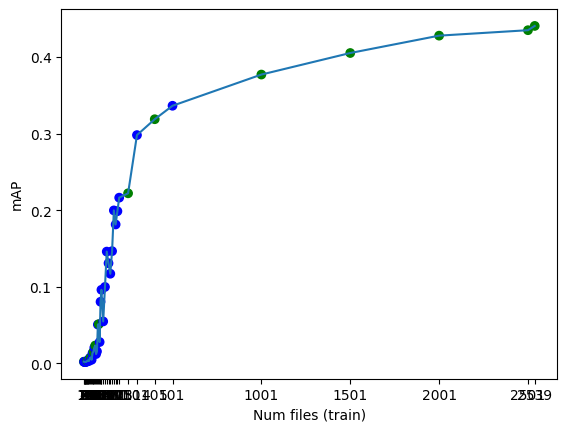

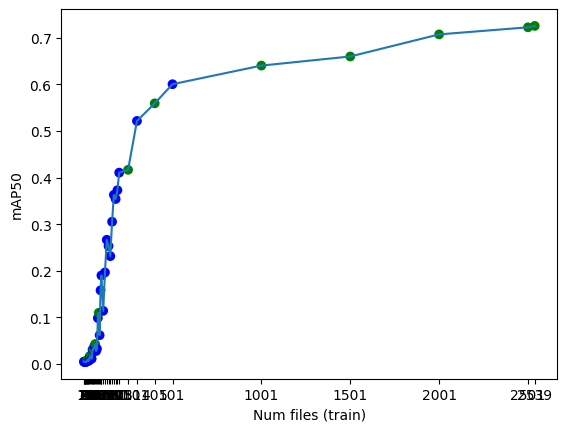

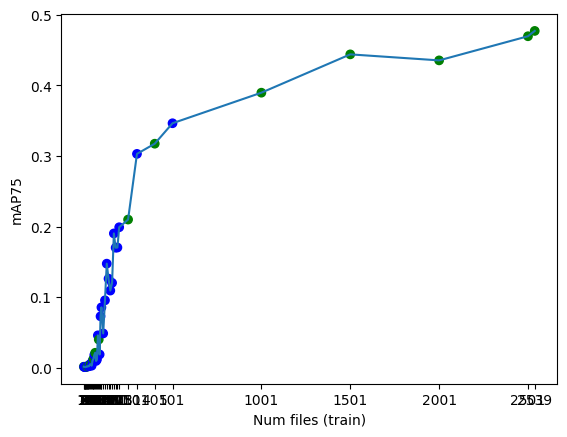

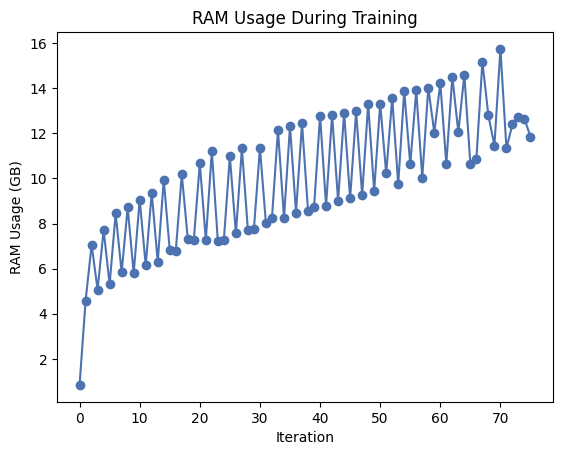

In [4]:
locale.getpreferredencoding = lambda: "UTF-8"

PATH_TO_MODEL = "/kaggle/working/yolov8m-seg.pt"
PATH_TO_YAML = "/kaggle/working/Pothole-Detection-9/data.yaml"
TRAIN_PERC = 0.8
TEST_PERC = 0.1
VAL_PERC = 0.1
KEEP_PERC = 1.0
PIECE_PERC = 0.05
ITERS = 5
FIB_FLAG = True
PREV_NUM = 50
THRESHOLD = 0.001

result_dict_base = dict()
result_dict_inc = dict()
color_dict_inc = dict()

exp_inc = YoloModel(PATH_TO_MODEL, PATH_TO_YAML, TRAIN_PERC, TEST_PERC, VAL_PERC)
# exp_inc.train_test_val_split(KEEP_PERC)
# cls_tl_dict, cls_fif_dict = exp_inc.take_piece(PIECE_PERC, FIB_FLAG)
exp_inc.increm_learning(KEEP_PERC, ITERS, PIECE_PERC, FIB_FLAG, PREV_NUM, THRESHOLD)
exp_inc.plot_ram_usage()

### Сравнение базового и инкрементального обучения

locale.getpreferredencoding = lambda: "UTF-8"

PATH_TO_MODEL = "/kaggle/working/yolov8m-seg.pt"
PATH_TO_YAML = "/kaggle/working/feet-14/data.yaml"
TRAIN_PERC = 0.8
TEST_PERC = 0.1
VAL_PERC = 0.1
KEEP_PERC = 1.0
PIECE_PERC = 0.05
ITERS = 5

result_dict_base = dict()
result_dict_inc = dict()
color_dict_inc = dict()

exp_base = YoloModel(PATH_TO_MODEL, PATH_TO_YAML, TRAIN_PERC, TEST_PERC, VAL_PERC)
result_dict_base = exp_base.base_learning(KEEP_PERC, PIECE_PERC, ITERS)
exp_base.plot_ram_usage()
del(exp_base)

exp_inc = YoloModel(PATH_TO_MODEL, PATH_TO_YAML, TRAIN_PERC, TEST_PERC, VAL_PERC, 1, 1)
result_dict_inc, color_dict_inc = exp_inc.increm_learning(KEEP_PERC, PIECE_PERC, ITERS)
exp_inc.plot_ram_usage()

import math 

map_base_list = [j[0] for j in result_dict_base.values()]
map_inc_list = [j[0] for j in result_dict_inc.values()]
mse = 0
for map_base, map_inc in zip(map_base_list, map_inc_list):
    dev = (map_base - map_inc)
    mse += dev**2
print(f"MSE = {mse}\nRMSE = {math.sqrt(mse)}")

metrics_names = ("mAP","mAP50", "mAP75")
for i, metric in enumerate(metrics_names):
    plt.plot(list(result_dict_base.keys()),
             [j[i] for j in result_dict_base.values()],
             marker='o',
             color="green",
             linestyle='-',
             zorder=0,
             label = "Базовое обучение")
    
    plt.scatter(list(result_dict_inc.keys()),
                [j[i] for j in result_dict_inc.values()],
                color=list(color_dict_inc.values()),
                zorder=1)
    plt.plot(list(result_dict_inc.keys()),
             [j[i] for j in result_dict_inc.values()],
             linestyle='-',
             label = "Инкрементальное обучение")
    
    plt.ylabel(metric)
    plt.xlabel("Keep percent (%)")
    plt.legend()
    plt.show()

num_folders = 1 / PIECE_PERC
for folder in range(int(num_folders)):
    dir_path = f"temp_{folder+1}/train/labels"
    print(dir_path, len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))]))
    dir_path = f"temp_{folder+1}/train/images"
    print(dir_path, len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))]))
    dir_path = f"temp_{folder+1}/valid/labels"
    print(dir_path, len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))]))
    dir_path = f"temp_{folder+1}/valid/images"
    print(dir_path, len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))]), '\n')
    
